# AV Behavior with friction implementation in rainy weather

In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from scipy.stats import norm, binom, poisson
from dtaidistance import dtw
import json

## Testing Parameters

In [2]:
weather_param = [[20,0,0,5,0,0,0,10,0],
        [20,20,20,5,0,20,5,20,0],
        [40,40,40,5,0,40,10,30,0],
        [60,60,60,5,0,60,15,40,0],
        [80,80,80,5,0,80,20,50,0],
        [100,100,100,5,0,100,30,70,0]] 

def calc_fric(weather_list):
    return np.exp(-0.916*weather_list[5]/100) * (1-weather_list[5]/100)**3 * 0.6 + 0.4 - 0.1*weather_list[2]/100

for i in range(len(weather_param)):
    friction_ratio = calc_fric(weather_param[i])
    weather_param[i] += [friction_ratio]

df = pd.DataFrame(weather_param, columns =["cloudiness","precipitation","precipitation_deposits","sun_altitude_angle","sun_azimuth_angle","wetness","fog_density","wind_intensity", "ice_thickness", "friction_ratio"],
) 
# df.index.name = 'Scenarios'
df.to_csv("rain_fric.csv")
df

cloudiness  precipitation  precipitation_deposits  sun_altitude_angle  \
0          20              0                       0                   5   
1          20             20                      20                   5   
2          40             40                      40                   5   
3          60             60                      60                   5   
4          80             80                      80                   5   
5         100            100                     100                   5   

   sun_azimuth_angle  wetness  fog_density  wind_intensity  ice_thickness  \
0                  0        0            0              10              0   
1                  0       20            5              20              0   
2                  0       40           10              30              0   
3                  0       60           15              40              0   
4                  0       80           20              50              0   
5                  0      100           30              70              0   

   friction_ratio  
0        1.000000  
1        0.635775  
2        0.449842  
3        0.362164  
4        0.322307  
5        0.300000

### With reduced friction

In [3]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [4]:
rel_path = "./Data/Ghost Cutin/Rain Reduced Friction Exponential"
os.path.isdir(rel_path)

True

In [5]:
subfolders = os.listdir(path=rel_path)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin']

In [6]:
head = subfolders.pop(1)
subfolders.append(head)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin']

In [7]:
txt_lists_fric = [[] for i in range(6)]

for i in range(len(txt_lists_fric)):
    for root, dirs, files in os.walk(os.path.join(rel_path, subfolders[i])):
        for file in files:
            if file.endswith(".txt"):
                 with open(os.path.join(root, file), encoding = 'utf-8') as f:
                    read_string = f.read()
                    json_object = json.loads(read_string)
                    txt_lists_fric[i].append(json_object)

In [8]:
txt_lists_fric[2][50]
# txt_lists_fric[0]

{'_checkpoint': {'global_record': {},
  'progress': [0, 1],
  'records': [{'index': 0,
    'infractions': {'collisions_layout': [],
     'collisions_pedestrian': [],
     'collisions_vehicle': [],
     'outside_route_lanes': [],
     'red_light': [],
     'route_dev': [],
     'route_timeout': [],
     'stop_infraction': [],
     'vehicle_blocked': []},
    'meta': {'duration_game': 19.275000287219882,
     'duration_system': 35.48889398574829,
     'route_length': 131.56012567009267},
    'route_id': 'RouteScenario_0',
    'scores': {'score_composed': 100.0,
     'score_penalty': 1.0,
     'score_route': 100.0},
    'status': 'Completed'}]},
 'eligible': False,
 'entry_status': 'Started',
 'labels': [],
 'sensors': ['carla_camera',
  'carla_camera',
  'carla_camera',
  'carla_imu',
  'carla_gnss',
  'carla_speedometer'],
 'values': []}

In [9]:
avg_complete_fric = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        if txt['_checkpoint']['records'][0]['status'] == 'Completed':
            count += 1
    avg_complete_fric[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average complete ratio':avg_complete_fric}) 
# df.index.name = 'Scenarios'

df

Scenarios  \
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin   
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin   
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin   
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin   
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin   
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin   

   Average complete ratio  
0                     1.0  
1                     1.0  
2                     1.0  
3                     1.0  
4                     1.0  
5                     1.0

In [10]:
count = 0

avg_score_fric = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        count += txt['_checkpoint']['records'][0]['scores']['score_route'] 
    avg_score_fric[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average score route':avg_score_fric}) 
df

Scenarios  Average score route
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin                100.0
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin                100.0
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin                100.0
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin                100.0
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin                100.0
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin                100.0

#### Setting up into list of DataFrames

In [11]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [12]:
os.path.isdir("./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_clear-sunset_fi_ghost_cutin\\route_highway_epoch24_clear-sunset_fi_ghost_cutin_0\\")

False

In [13]:
df_array_fric = np.empty((6,100), dtype=object)

for i in range(len(df_array_fric)):
    for j in range((len(df_array_fric[i]))):
        df_array_fric[i][j] = pd.DataFrame()

In [14]:
for i in range(len(txt_lists_fric)):
    dir_path = os.path.join(rel_path, subfolders[i])
    print(dir_path)
    # list to store files
    res = []

    # Iterate directory
    run_index = 0
    for path in os.listdir(dir_path):
        # check if current path is a file
        if not os.path.isfile(os.path.join(dir_path, path)):
            df = pd.DataFrame()
            for file in os.listdir(os.path.join(dir_path, path)):
                file_path = os.path.join(dir_path, os.path.join(path, file))
    #             print("file_path", file_path)
                if "_ctl.csv" in file_path:
                    df = pd.read_csv(file_path)
                elif "_cvip.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)
                elif "_traj.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)

            df_array_fric[i][run_index] = df
            run_index += 1

./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_clear-sunset_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-20_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-40_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-60_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-80_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-100_fi_ghost_cutin


In [15]:
df_array_fric[5][99]

ts  agent_id  throttle     steer  brake       ts  agent_id  \
0    5620880         0  0.900000 -0.010108    0.0  5620880         0   
1    5620881         0  0.900000 -0.007949    0.0  5620881         0   
2    5620882         0  0.900000 -0.008484    0.0  5620882         0   
3    5620883         0  0.900000 -0.009369    0.0  5620883         0   
4    5620884         0  0.900000 -0.007358    0.0  5620884         0   
..       ...       ...       ...       ...    ...      ...       ...   
758  5621638         0  0.486522 -0.006474    0.0  5621638         0   
759  5621639         0  0.428984 -0.005667    0.0  5621639         0   
760  5621640         0  0.382056 -0.003961    0.0  5621640         0   
761  5621641         0  0.387291 -0.005092    0.0  5621641         0   
762  5621642         0  0.526358 -0.003959    0.0  5621642         0   

           cvip      cvip_x     cvip_y      cvip_z       ts  agent_id  \
0    500.497261  198.767441 -95.832657 -499.788727  5620880         0   
1      5.598742  195.567444 -90.832657    0.100000  5620881         0   
2      5.595580  195.567444 -90.832657    0.095407  5620882         0   
3      5.592744  195.567444 -90.832657    0.084691  5620883         0   
4      5.590235  195.567444 -90.832657    0.067854  5620884         0   
..          ...         ...        ...         ...      ...       ...   
758   22.195371  192.937500  65.189919   -0.068269  5621638         0   
759   22.241125  192.938126  65.457619   -0.068268  5621639         0   
760   22.287988  192.937927  65.726036   -0.068266  5621640         0   
761   22.335895  192.937027  65.995163   -0.068265  5621641         0   
762   22.384793  192.935516  66.264984   -0.068264  5621642         0   

              x          y         z         v  
0    192.362411 -86.262680  0.576039  0.000000  
1    192.362411 -86.262680  0.534733  0.000000  
2    192.362411 -86.262680  0.487313  0.000000  
3    192.362411 -86.262680  0.433781  0.000000  
4    192.362411 -86.262680  0.374139  0.000000  
..          ...        ...       ...       ...  
758  193.174637  42.995865 -0.020996  8.889807  
759  193.170563  43.217758 -0.020988  8.873562  
760  193.166519  43.439270 -0.020982  8.858427  
761  193.162613  43.660458 -0.020978  8.845835  
762  193.158844  43.881355 -0.020978  8.834757  

[763 rows x 17 columns]

In [16]:
df_array_fric[0][0]['x']

0      192.362411
1      192.362411
2      192.362411
3      192.362411
4      192.362411
          ...    
771    193.158905
772    193.155640
773    193.152634
774    193.149918
775    193.147476
Name: x, Length: 776, dtype: float64

### Without friction reduction

In [17]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [18]:
rel_path = "./Data/Ghost Cutin/Rain Original/"
os.path.isdir(rel_path)

True

In [19]:
subfolders = os.listdir(path=rel_path)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin']

In [20]:
head = subfolders.pop(1)
subfolders.append(head)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin']

In [21]:
txt_lists_fric = [[] for i in range(6)]

for i in range(len(txt_lists_fric)):
    for root, dirs, files in os.walk(os.path.join(rel_path, subfolders[i])):
        for file in files:
            if file.endswith(".txt"):
                 with open(os.path.join(root, file), encoding = 'utf-8') as f:
                    read_string = f.read()
                    json_object = json.loads(read_string)
                    txt_lists_fric[i].append(json_object)

In [22]:
txt_lists_fric[2][50]
# txt_lists_fric[0]

{'_checkpoint': {'global_record': {},
  'progress': [0, 1],
  'records': [{'index': 0,
    'infractions': {'collisions_layout': [],
     'collisions_pedestrian': [],
     'collisions_vehicle': [],
     'outside_route_lanes': [],
     'red_light': [],
     'route_dev': [],
     'route_timeout': [],
     'stop_infraction': [],
     'vehicle_blocked': []},
    'meta': {'duration_game': 19.275000287219882,
     'duration_system': 35.04421281814575,
     'route_length': 131.56012567009267},
    'route_id': 'RouteScenario_0',
    'scores': {'score_composed': 100.0,
     'score_penalty': 1.0,
     'score_route': 100.0},
    'status': 'Completed'}]},
 'eligible': False,
 'entry_status': 'Started',
 'labels': [],
 'sensors': ['carla_camera',
  'carla_camera',
  'carla_camera',
  'carla_imu',
  'carla_gnss',
  'carla_speedometer'],
 'values': []}

In [23]:
avg_complete_orig = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        if txt['_checkpoint']['records'][0]['status'] == 'Completed':
            count += 1
    avg_complete_orig[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average complete ratio':avg_complete_orig}) 
# df.index.name = 'Scenarios'

df

Scenarios  \
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin   
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin   
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin   
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin   
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin   
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin   

   Average complete ratio  
0                     1.0  
1                     1.0  
2                     1.0  
3                     1.0  
4                     1.0  
5                     1.0

In [24]:
count = 0

avg_score_orig = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        count += txt['_checkpoint']['records'][0]['scores']['score_route'] 
    avg_score_orig[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average score route':avg_score_orig}) 
df

Scenarios  Average score route
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin                100.0
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin                100.0
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin                100.0
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin                100.0
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin                100.0
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin                100.0

#### Setting up into list of DataFrames

In [25]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [26]:
os.path.isdir("./Data/Ghost Cutin/Rain Original/route_highway_epoch24_clear-sunset_fi_ghost_cutin\\route_highway_epoch24_clear-sunset_fi_ghost_cutin_0\\")

True

In [27]:
df_array_orig = np.empty((6,100), dtype=object)

for i in range(len(df_array_orig)):
    for j in range((len(df_array_orig[i]))):
        df_array_orig[i][j] = pd.DataFrame()

In [28]:
rel_path = "./Data/Ghost Cutin/Rain Original/"

for i in range(len(txt_lists_fric)):
    dir_path = os.path.join(rel_path, subfolders[i])
    print(dir_path)
    
    # list to store files
    res = []

    # Iterate directory
    run_index = 0
    for path in os.listdir(dir_path):
        # check if current path is a file
        if not os.path.isfile(os.path.join(dir_path, path)):
            df = pd.DataFrame()
            for file in os.listdir(os.path.join(dir_path, path)):
                file_path = os.path.join(dir_path, os.path.join(path, file))
    #             print("file_path", file_path)
                if "_ctl.csv" in file_path:
                    df = pd.read_csv(file_path)
                elif "_cvip.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)
                elif "_traj.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)

            df_array_orig[i][run_index] = df
            run_index += 1

./Data/Ghost Cutin/Rain Original/route_highway_epoch24_clear-sunset_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/route_highway_epoch24_rain-sunset-20_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/route_highway_epoch24_rain-sunset-40_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/route_highway_epoch24_rain-sunset-60_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/route_highway_epoch24_rain-sunset-80_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/route_highway_epoch24_rain-sunset-100_fi_ghost_cutin


In [29]:
df_array_orig[5][99]

ts  agent_id  throttle     steer  brake       ts  agent_id  \
0    1999991         0  0.900000 -0.033090    0.0  1999991         0   
1    1999992         0  0.900000 -0.006379    0.0  1999992         0   
2    1999993         0  0.900000 -0.007254    0.0  1999993         0   
3    1999994         0  0.900000 -0.008215    0.0  1999994         0   
4    1999995         0  0.900000 -0.007269    0.0  1999995         0   
..       ...       ...       ...       ...    ...      ...       ...   
755  2000746         0  0.447193 -0.004308    0.0  2000746         0   
756  2000747         0  0.386586 -0.003830    0.0  2000747         0   
757  2000748         0  0.319288 -0.004429    0.0  2000748         0   
758  2000749         0  0.360940 -0.002549    0.0  2000749         0   
759  2000750         0  0.401994 -0.001874    0.0  2000750         0   

           cvip      cvip_x     cvip_y      cvip_z       ts  agent_id  \
0    500.497261  198.767441 -95.832657 -499.788727  1999991         0   
1      5.598742  195.567444 -90.832657    0.100000  1999992         0   
2      5.595580  195.567444 -90.832657    0.095407  1999993         0   
3      5.592744  195.567444 -90.832657    0.084691  1999994         0   
4      5.590235  195.567444 -90.832657    0.067854  1999995         0   
..          ...         ...        ...         ...      ...       ...   
755   47.758619  192.645325  90.840874   -0.068181  2000746         0   
756   47.865637  192.641464  91.173790   -0.068178  2000747         0   
757   47.972575  192.637589  91.506508   -0.068175  2000748         0   
758   48.079407  192.633728  91.839012   -0.068172  2000749         0   
759   48.186142  192.629852  92.171288   -0.068169  2000750         0   

              x          y         z         v  
0    192.362411 -86.262680  0.576039  0.000000  
1    192.362411 -86.262680  0.534733  0.000000  
2    192.362411 -86.262680  0.487313  0.000000  
3    192.362411 -86.262680  0.433781  0.000000  
4    192.362411 -86.262680  0.374139  0.000000  
..          ...        ...       ...       ...  
755  193.211365  43.085632 -0.021089  9.040710  
756  193.207825  43.311527 -0.021084  9.035857  
757  193.204330  43.537304 -0.021080  9.031117  
758  193.200928  43.762974 -0.021077  9.026769  
759  193.197647  43.988514 -0.021074  9.021585  

[760 rows x 17 columns]

In [30]:
df_array_orig[2][1]['x']

0      192.362411
1      192.362411
2      192.362411
3      192.362411
4      192.362411
          ...    
763    193.165634
764    193.162415
765    193.159348
766    193.156448
767    193.153763
Name: x, Length: 768, dtype: float64

## Comparing completion rate and scores

In [31]:
avg_score_orig
avg_score_fric
avg_complete_orig
avg_complete_fric

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

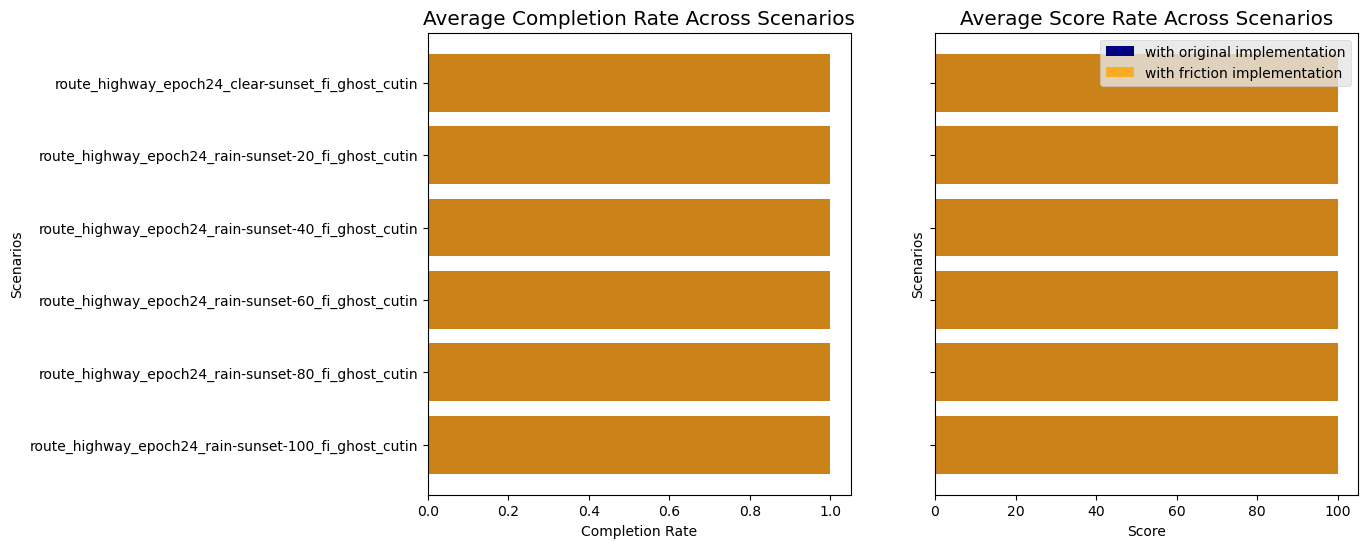

In [32]:
friction_legend = ["with original implementation", "with friction implementation"]

plt.subplots(1, 2, sharey=True, figsize=(12,6))
plt.gca().invert_yaxis()
width = 0.25

plt.subplot(1, 2, 1)
plt.style.use('ggplot')
plt.barh(subfolders, avg_complete_orig, label=friction_legend[0], color="navy")
plt.barh(subfolders, avg_complete_fric, label=friction_legend[1], color="orange" , alpha = 0.8)
plt.title('Average Completion Rate Across Scenarios')
plt.ylabel('Scenarios')
plt.xlabel('Completion Rate')


plt.subplot(1, 2, 2)
plt.style.use('ggplot')
plt.barh(subfolders, avg_score_orig, label=friction_legend[0], color="navy")
plt.barh(subfolders, avg_score_fric, label=friction_legend[1], color="orange" , alpha = 0.8)
plt.title('Average Score Rate Across Scenarios')
plt.ylabel('Scenarios')
plt.xlabel('Score')

plt.legend()
plt.show()

## Comparison

In [33]:
attribute_order = ["x", "y", "v", "cvip", "steer", "brake", "throttle"]

all_medians = np.empty((len(txt_lists_fric), len(attribute_order), 2), dtype=object)
# [[[], []] * len(attribute_order)  for i in range(len(txt_lists_fric))]

all_medians

array([[[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]]], dtype=object)

In [34]:

full_legend = subfolders.copy()
# for i in range(len(subfolders)):
#     for j in range(len(friction_legend)):
#         full_legend.append(subfolders[i]+friction_legend[j])

full_legend

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin']

### x,y traces

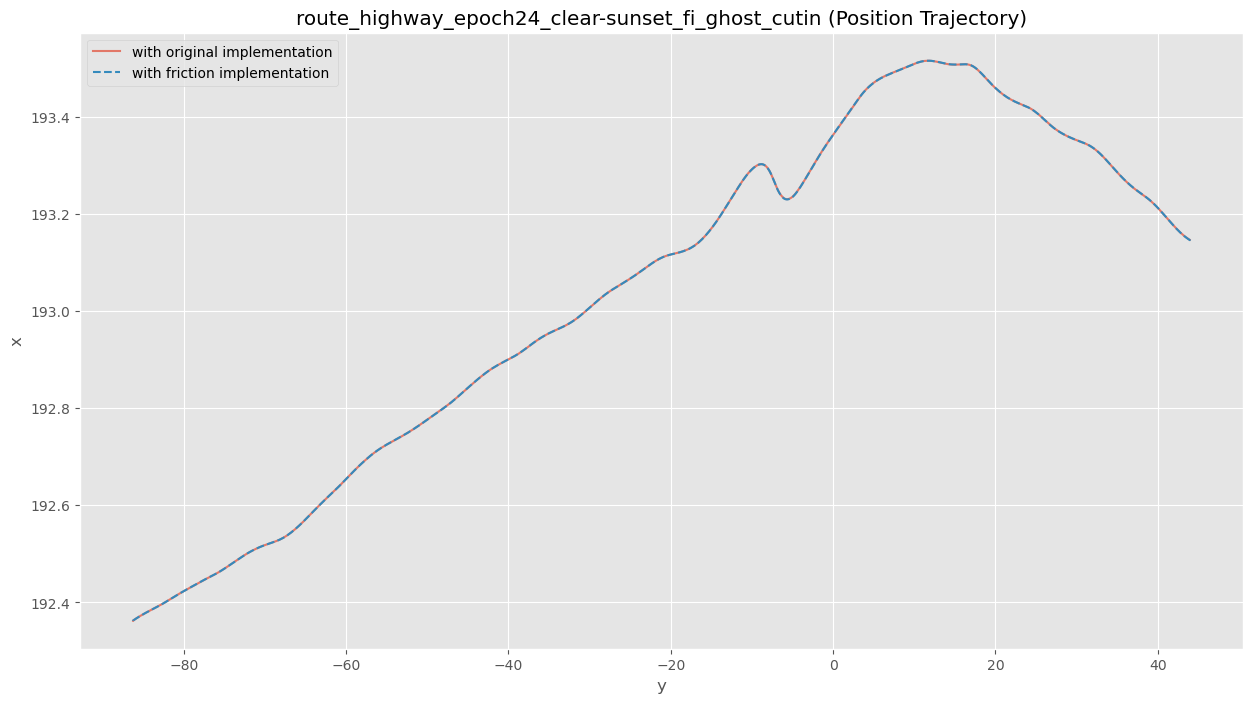

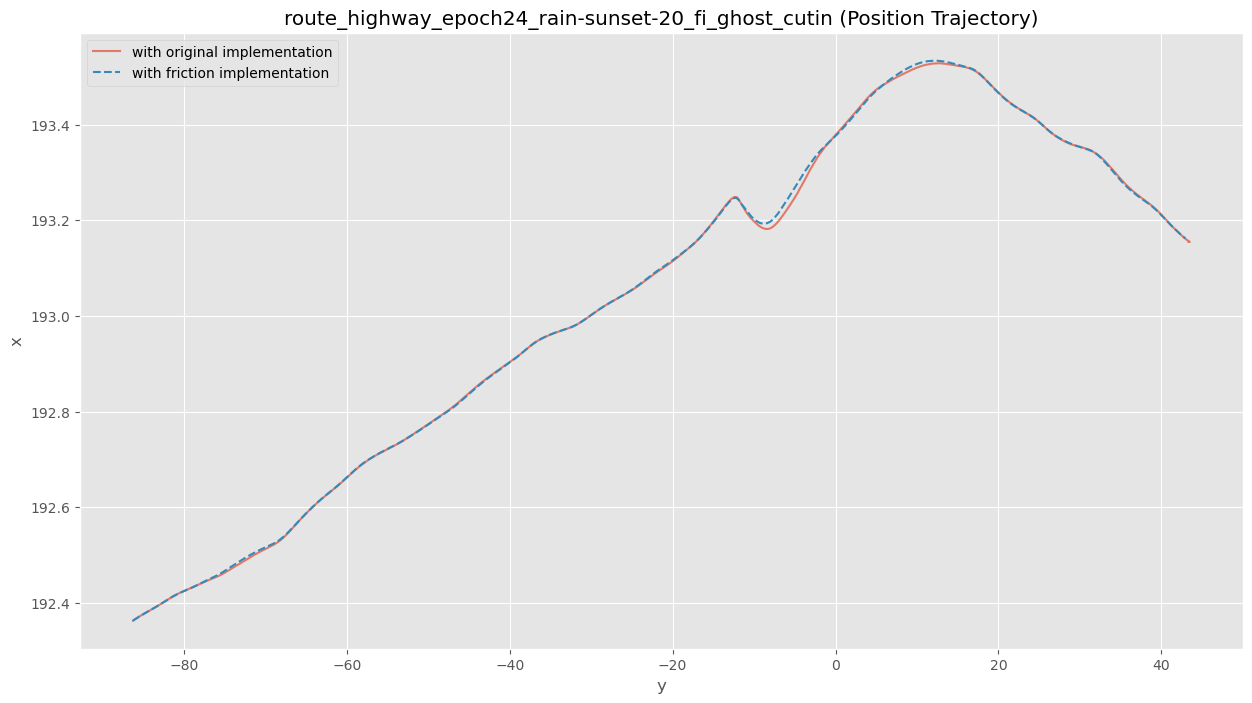

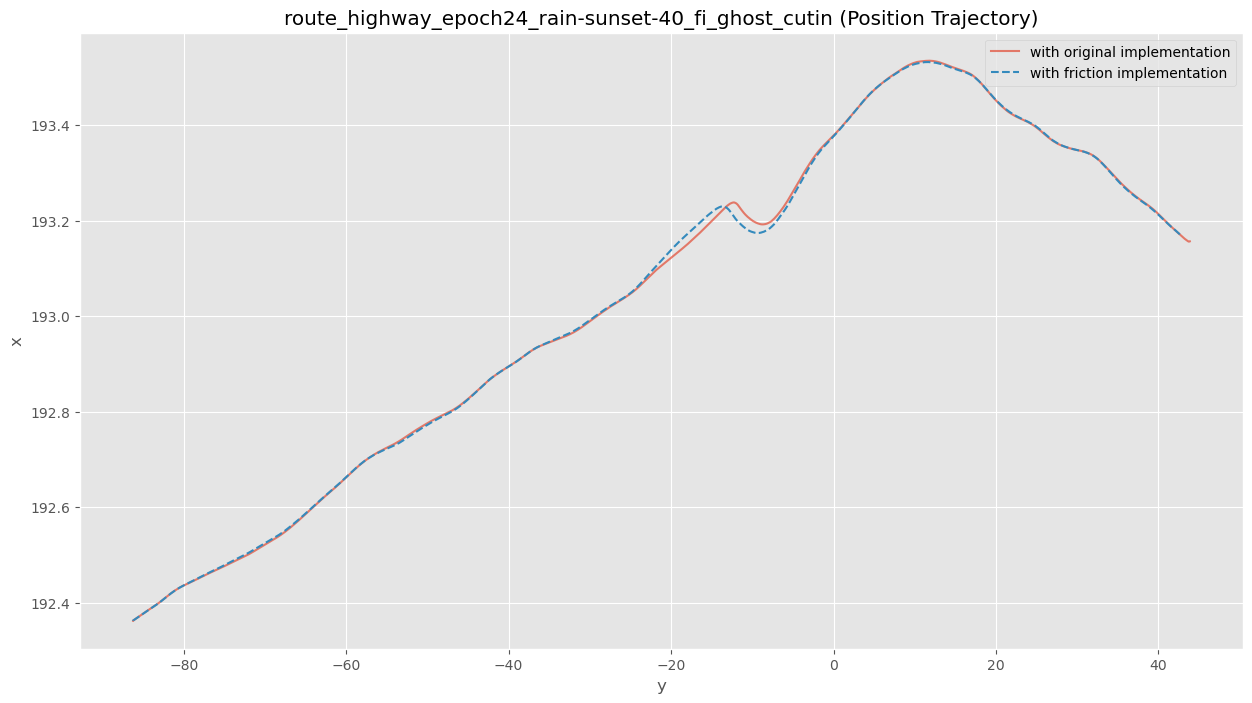

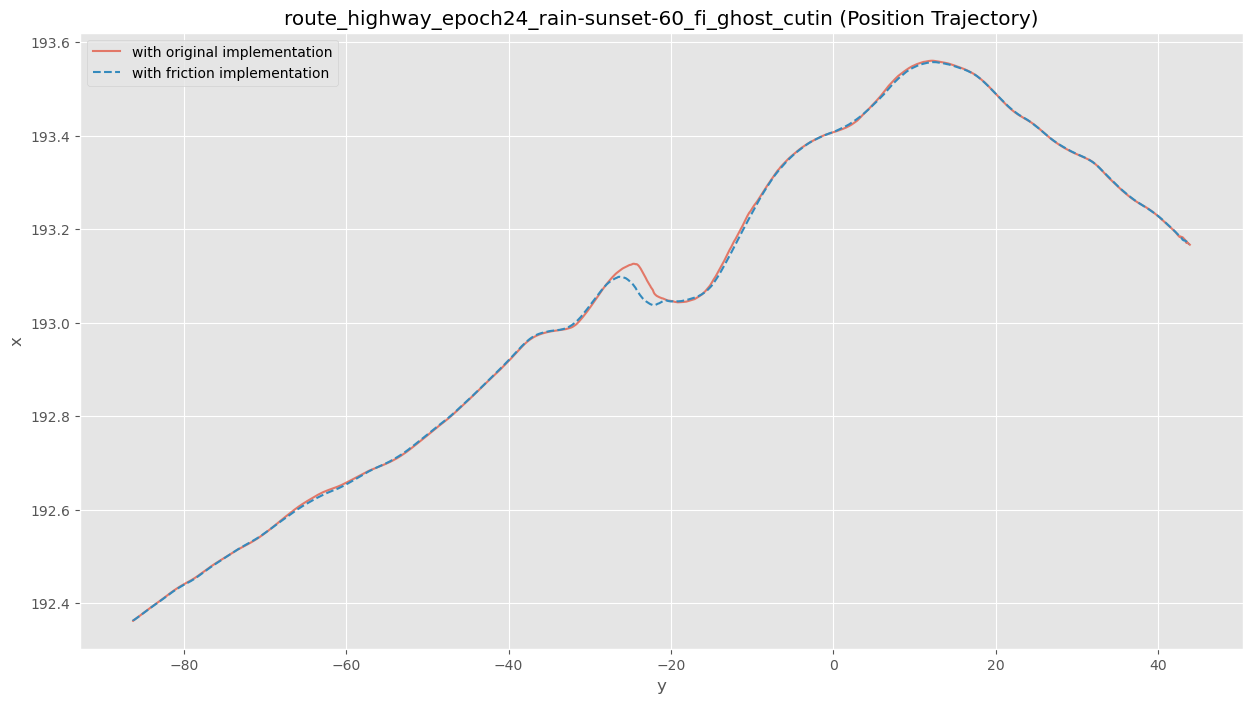

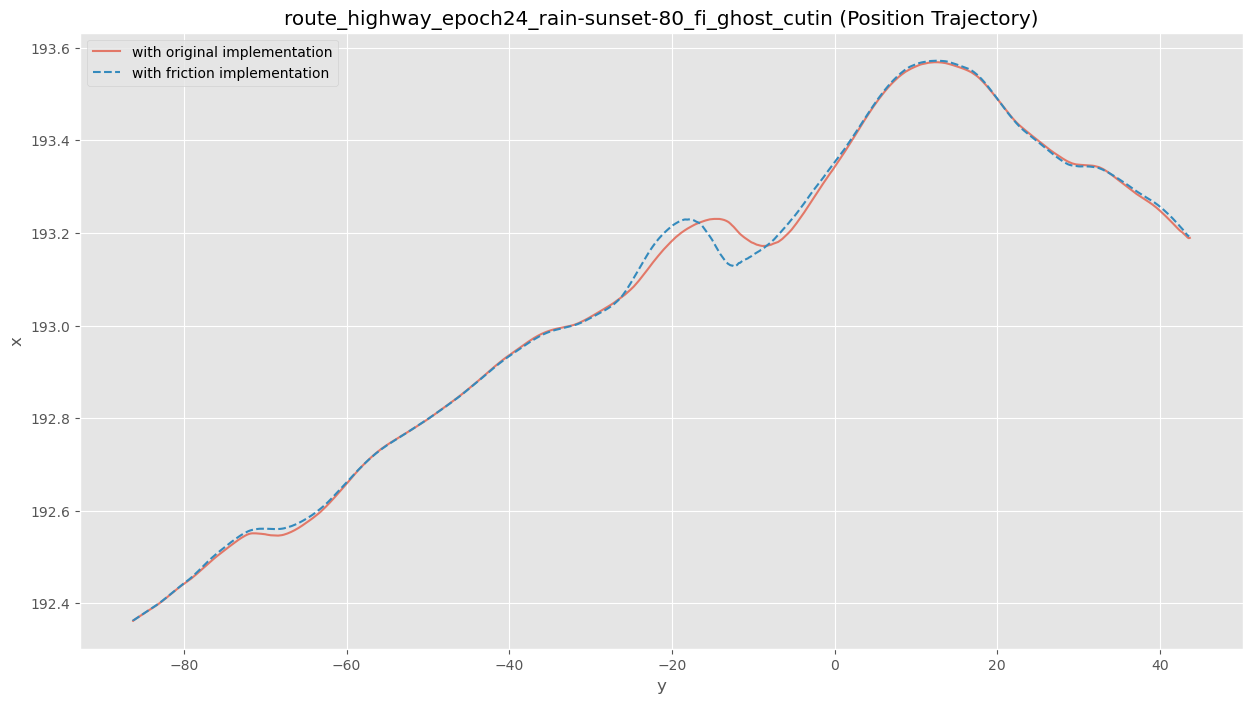

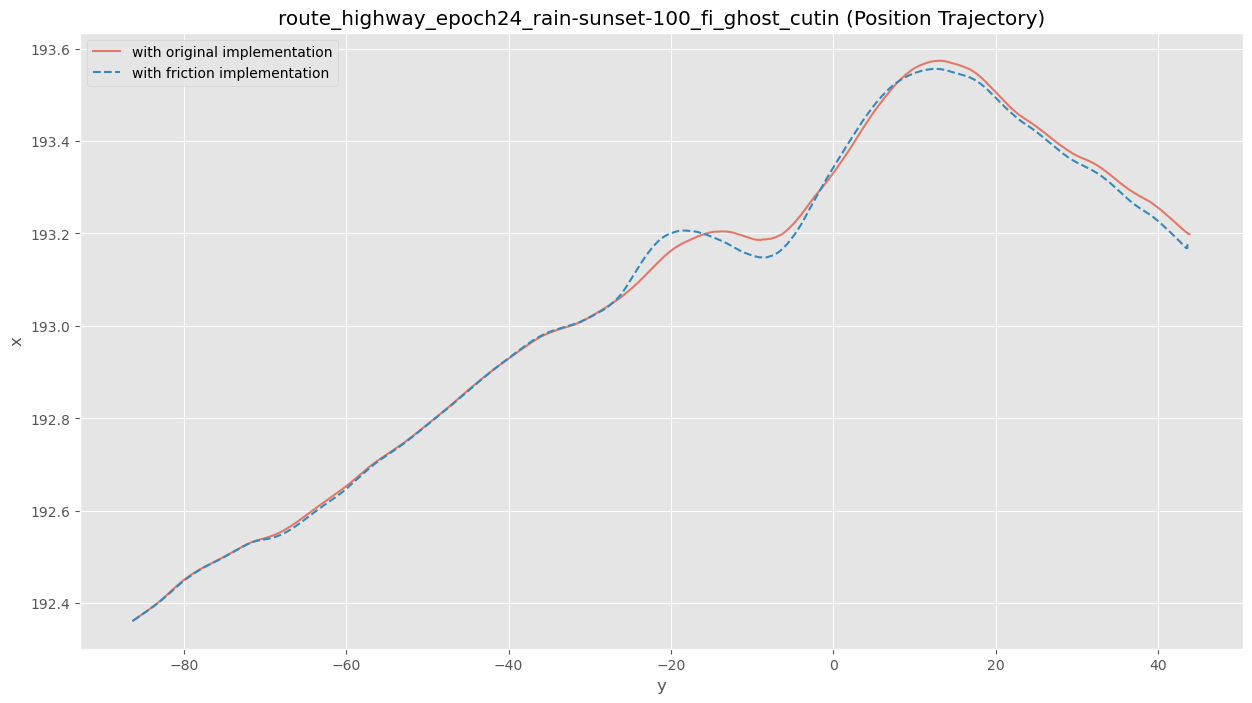

In [35]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_x = pd.DataFrame()
    df_orig_y = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['x'].dtypes == 'object' or df_array_orig[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['x'].isnull().values.any() and not df_array_orig[weather][i]['y'].isnull().values.any():
                df_orig_x["Run"+str(i)] = df_array_orig[weather][i]['x']
                df_orig_y["Run"+str(i)] = df_array_orig[weather][i]['y']

    median_orig_x = df_orig_x.median(axis=1)
    median_orig_y = df_orig_y.median(axis=1)

    plt.plot(median_orig_y, median_orig_x, alpha=0.7)


    df_fric_x = pd.DataFrame()
    df_fric_y = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['x'].dtypes == 'object' or df_array_fric[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['x'].isnull().values.any() and not df_array_fric[weather][i]['y'].isnull().values.any():
                df_fric_x["Run"+str(i)] = df_array_fric[weather][i]['x']
                df_fric_y["Run"+str(i)] = df_array_fric[weather][i]['y']

    median_fric_x = df_fric_x.median(axis=1)
    median_fric_y = df_fric_y.median(axis=1)

    
    all_medians[weather][0][0] = median_orig_x
    all_medians[weather][0][1] = median_fric_x
    all_medians[weather][1][0] = median_orig_y
    all_medians[weather][1][1] = median_fric_y
    
    plt.plot(median_fric_y, median_fric_x, '--')
    plt.xlabel("y")
    plt.ylabel("x")
    
    plt.title(subfolders[weather] + " (Position Trajectory)")
    plt.legend(friction_legend)
    plt.show()
    

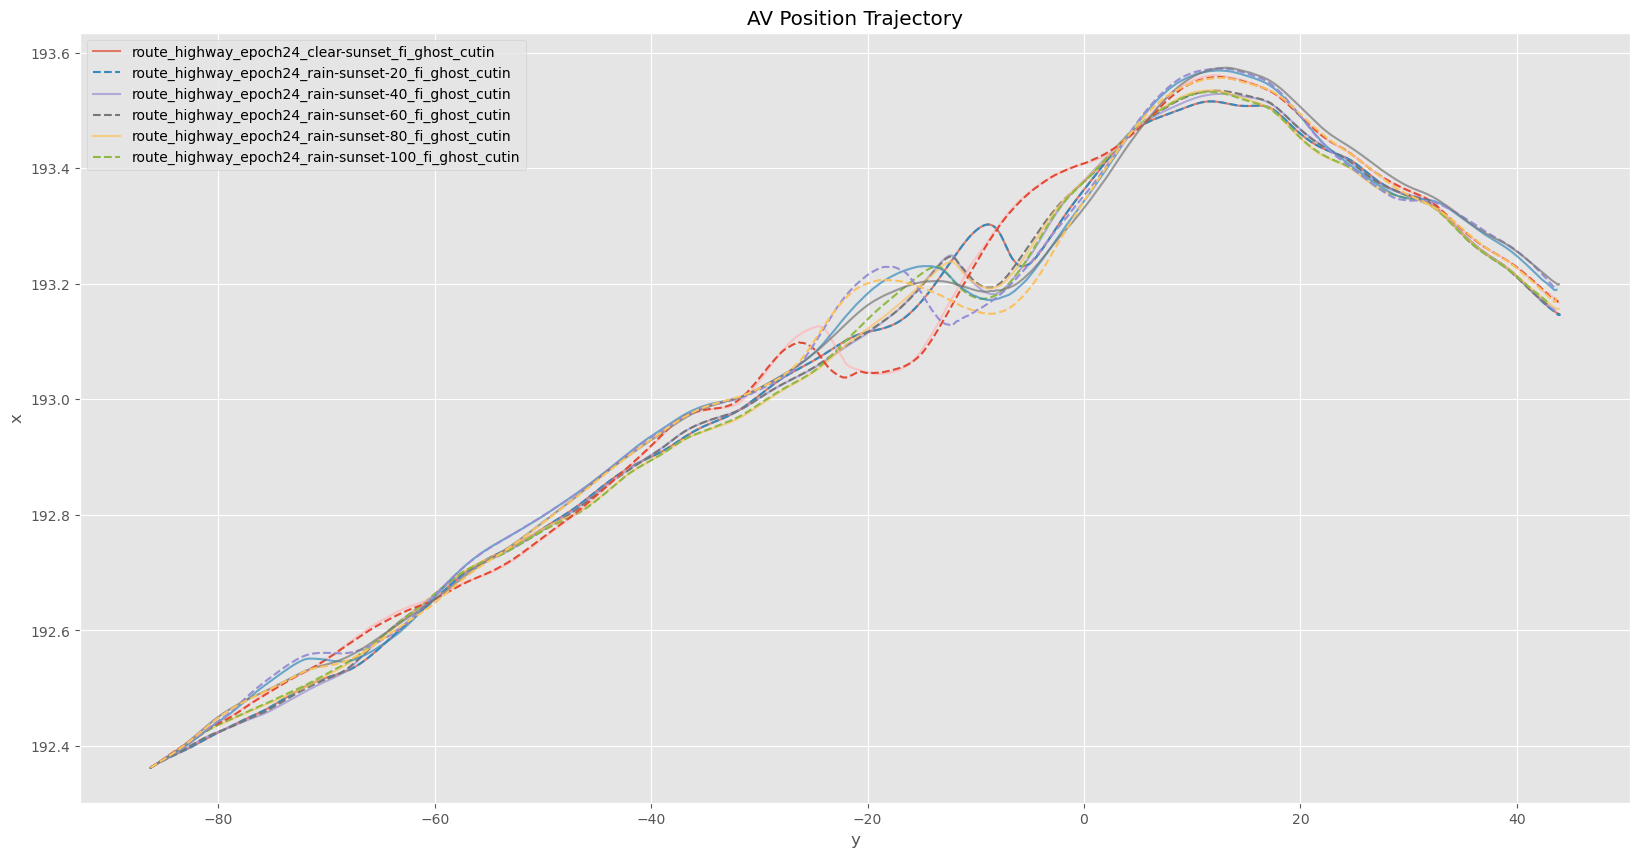

In [36]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    df_orig_x = pd.DataFrame()
    df_orig_y = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['x'].dtypes == 'object' or df_array_orig[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['x'].isnull().values.any() and not df_array_orig[weather][i]['y'].isnull().values.any():
                df_orig_x["Run"+str(i)] = df_array_orig[weather][i]['x']
                df_orig_y["Run"+str(i)] = df_array_orig[weather][i]['y']

    median_orig_x = df_orig_x.median(axis=1)
    median_orig_y = df_orig_y.median(axis=1)

    plt.plot(median_orig_y, median_orig_x, alpha=0.7)


    df_fric_x = pd.DataFrame()
    df_fric_y = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['x'].dtypes == 'object' or df_array_fric[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['x'].isnull().values.any() and not df_array_fric[weather][i]['y'].isnull().values.any():
                df_fric_x["Run"+str(i)] = df_array_fric[weather][i]['x']
                df_fric_y["Run"+str(i)] = df_array_fric[weather][i]['y']

    median_fric_x = df_fric_x.median(axis=1)
    median_fric_y = df_fric_y.median(axis=1)

    plt.plot(median_fric_y, median_fric_x, '--')
    
# plt.axis('equal')
plt.xlabel("y")
plt.ylabel("x")
plt.title("AV Position Trajectory")
plt.legend(full_legend)
plt.show()

### v

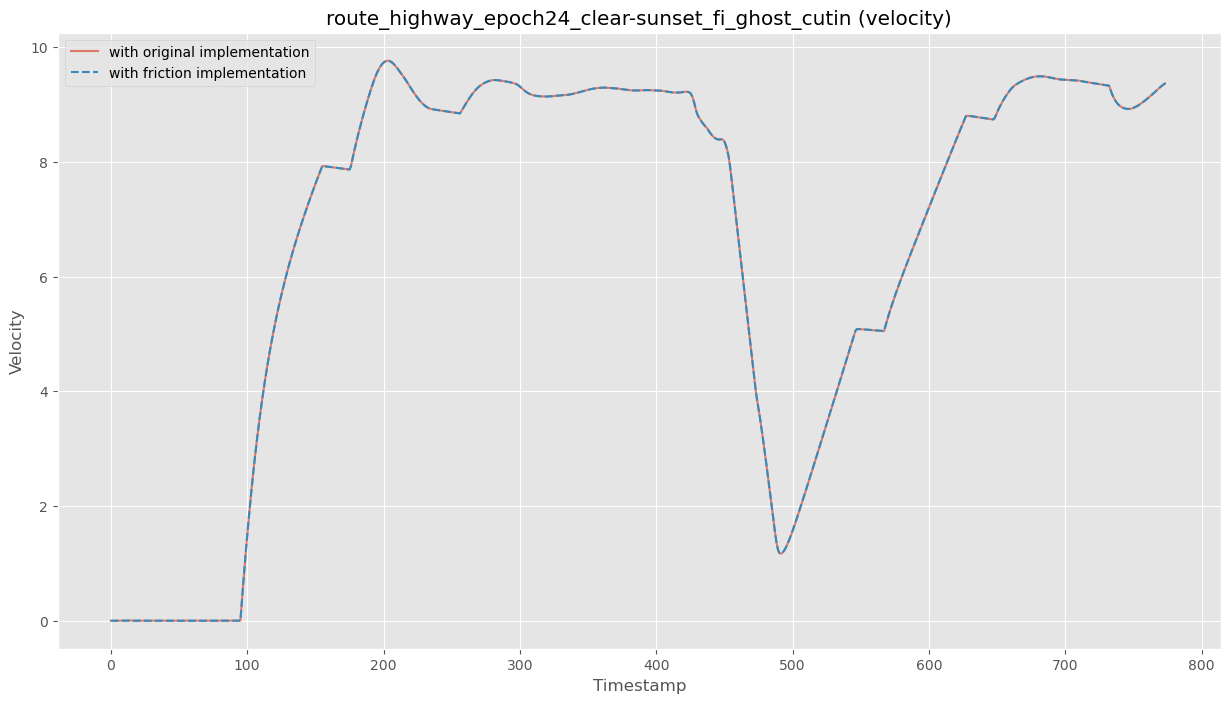

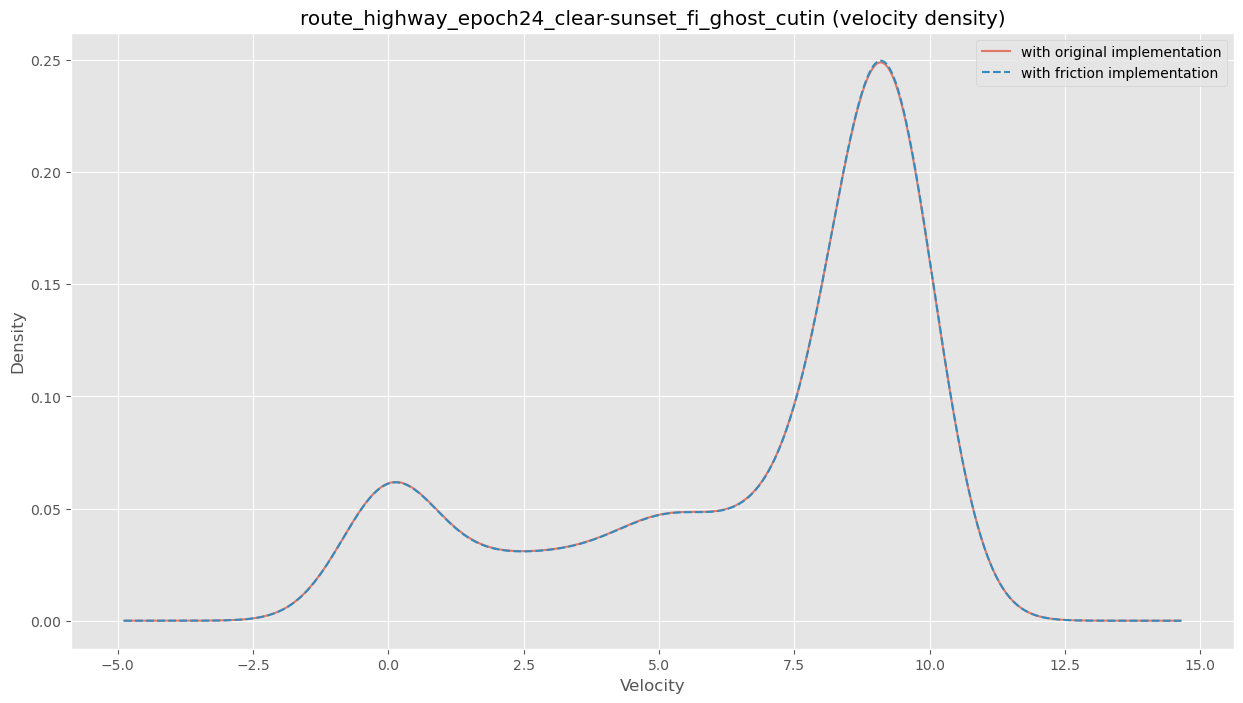

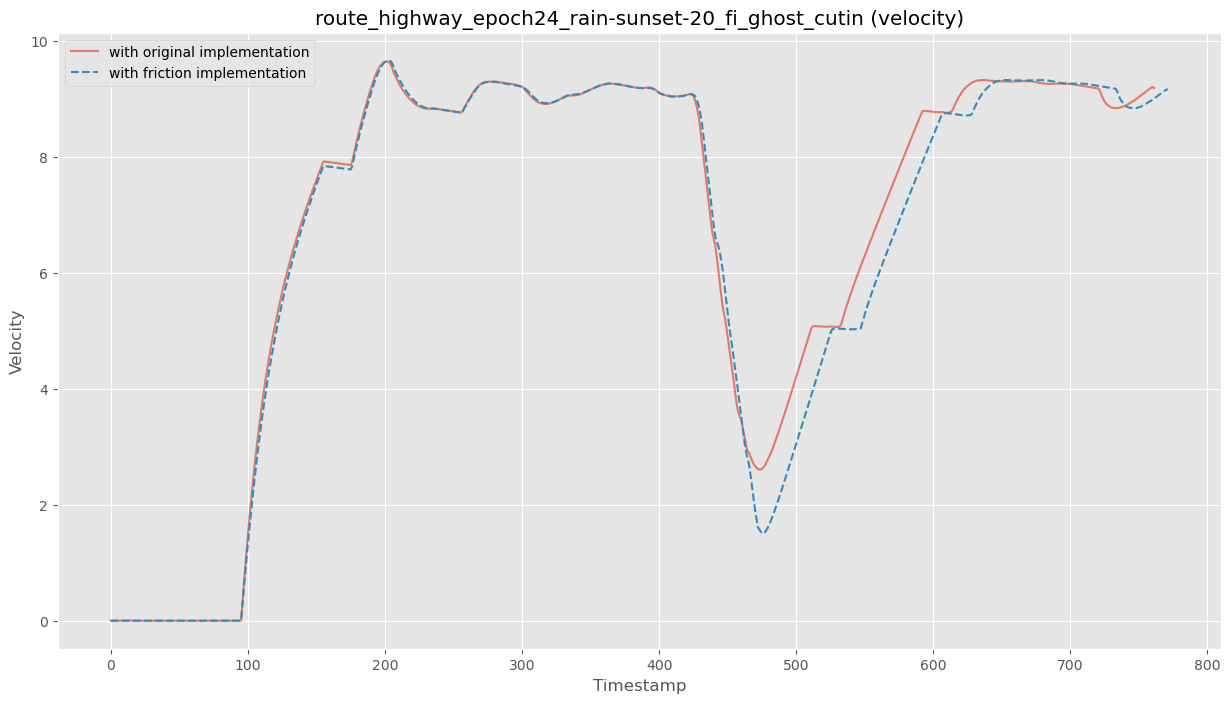

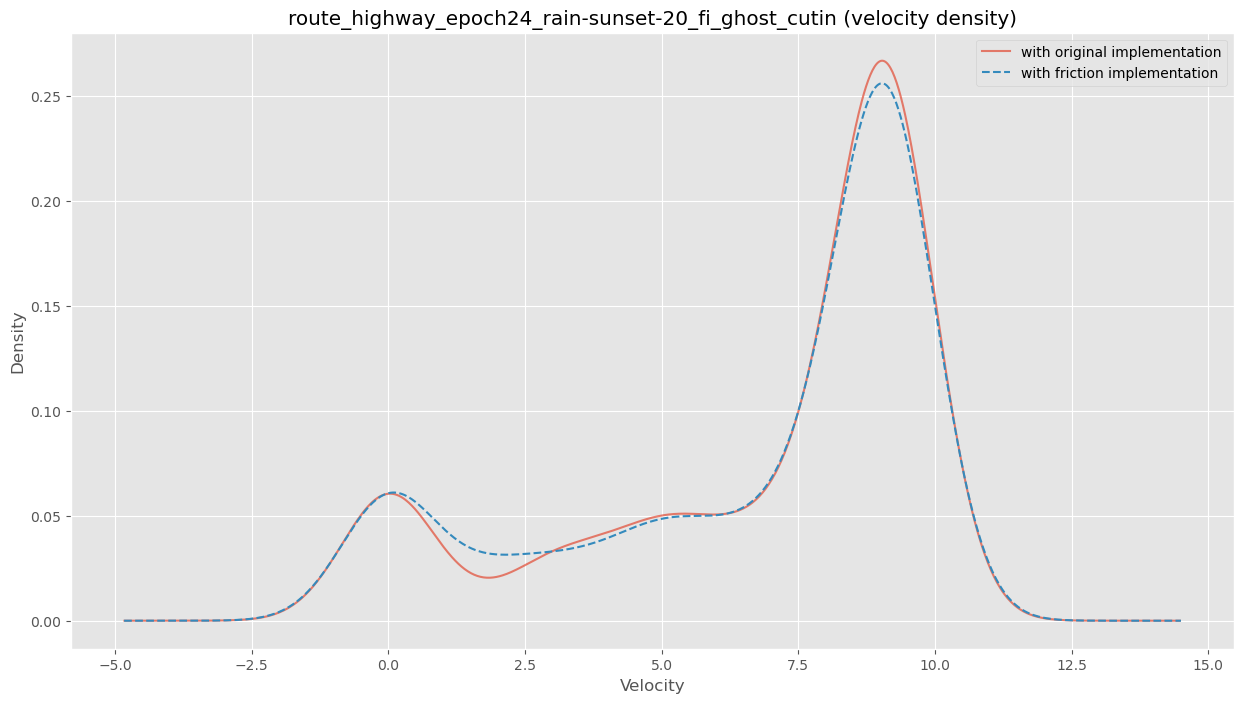

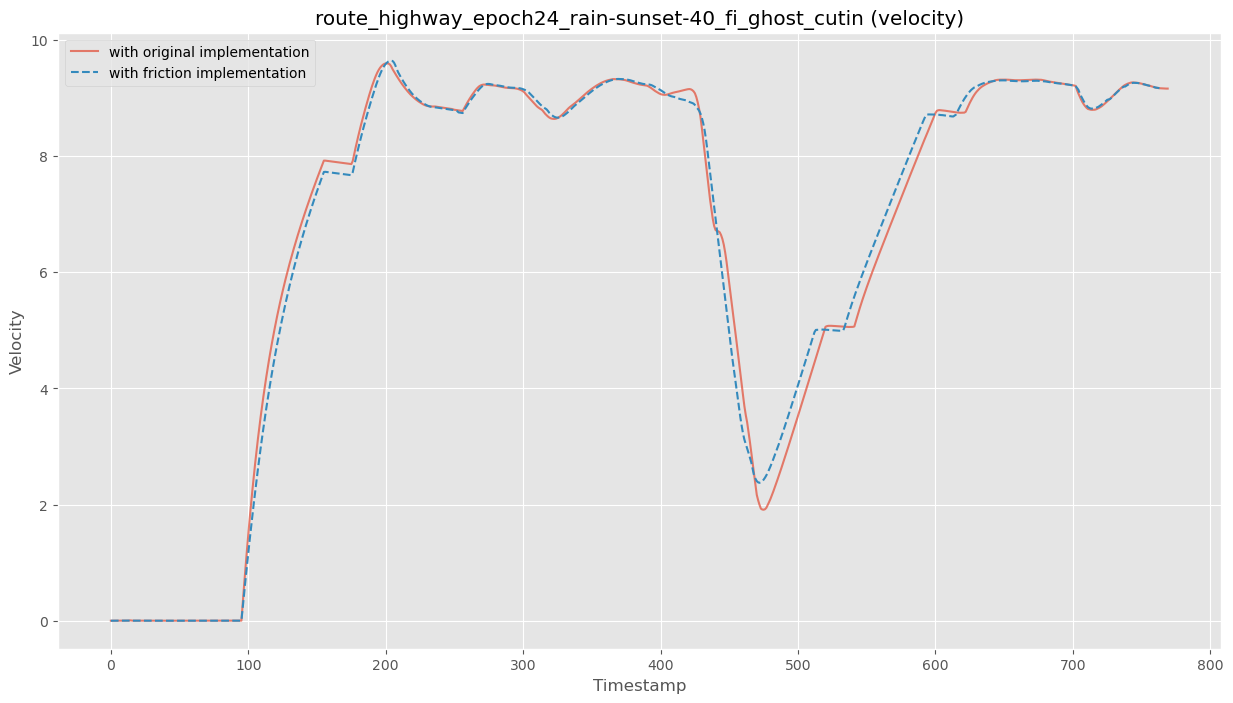

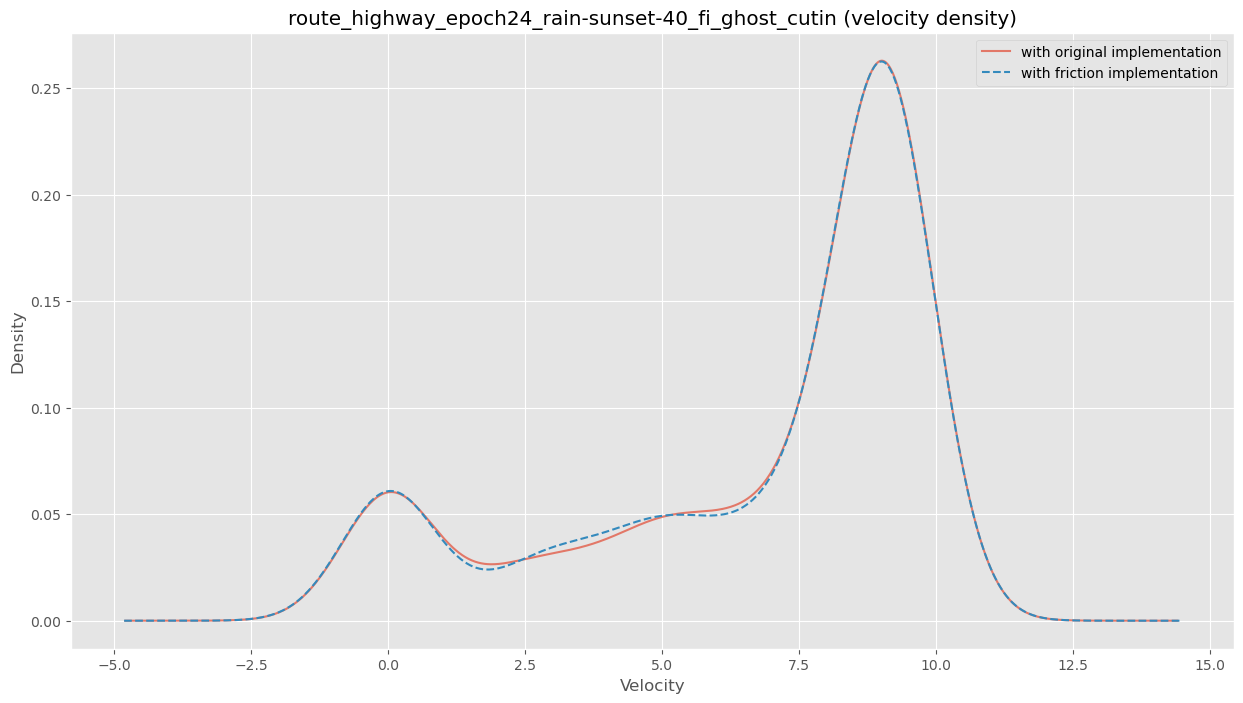

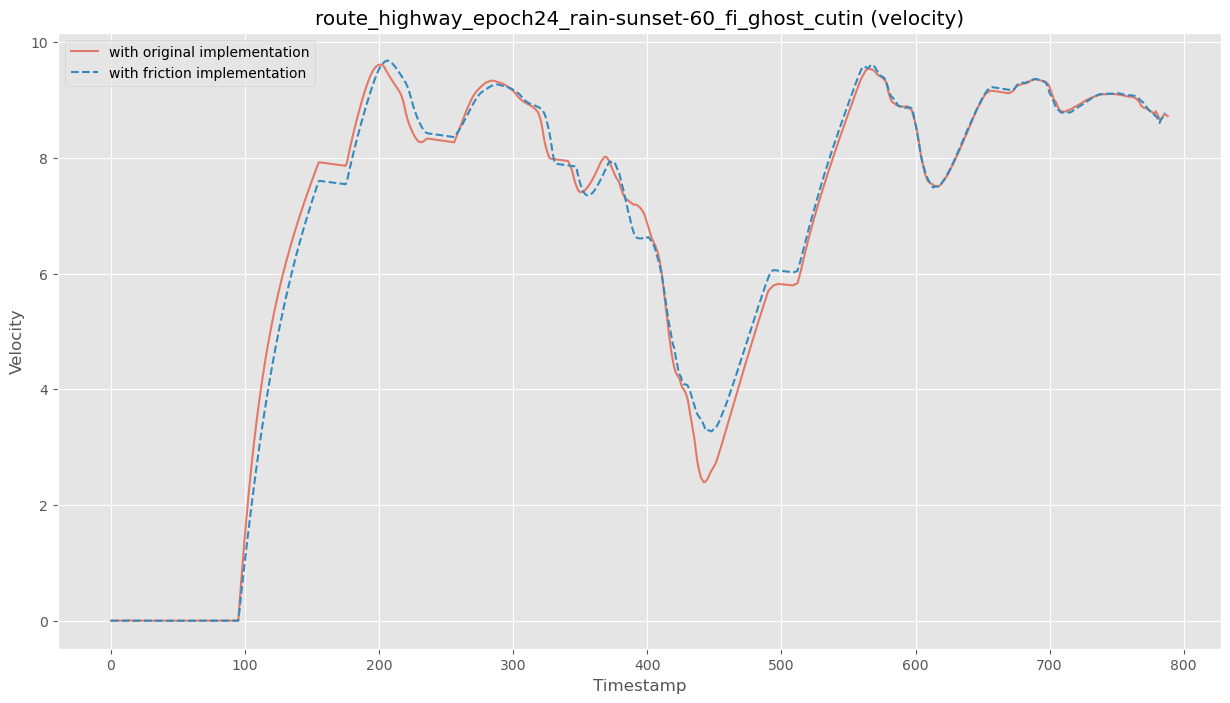

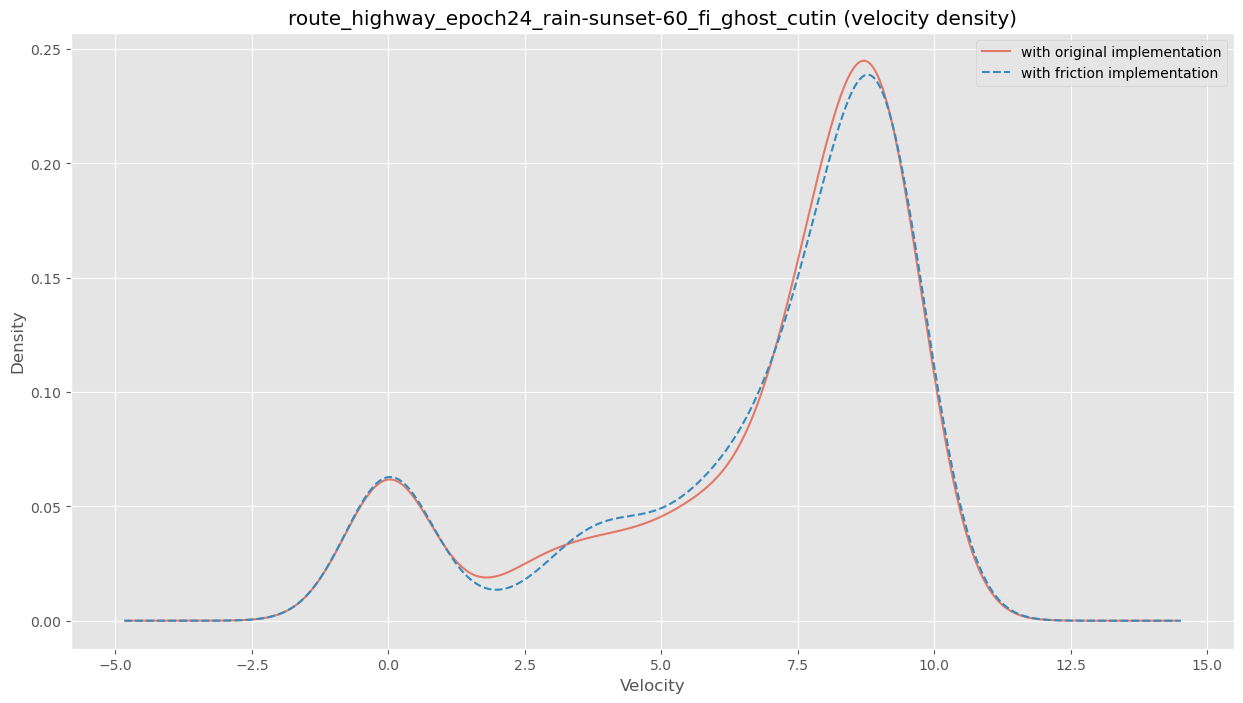

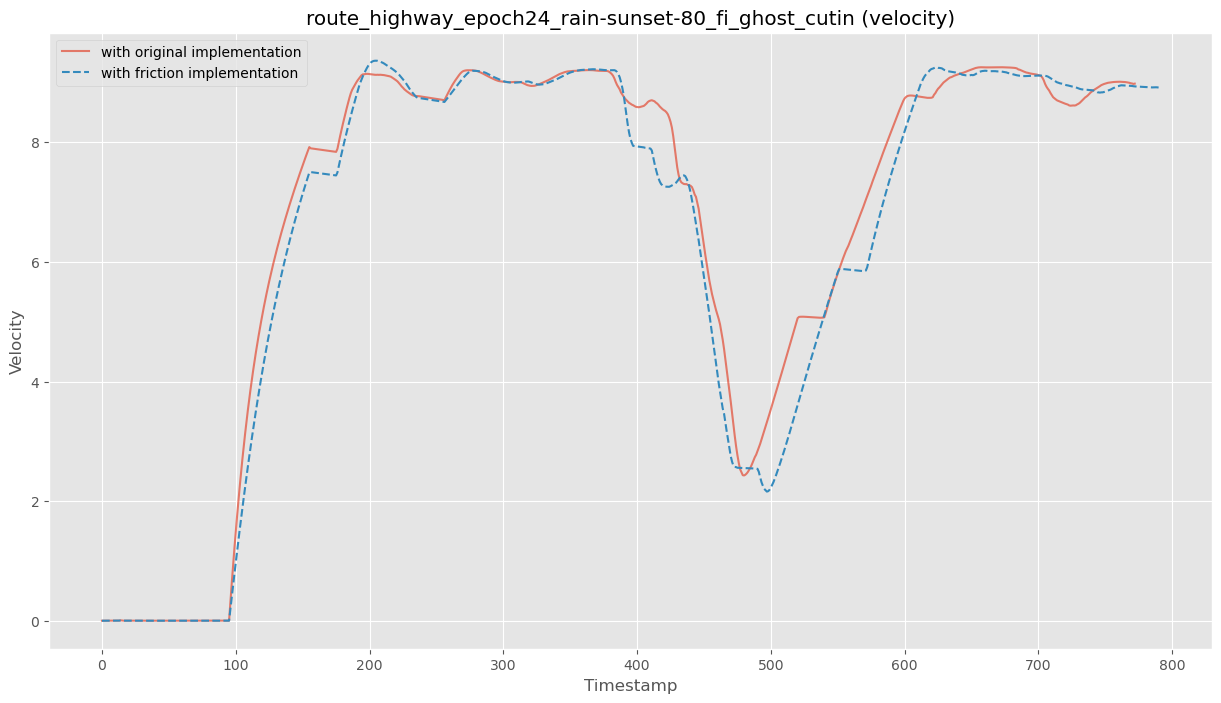

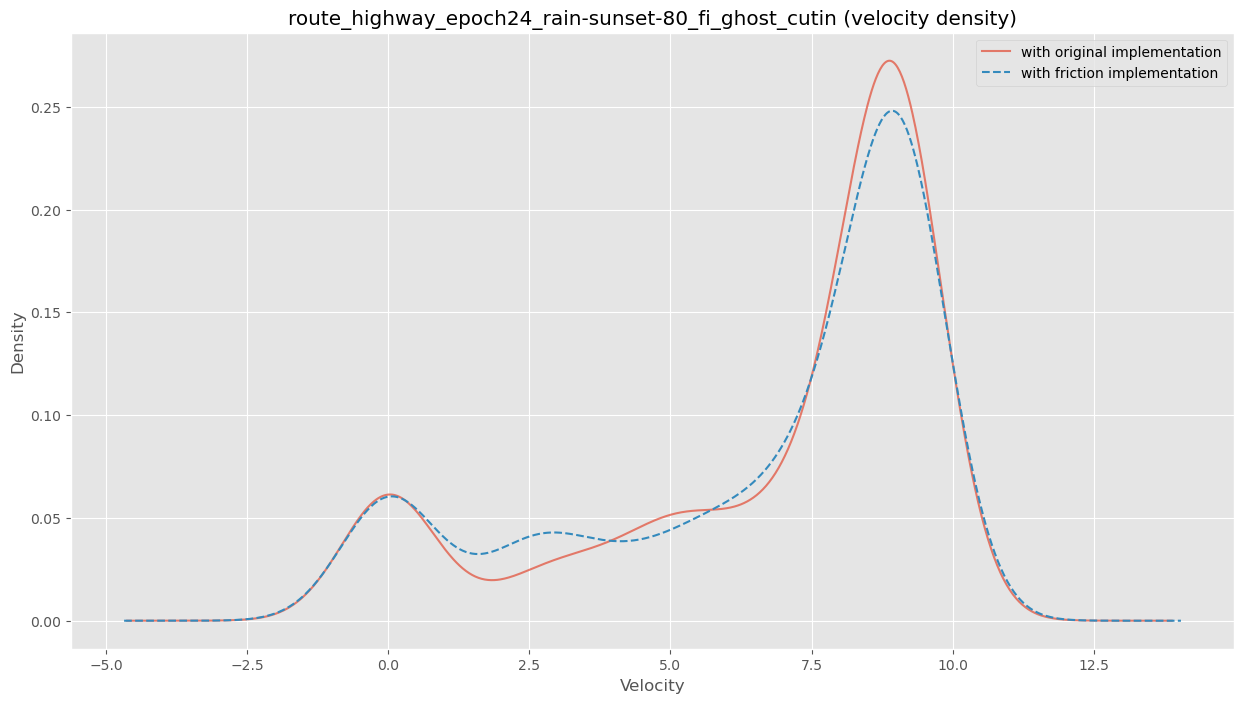

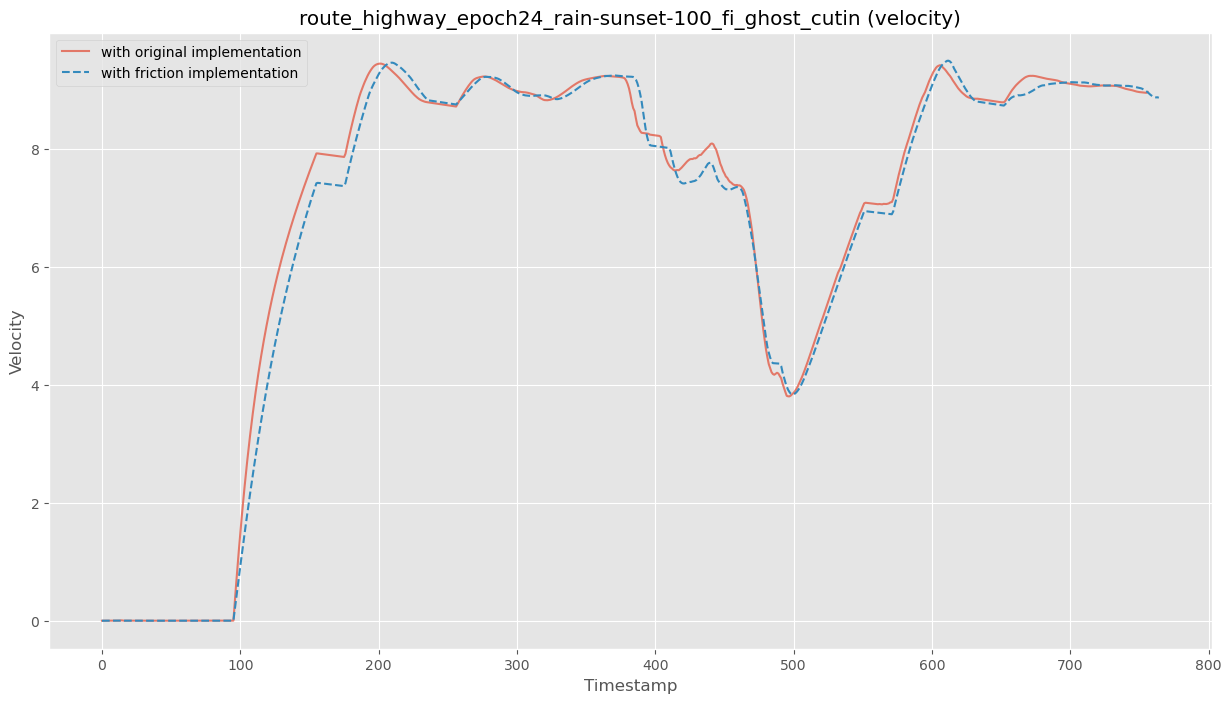

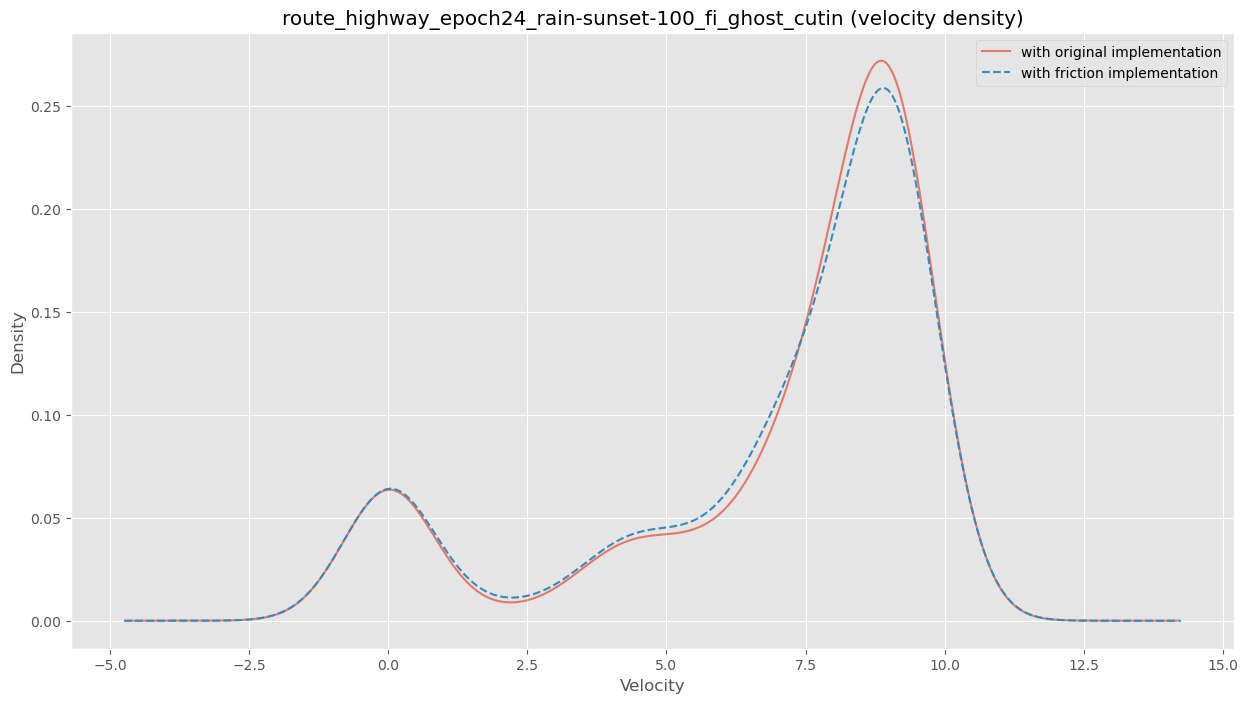

In [37]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_v = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['v'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['v'].isnull().values.any():
                df_orig_v["Run"+str(i)] = df_array_orig[weather][i]['v']

    median_orig_v = df_orig_v.median(axis=1)

    plt.plot(median_orig_v, alpha=0.7)


    df_fric_v = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['v'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['v'].isnull().values.any():
                df_fric_v["Run"+str(i)] = df_array_fric[weather][i]['v']

    median_fric_v = df_fric_v.median(axis=1)
    
    all_medians[weather][2][0] = median_orig_v
    all_medians[weather][2][1] = median_fric_v
    
    plt.plot(median_fric_v, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("Velocity")
    plt.title(subfolders[weather] + " (velocity)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("Velocity")
    plt.ylabel("Density")
    median_orig_v.plot.density(alpha=0.7)
    median_fric_v.plot.density(style='--')
    plt.title(subfolders[weather] + " (velocity density)")
    plt.legend(friction_legend)
    plt.show()
    

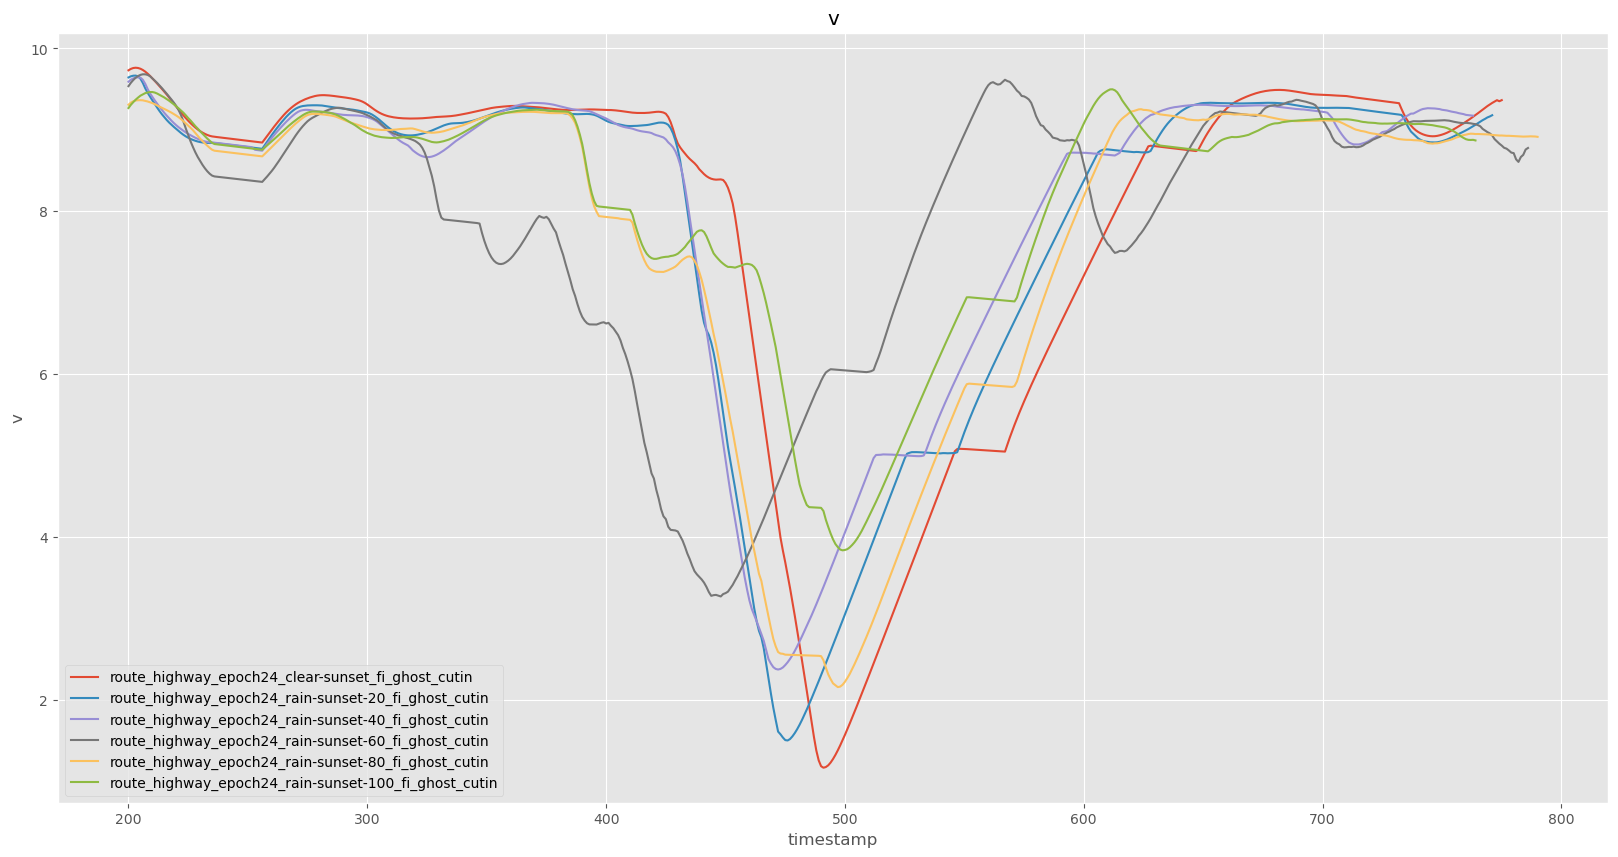

In [38]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_v = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['v'].dtypes == 'v'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['v'].isnull().values.any():
#                 df_orig_v["Run"+str(i)] = df_array_orig[weather][i]['v']

#     median_orig_v = df_orig_v.median(axis=1)


#     plt.plot(median_orig_v[200:], alpha=0.7)


    df_fric_v = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['v'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['v'].isnull().values.any() :
                df_fric_v["Run"+str(i)] = df_array_fric[weather][i]['v']

    median_fric_v = df_fric_v.median(axis=1)

    plt.plot(median_fric_v[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("v")
plt.title("v")
plt.legend(full_legend)
plt.show()

### cvip

0      500.497261
1        5.598742
2        5.595580
3        5.592744
4        5.590235
          ...    
771     52.339274
772     52.437197
773     52.534660
774     53.079631
775     53.205316
Length: 776, dtype: float64


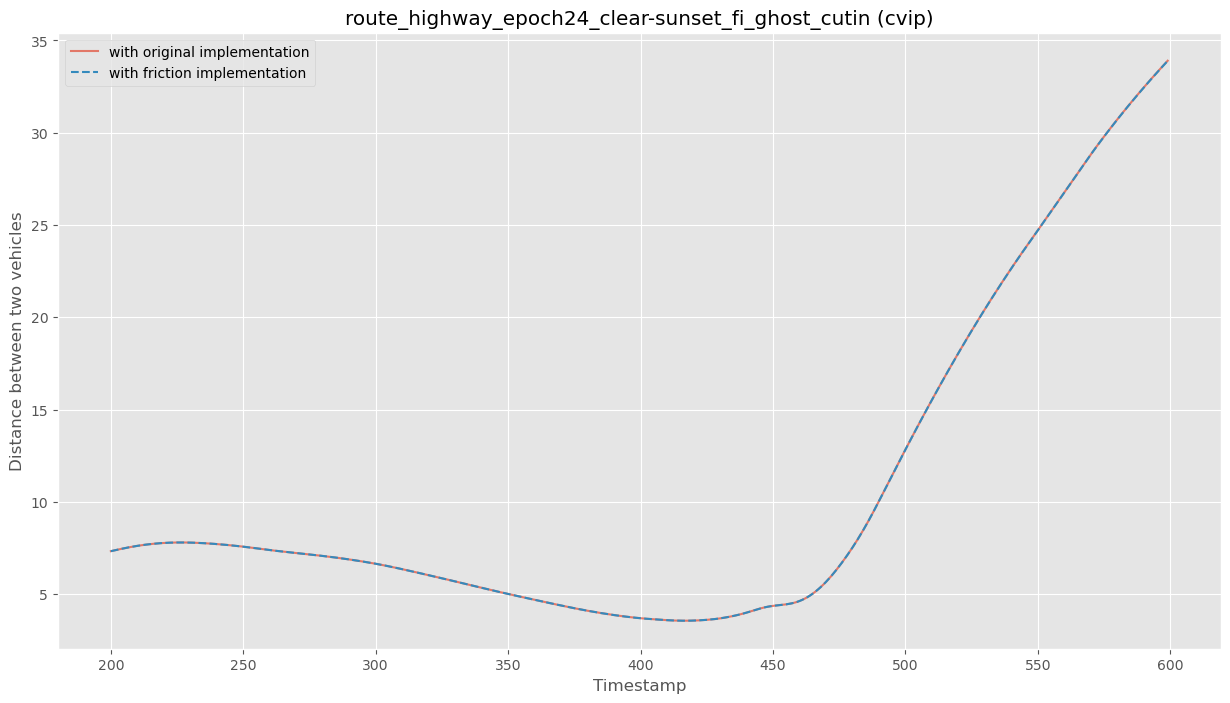

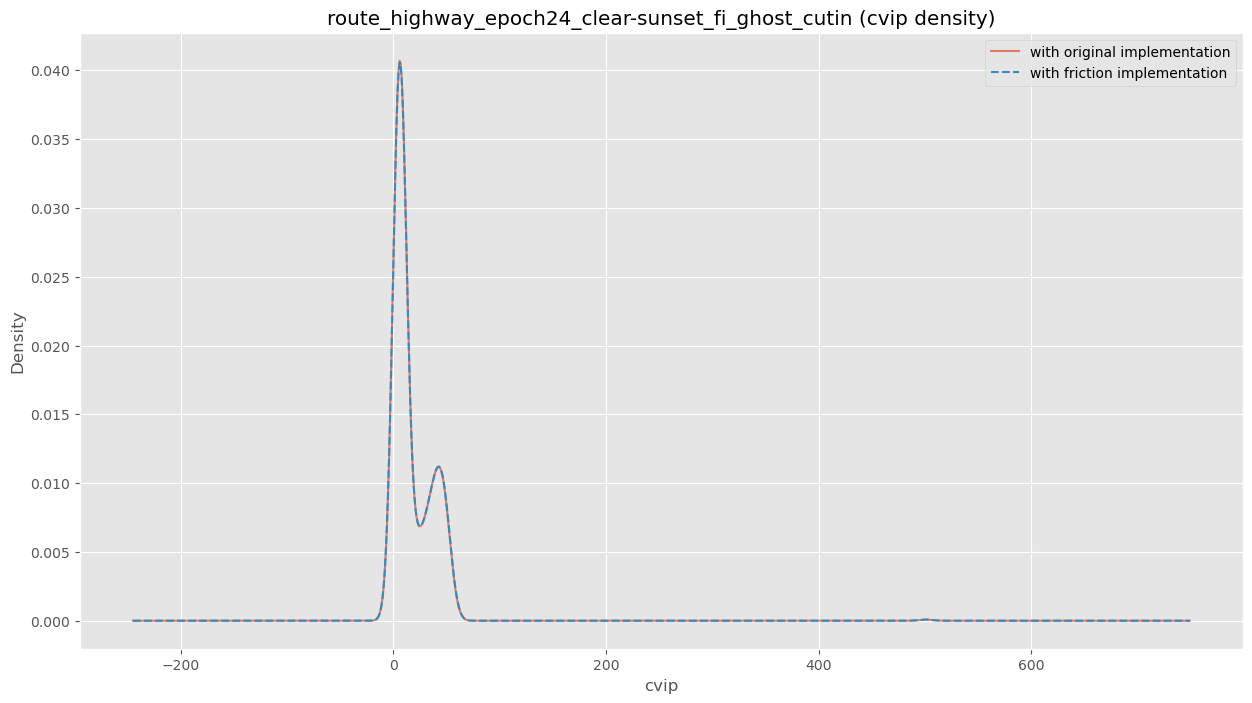

0      500.497261
1        5.598742
2        5.595580
3        5.592744
4        5.590235
          ...    
767     52.040368
768     52.171054
769     52.304308
770     52.501299
771     52.631457
Length: 772, dtype: float64


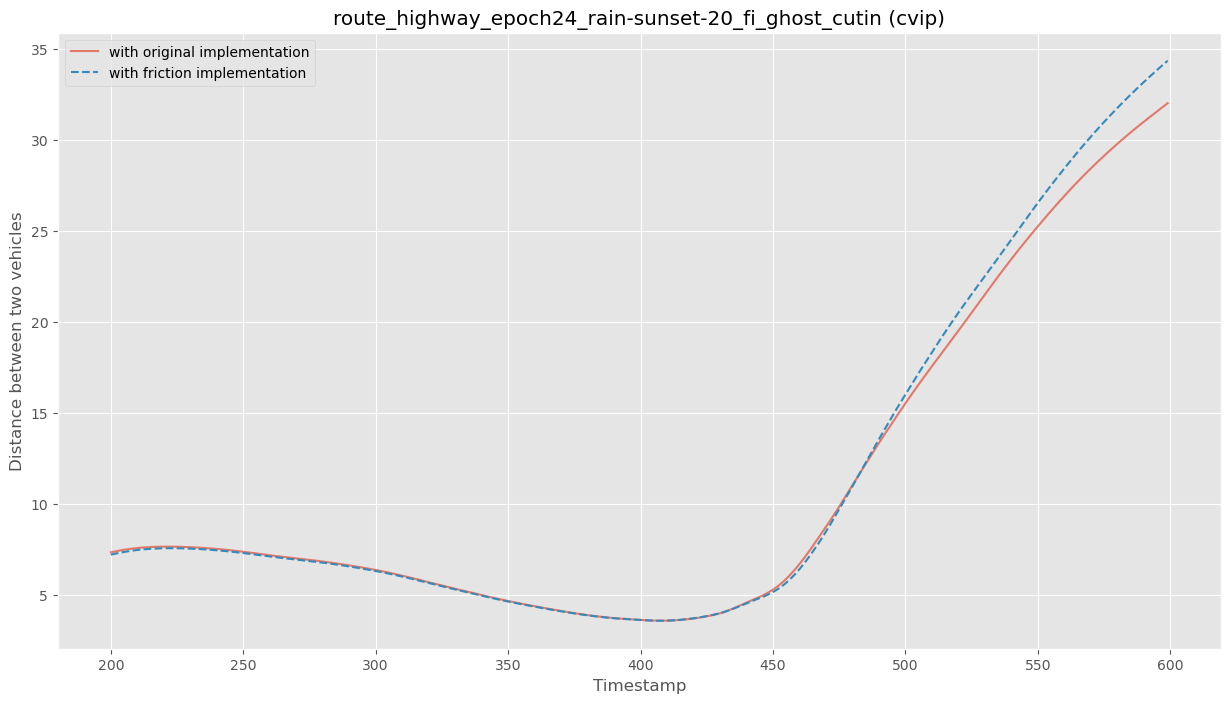

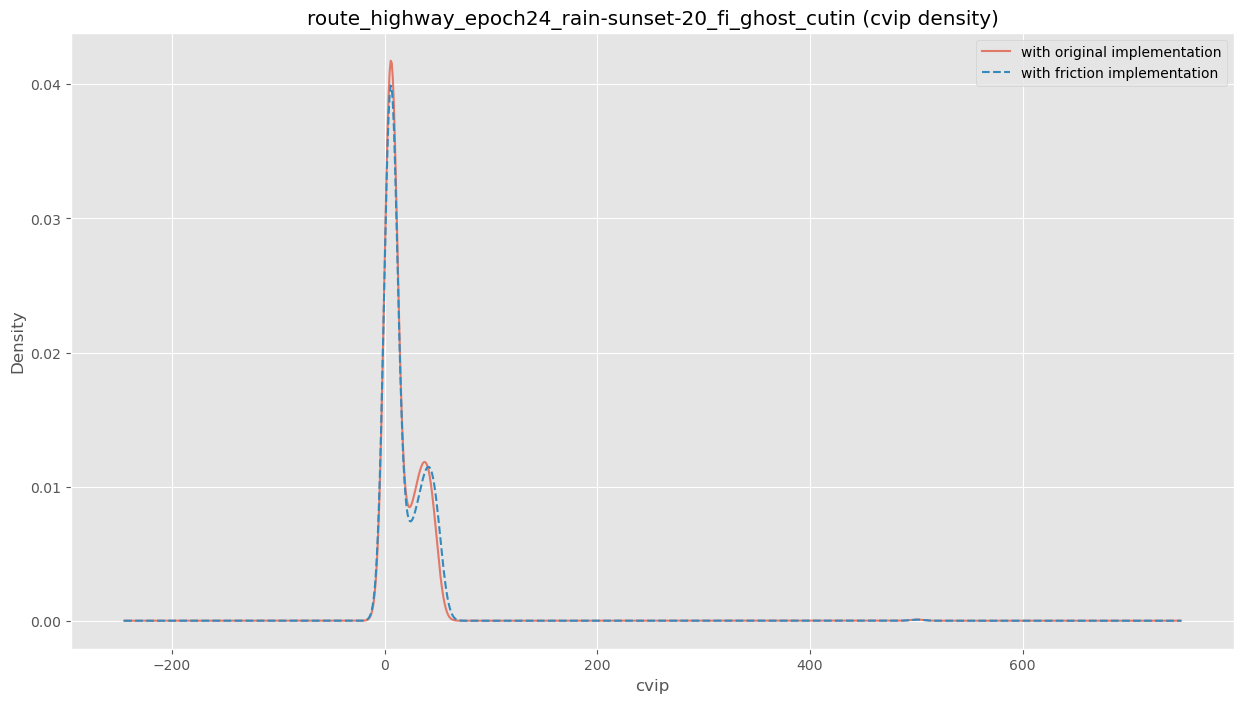

0      500.497261
1        5.598742
2        5.595580
3        5.592744
4        5.590235
          ...    
759     49.042439
760     49.173767
761     49.309259
762     49.424934
763     49.540572
Length: 764, dtype: float64


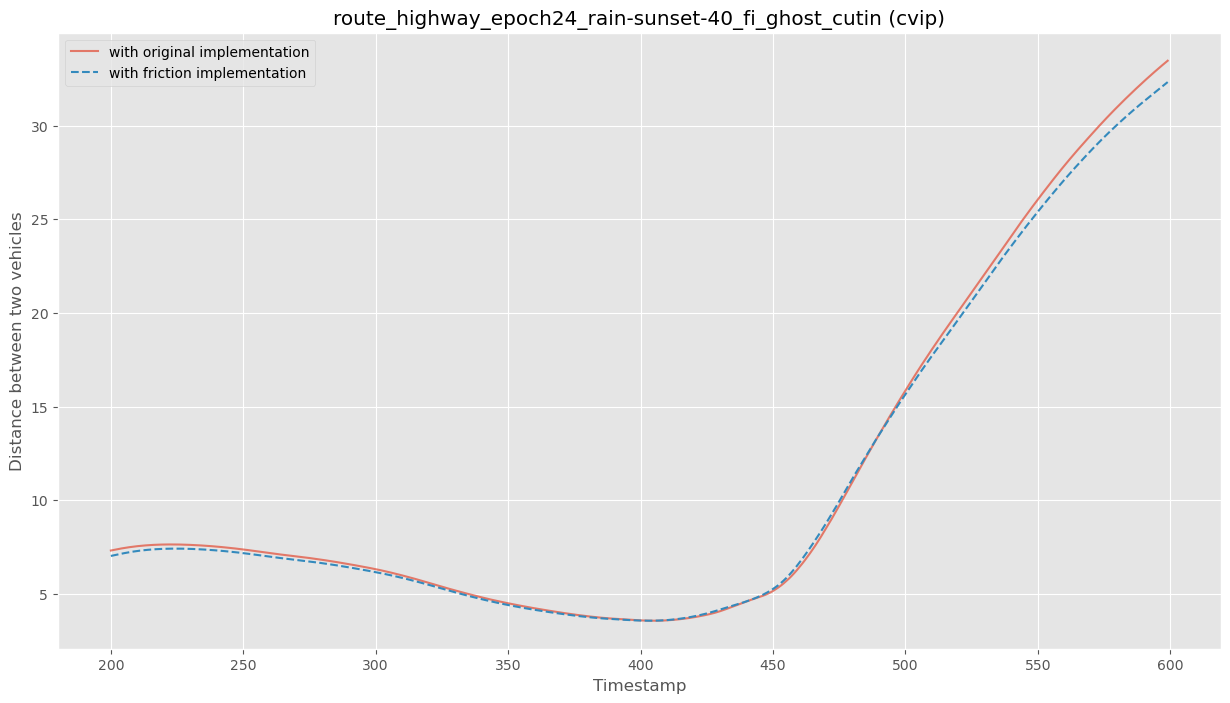

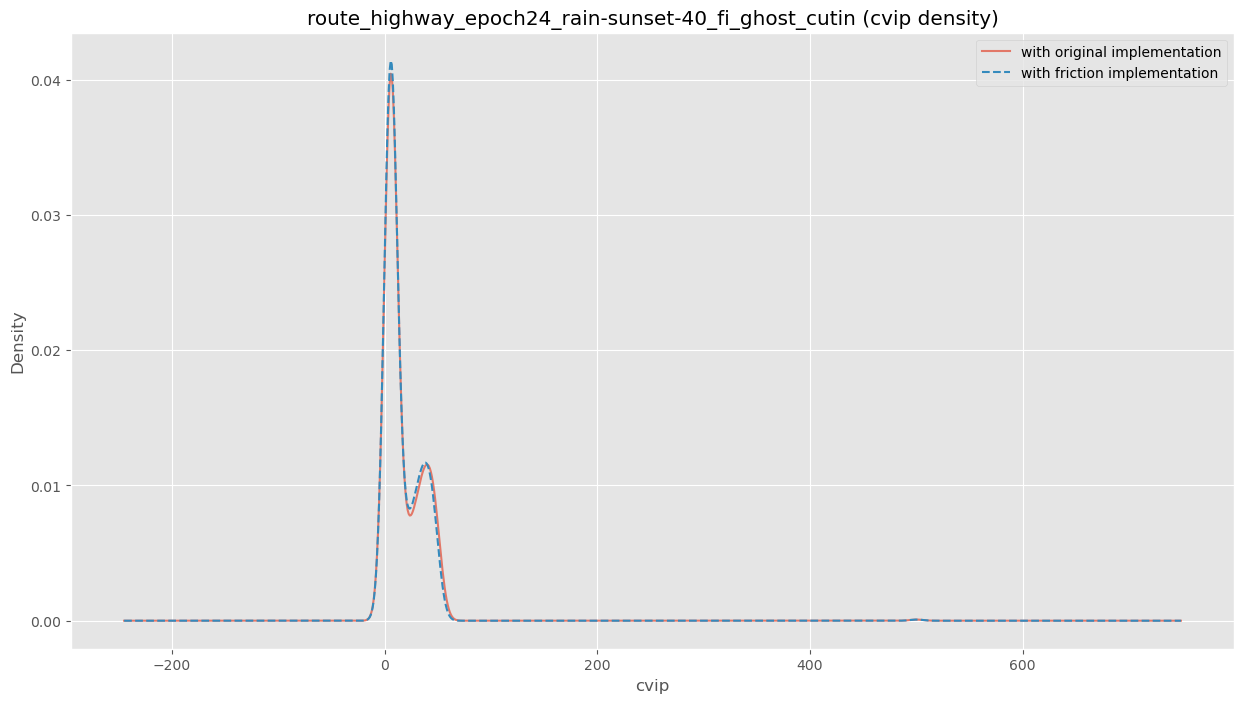

0      500.497261
1        5.598742
2        5.595580
3        5.592744
4        5.590235
          ...    
782     55.087089
783     55.371130
784     55.612430
785     56.037511
786     56.184233
Length: 787, dtype: float64


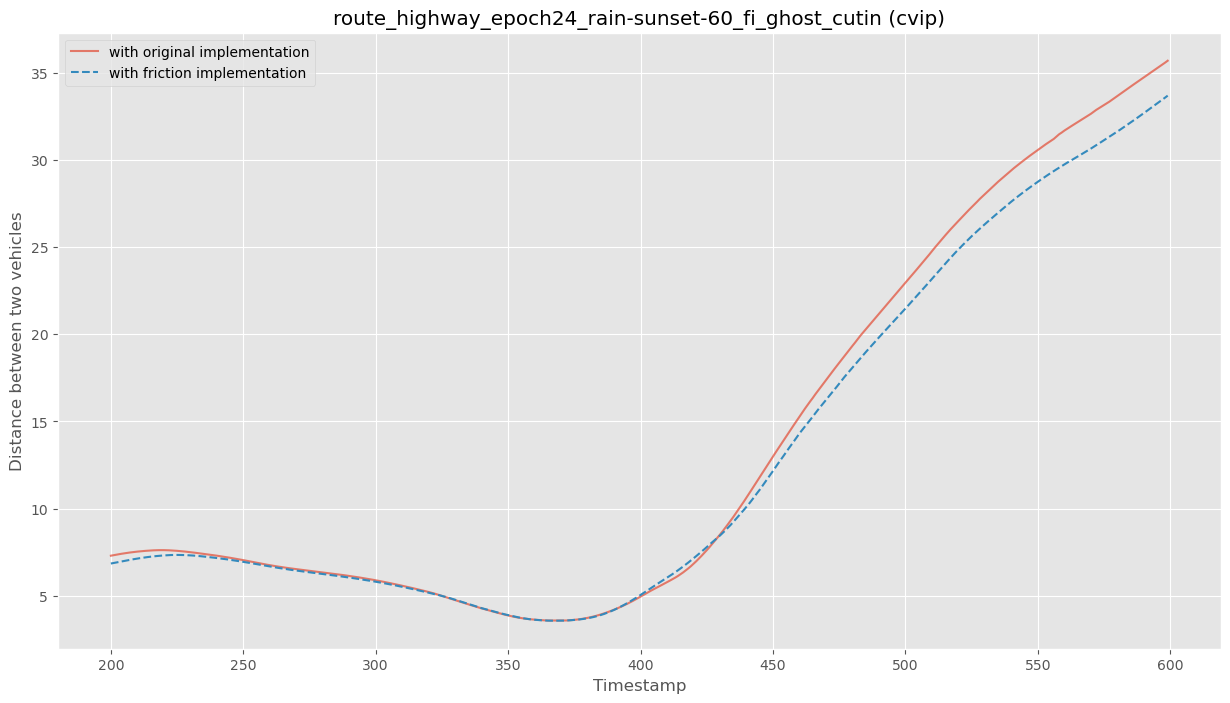

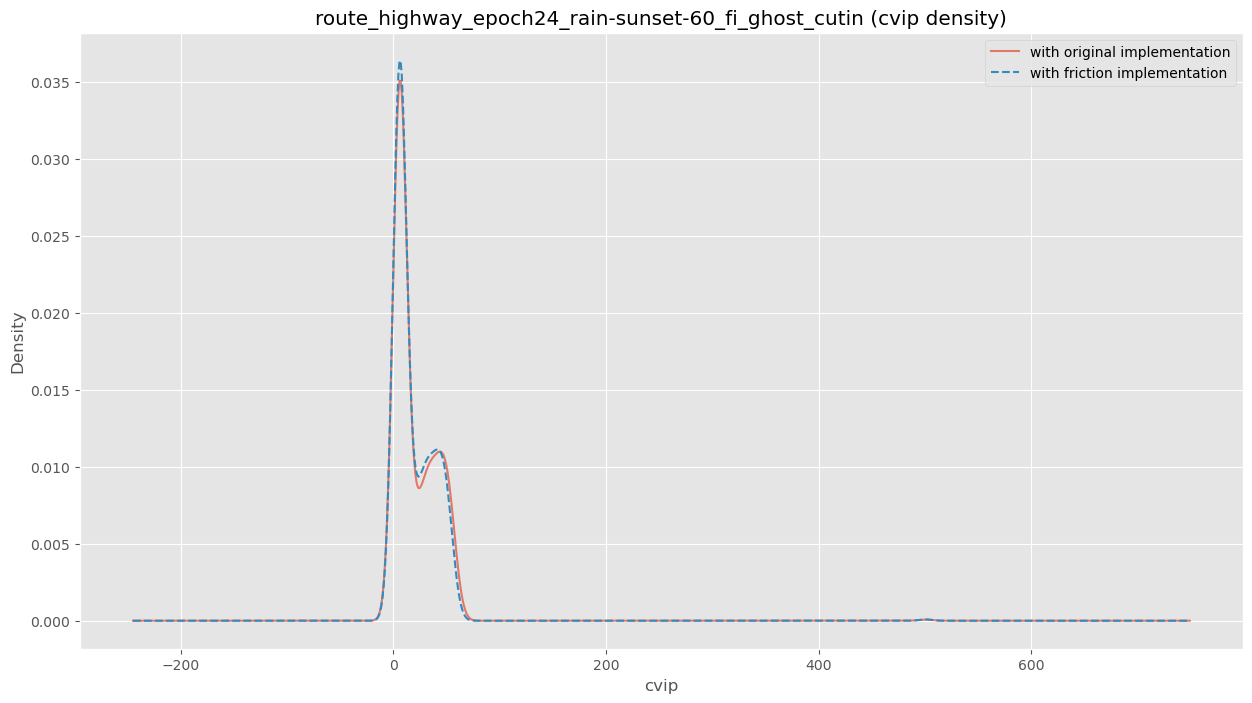

0      500.497261
1        5.598742
2        5.595580
3        5.592744
4        5.590235
          ...    
786     54.396482
787     54.522182
788     54.666710
789     54.842597
790     54.956212
Length: 791, dtype: float64


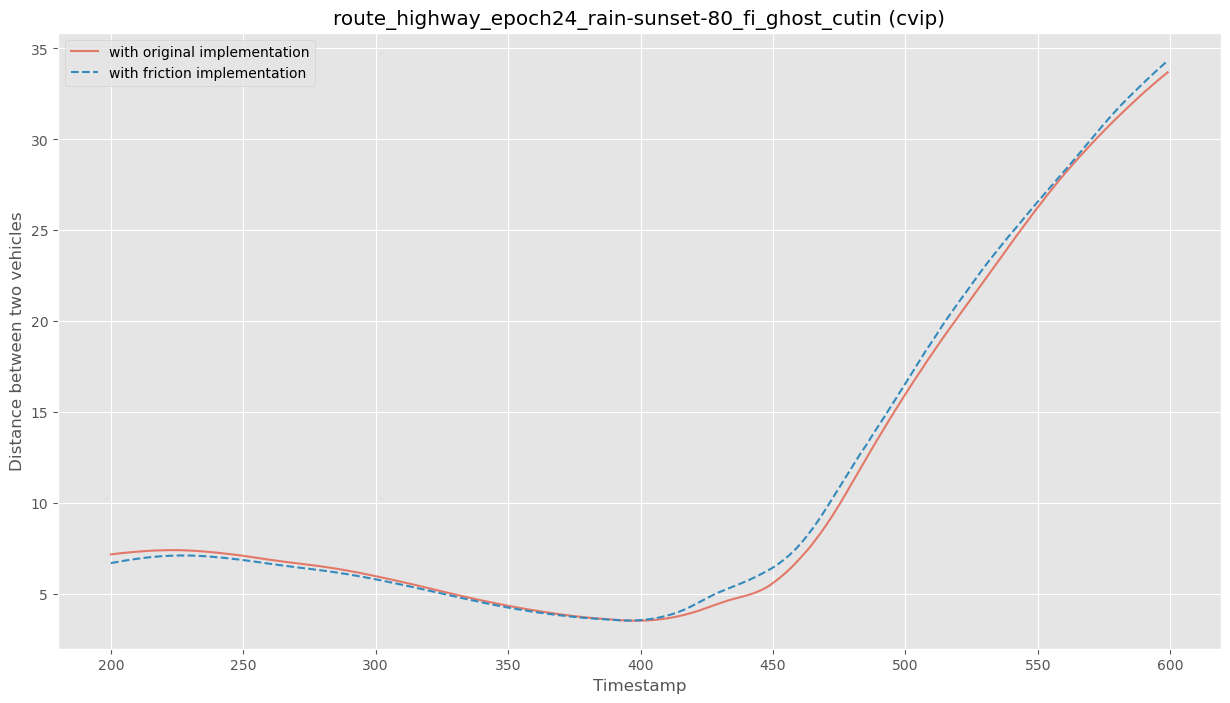

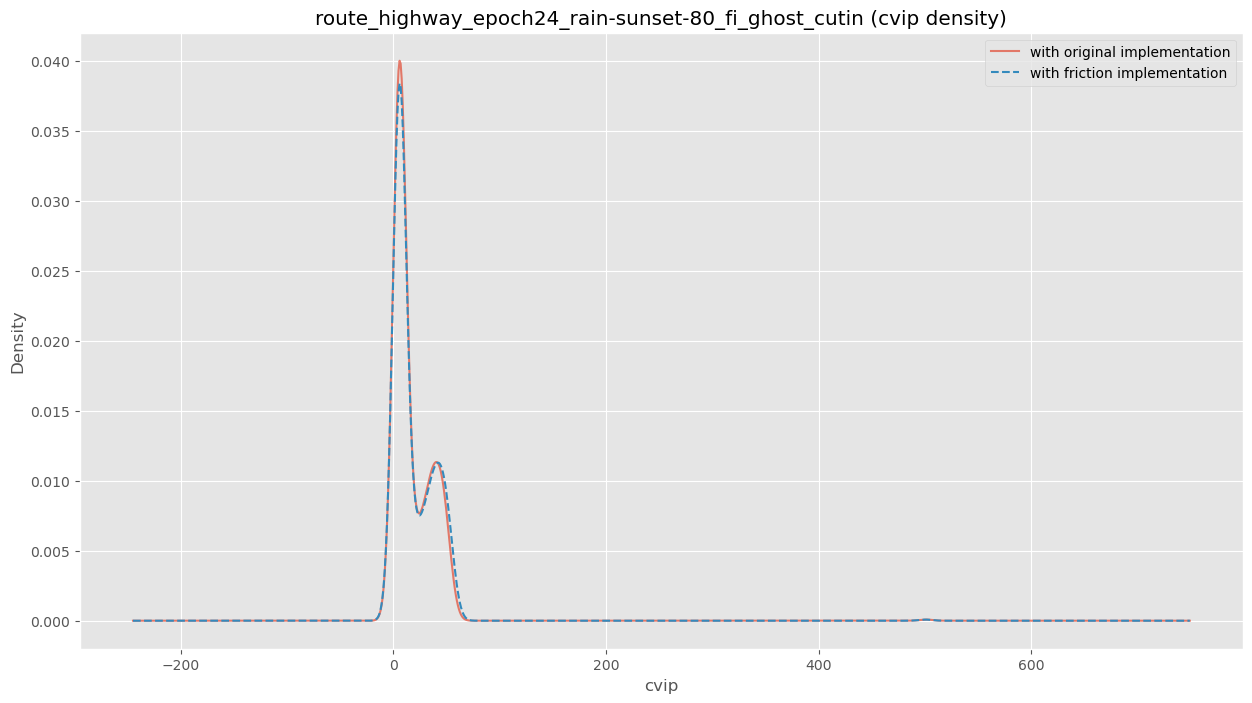

0      500.497261
1        5.598742
2        5.595580
3        5.592744
4        5.590235
          ...    
760     22.455094
761     22.524229
762     22.636413
763     22.876583
764     23.129910
Length: 765, dtype: float64


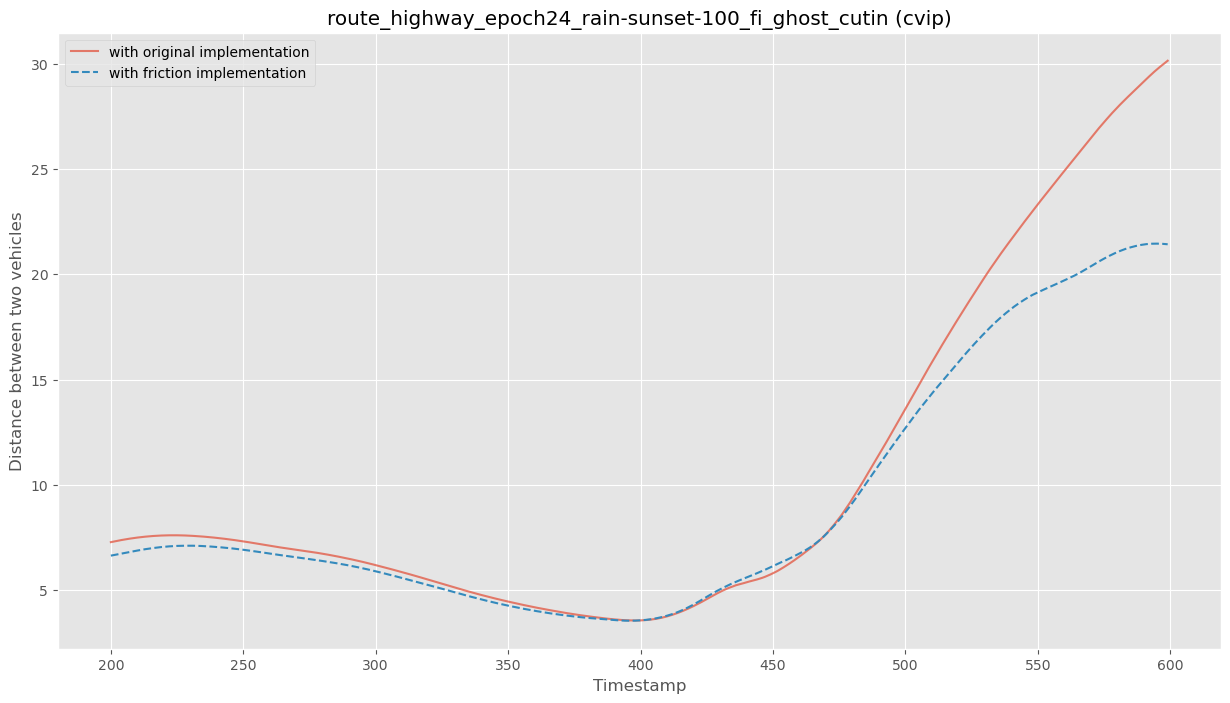

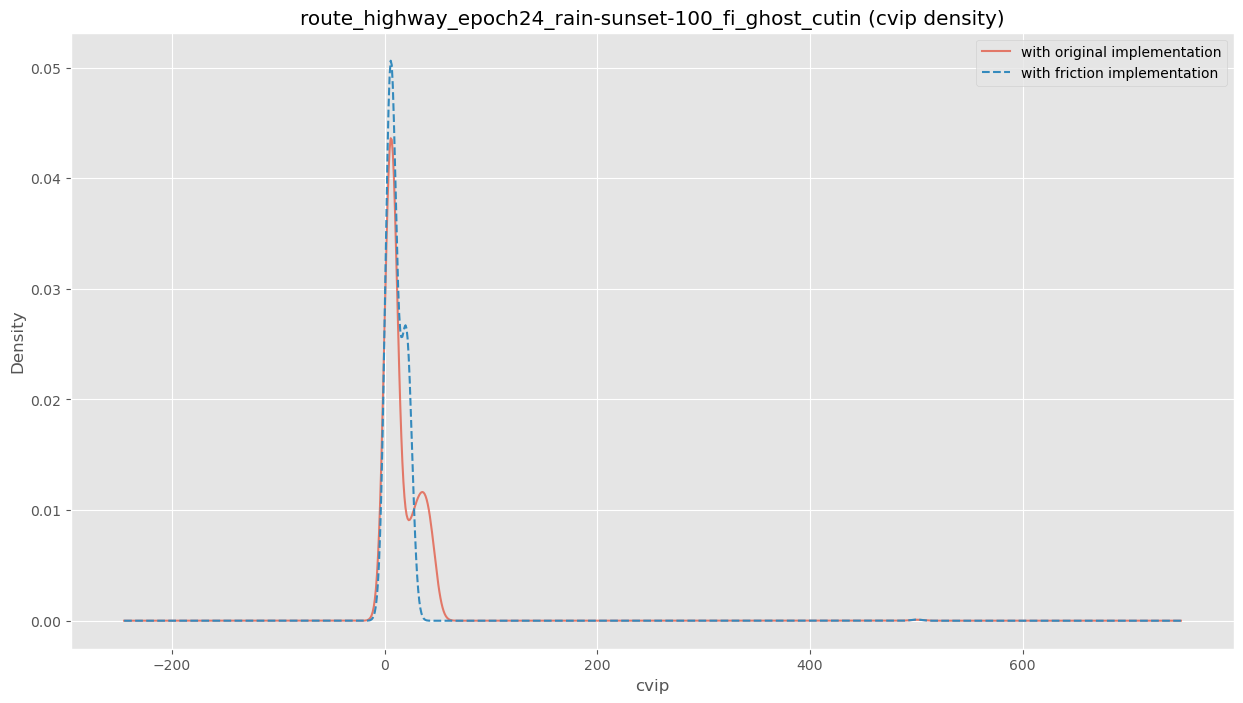

In [39]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_cvip = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['cvip'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['cvip'].isnull().values.any():
                df_orig_cvip["Run"+str(i)] = df_array_orig[weather][i]['cvip']

    median_orig_cvip = df_orig_cvip.median(axis=1)

    plt.plot(median_orig_cvip.iloc[200:600], alpha=0.7)


    df_fric_cvip = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['cvip'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['cvip'].isnull().values.any():
                df_fric_cvip["Run"+str(i)] = df_array_fric[weather][i]['cvip']

    median_fric_cvip = df_fric_cvip.median(axis=1)
    
    print(median_fric_cvip)
    
    all_medians[weather][3][0] = median_orig_cvip
    all_medians[weather][3][1] = median_fric_cvip
    
    plt.plot(median_fric_cvip.iloc[200:600], '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("Distance between two vehicles")
    plt.title(subfolders[weather] + " (cvip)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("cvip")
    plt.ylabel("Density")
    median_orig_cvip.plot.density(alpha=0.7)
    median_fric_cvip.plot.density(style='--')
    plt.title(subfolders[weather] + " (cvip density)")
    plt.legend(friction_legend)
    plt.show()

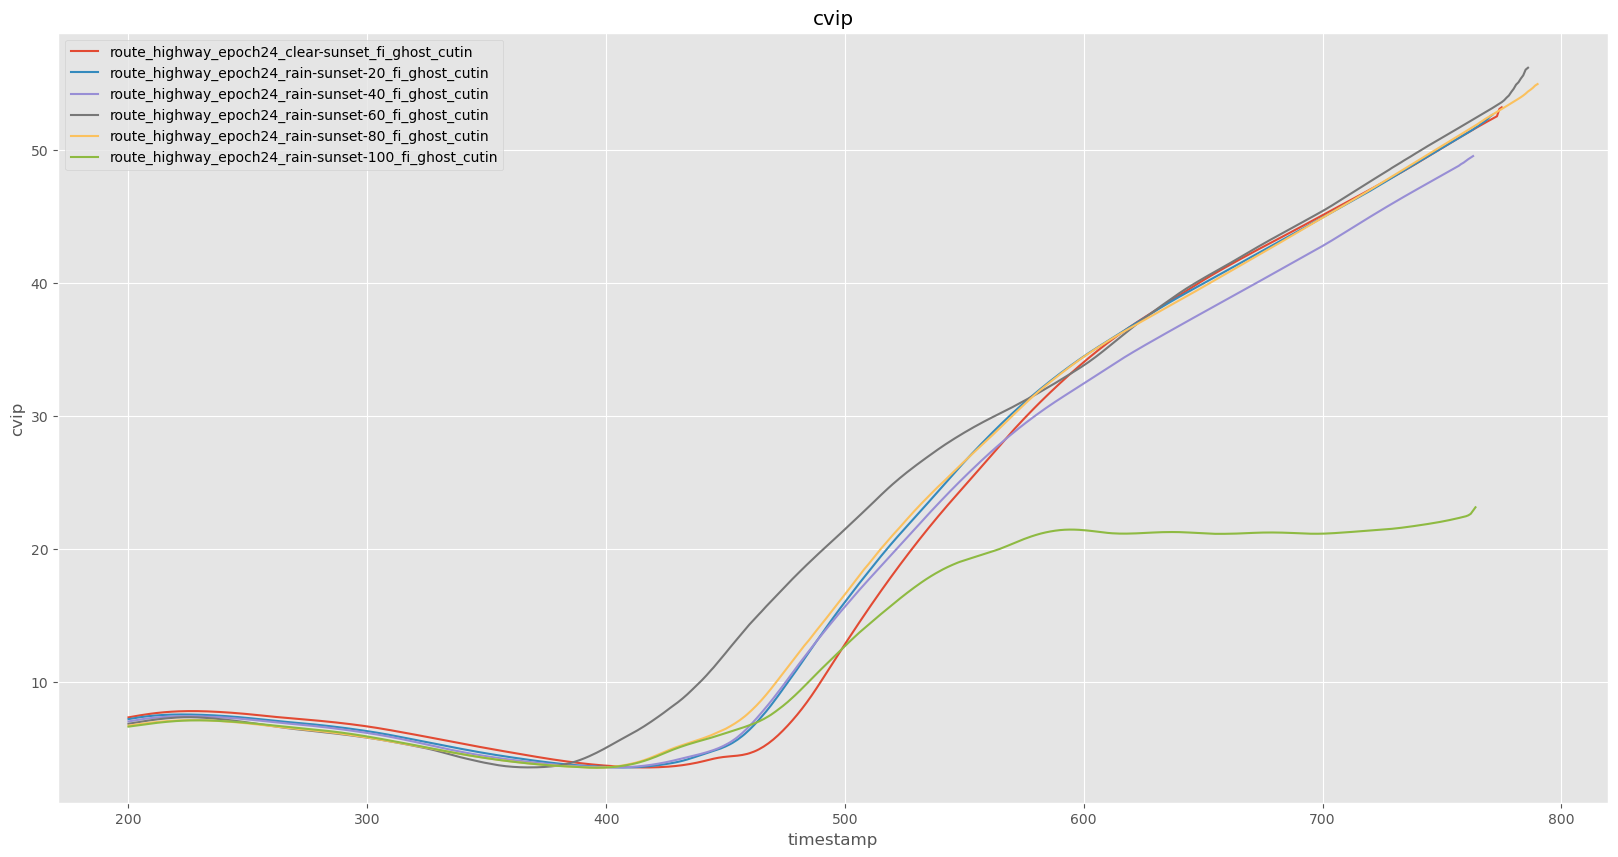

In [40]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_cvip = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['cvip'].dtypes == 'object'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['cvip'].isnull().values.any():
#                 df_orig_cvip["Run"+str(i)] = df_array_orig[weather][i]['cvip']

#     median_orig_cvip = df_orig_cvip.median(axis=1)


#     plt.plot(median_orig_cvip[200:], alpha=0.7)


    df_fric_cvip = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['cvip'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['cvip'].isnull().values.any() :
                df_fric_cvip["Run"+str(i)] = df_array_fric[weather][i]['cvip']

    median_fric_cvip = df_fric_cvip.median(axis=1)

    plt.plot(median_fric_cvip[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("cvip")
plt.title("cvip")
plt.legend(full_legend)
plt.show()

### steer

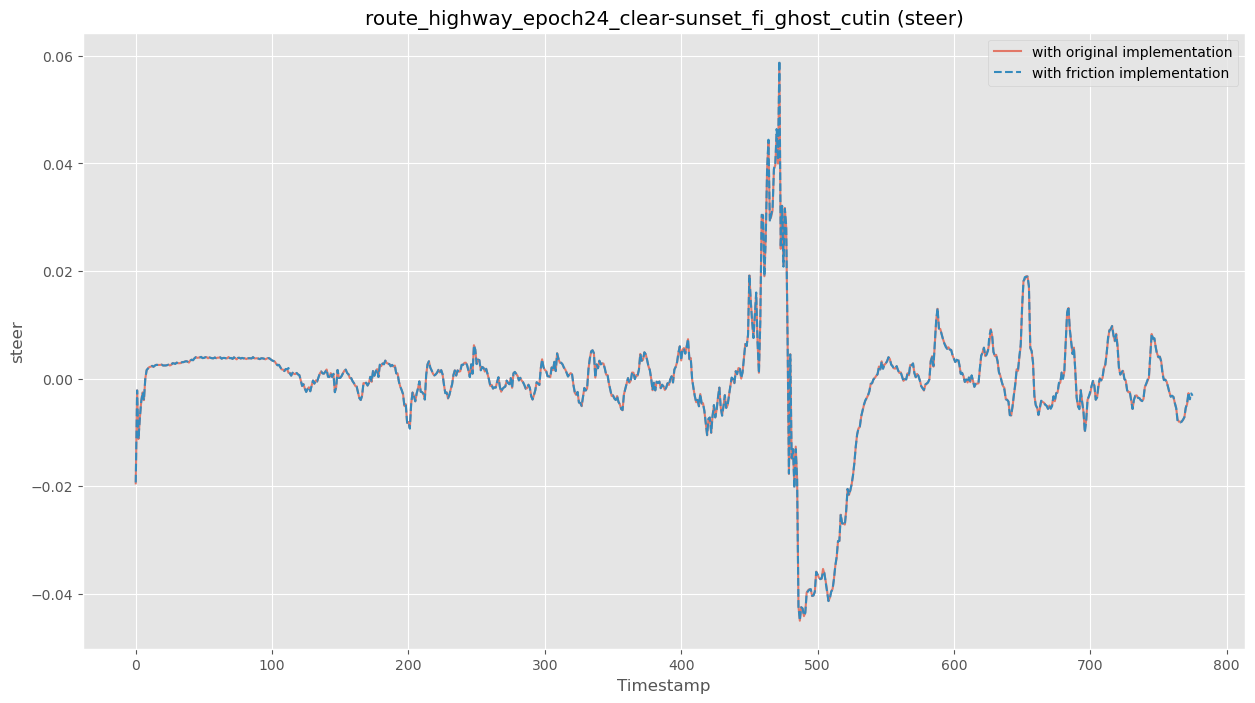

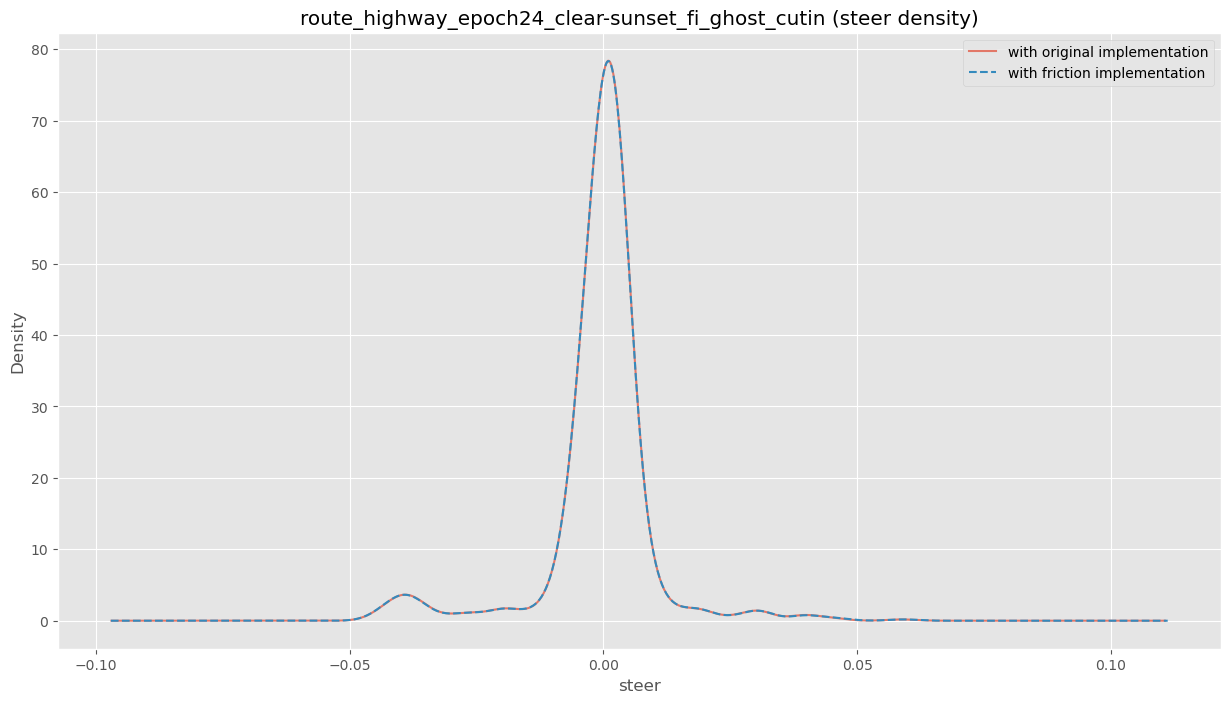

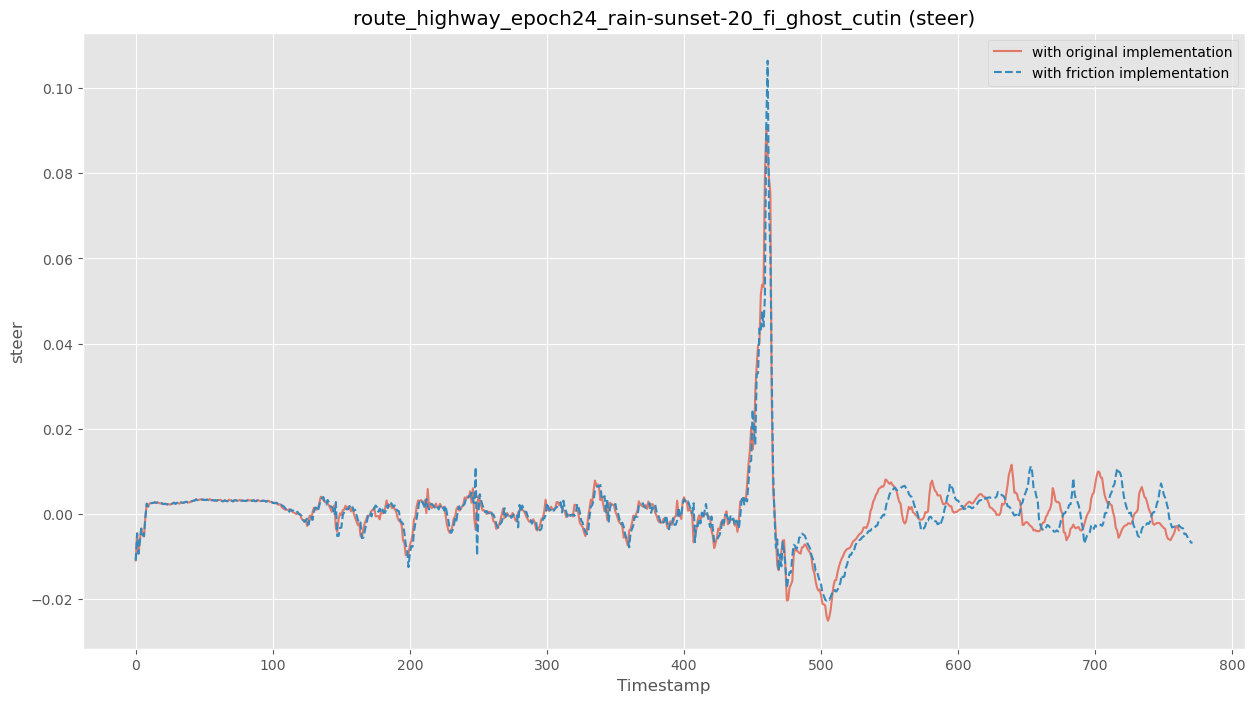

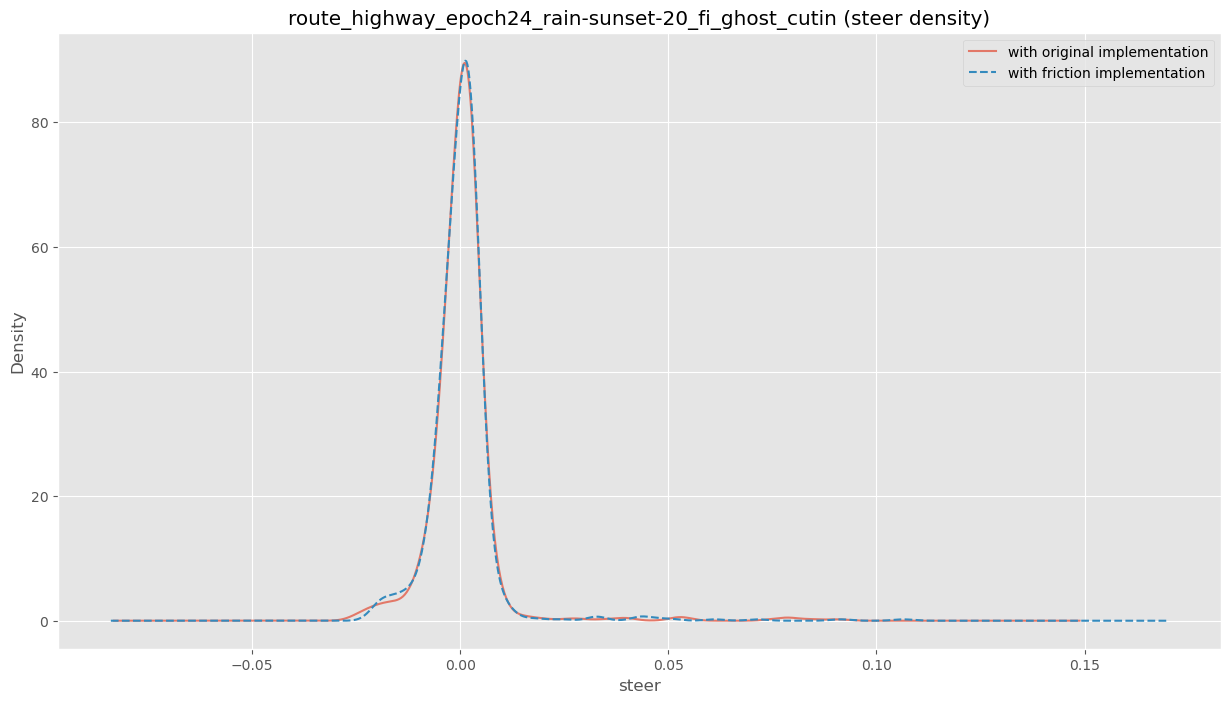

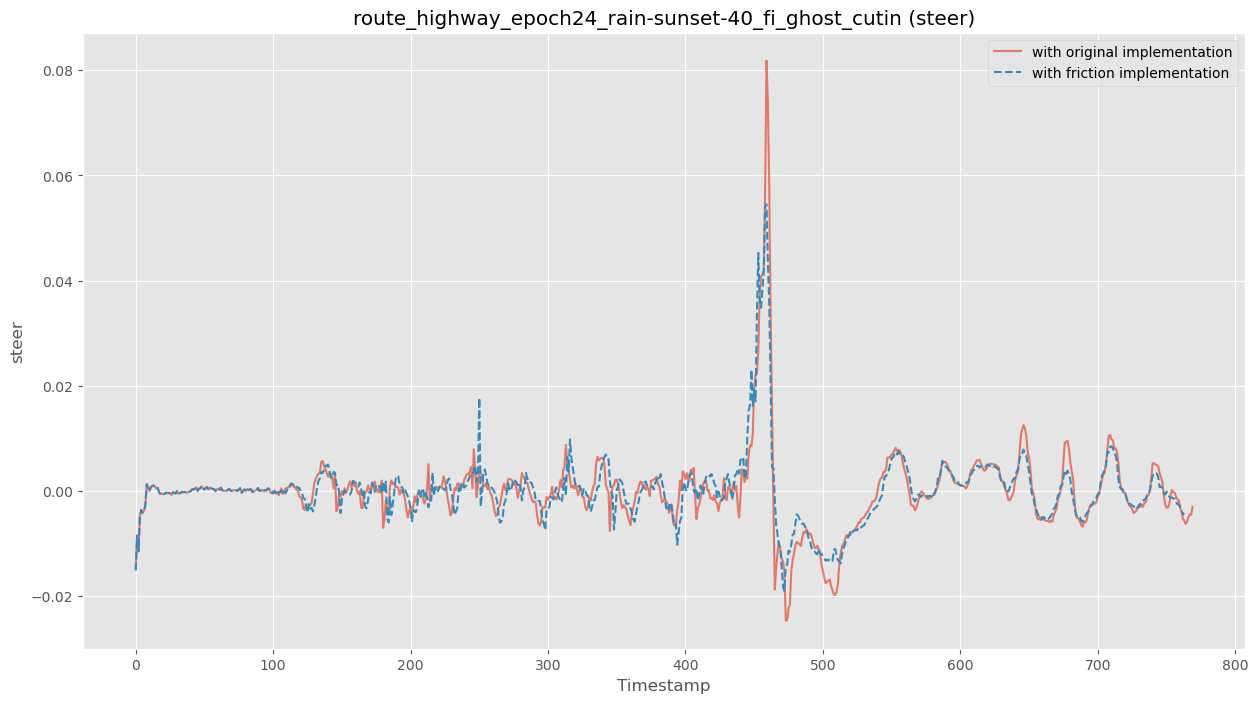

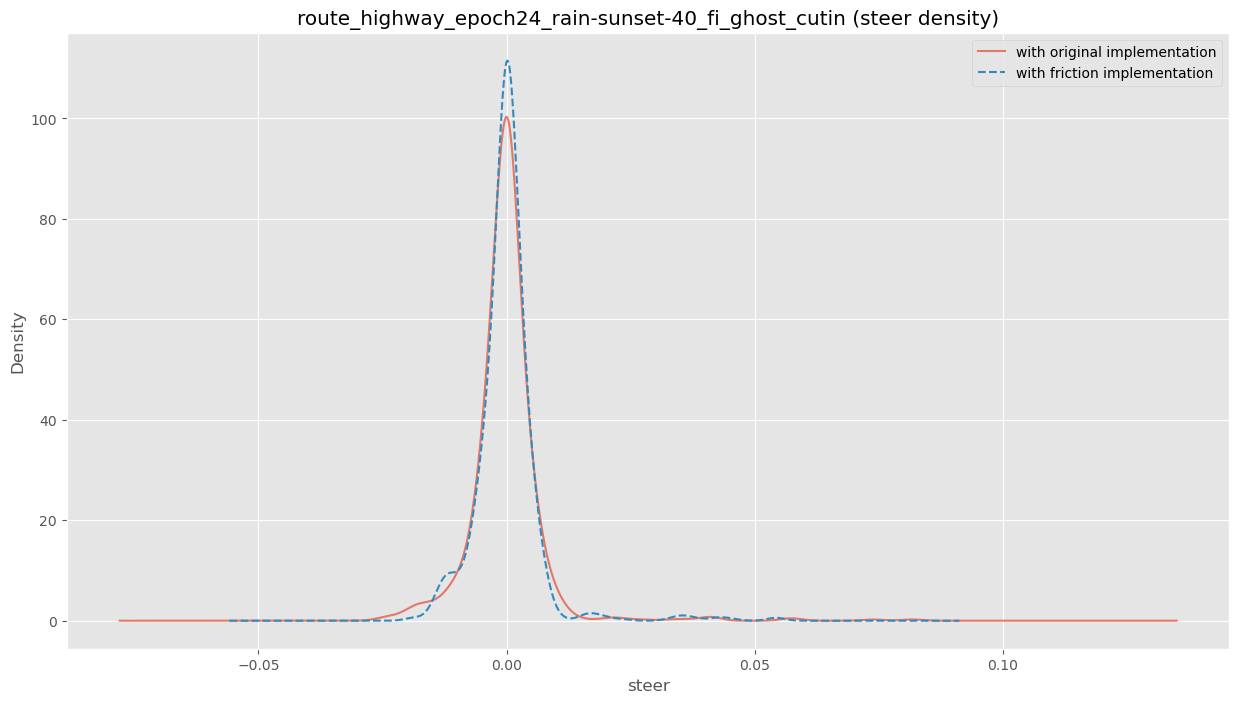

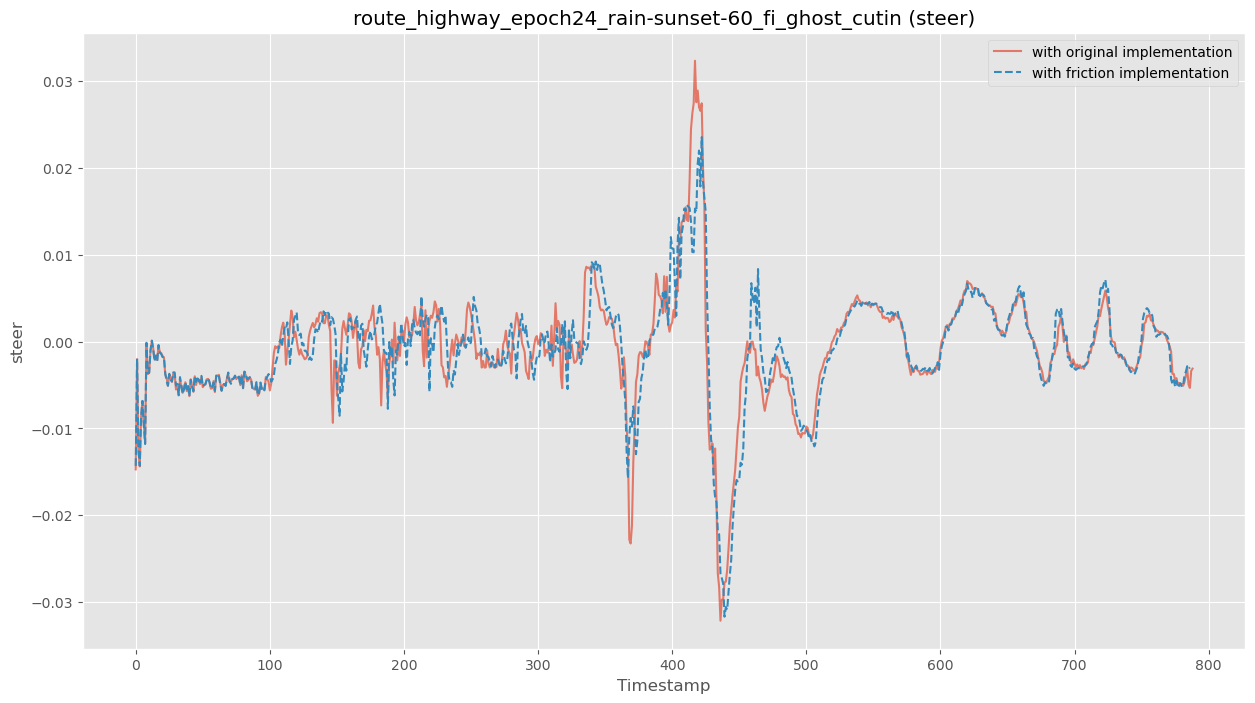

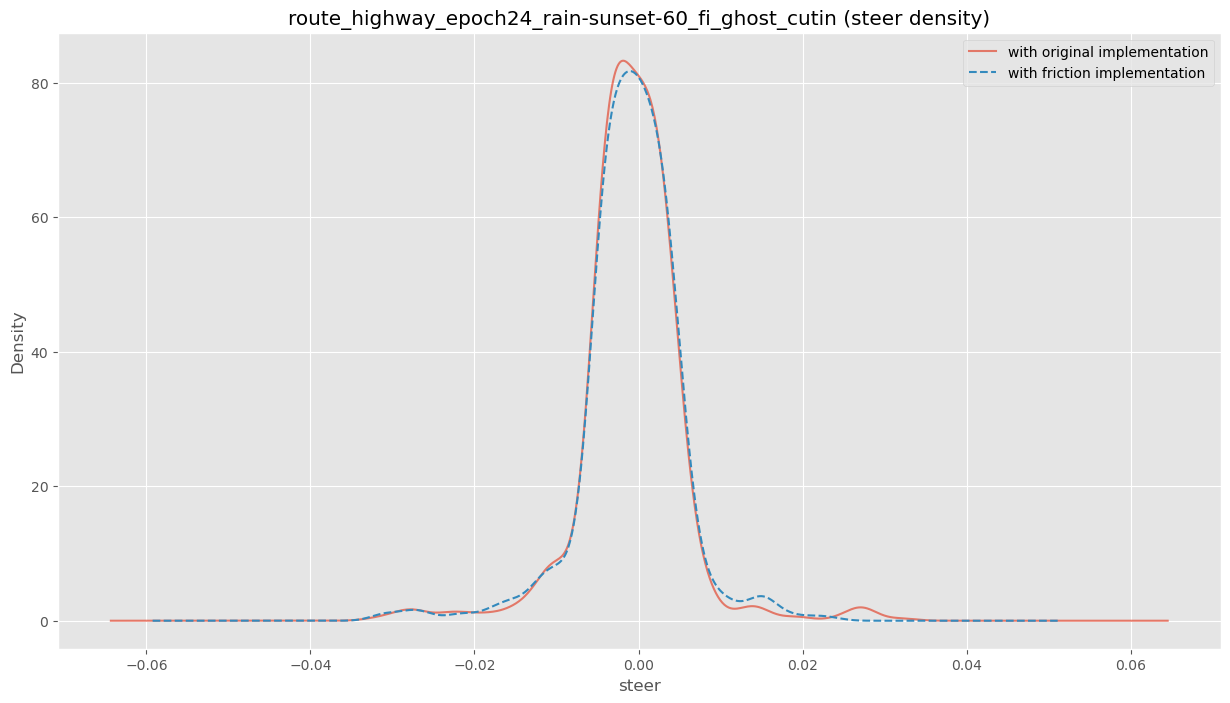

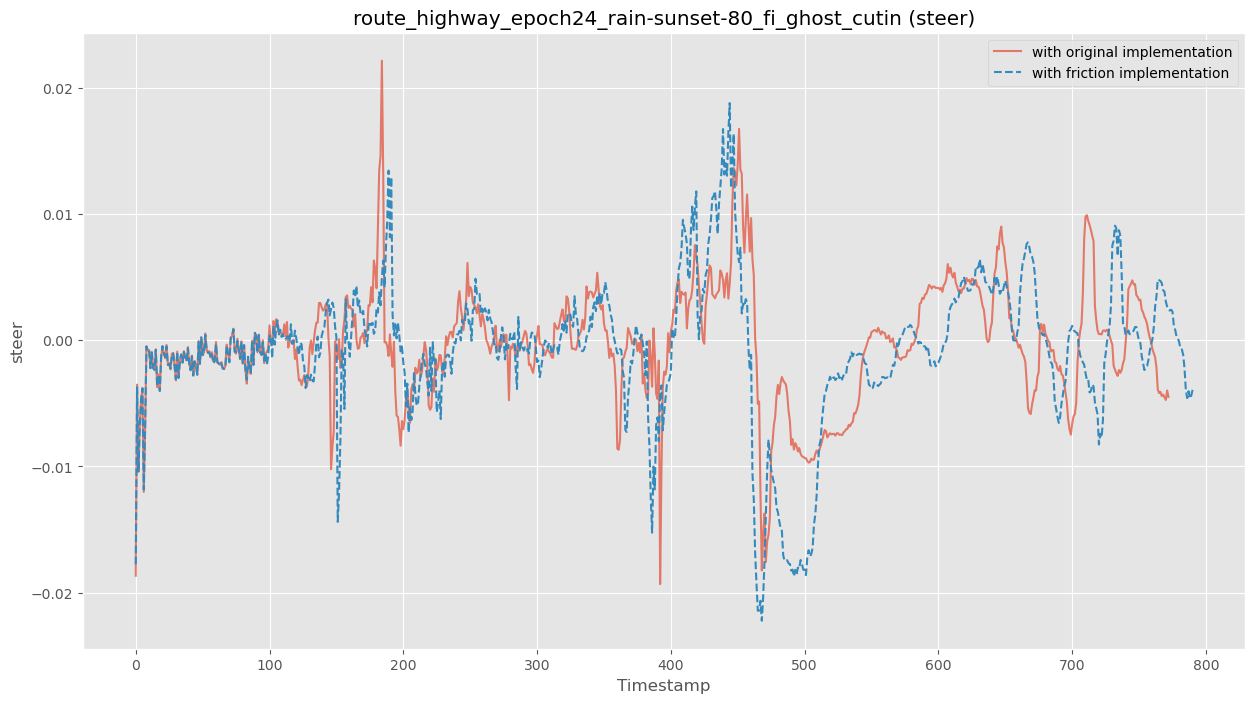

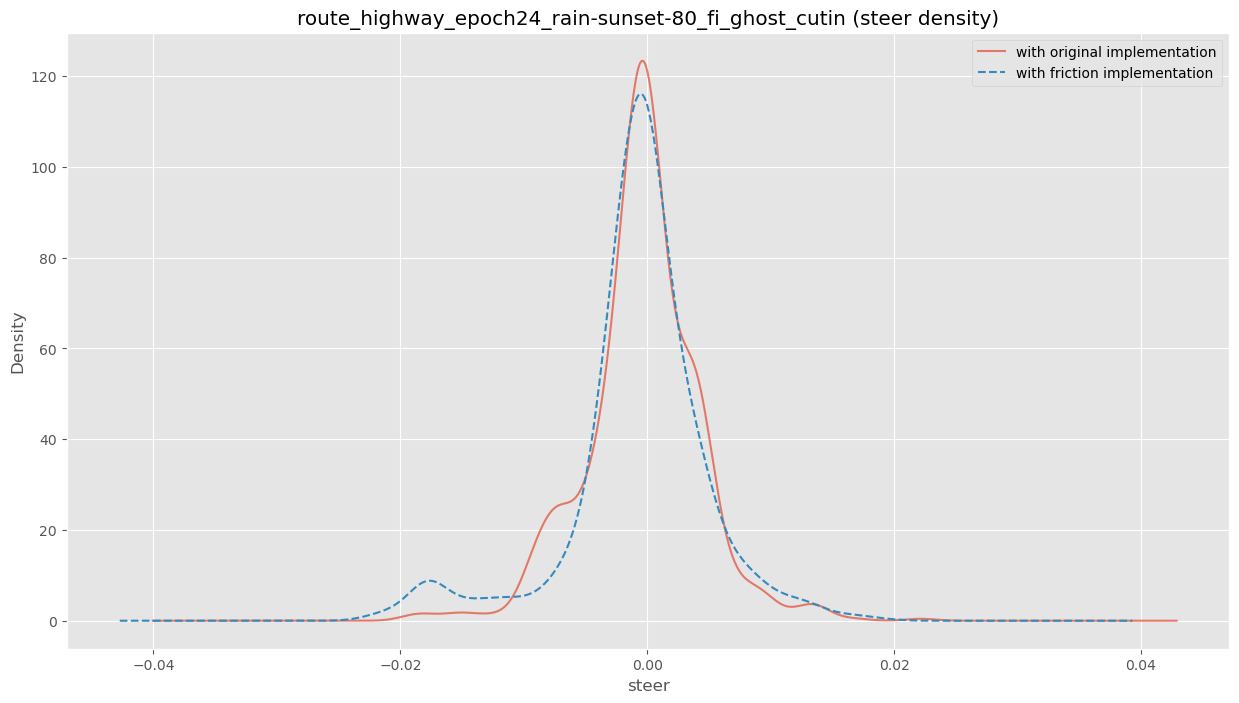

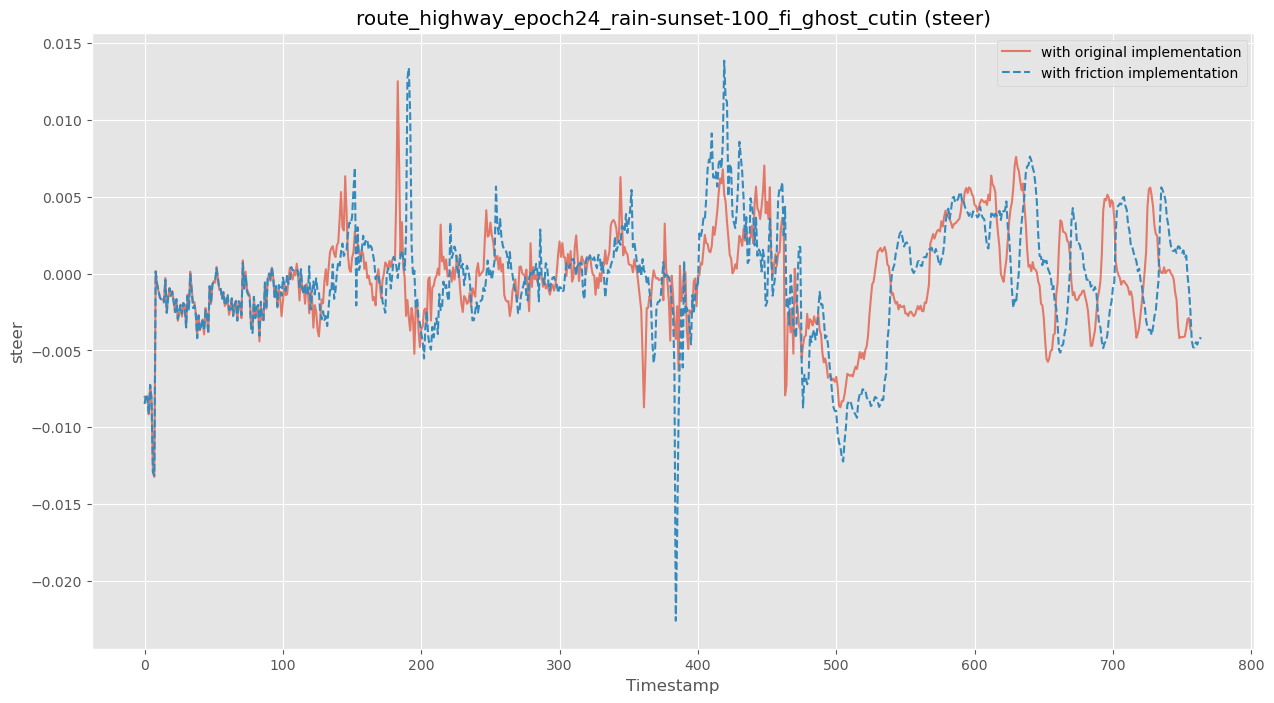

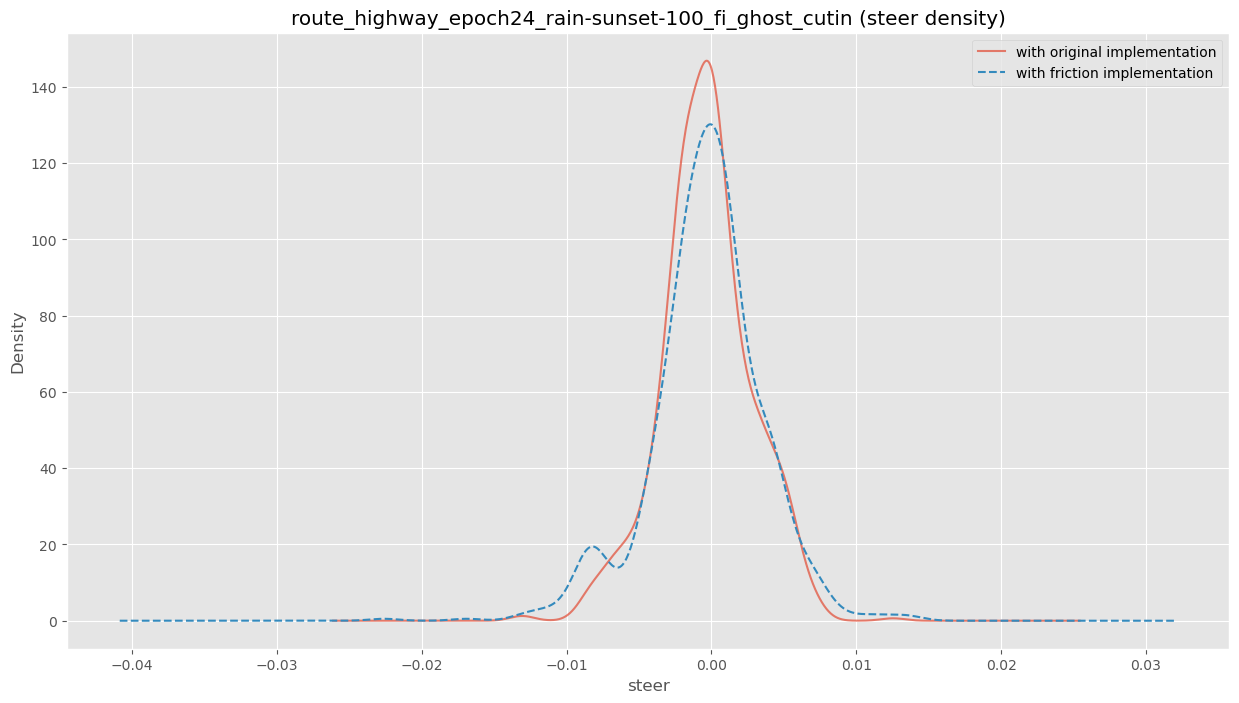

In [41]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_steer = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['steer'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['steer'].isnull().values.any():
                df_orig_steer["Run"+str(i)] = df_array_orig[weather][i]['steer']

    median_orig_steer = df_orig_steer.median(axis=1)

    plt.plot(median_orig_steer, alpha=0.7)


    df_fric_steer = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['steer'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['steer'].isnull().values.any():
                df_fric_steer["Run"+str(i)] = df_array_fric[weather][i]['steer']

    median_fric_steer = df_fric_steer.median(axis=1)
    
    all_medians[weather][4][0] = median_orig_steer
    all_medians[weather][4][1] = median_fric_steer
    
    plt.plot(median_fric_steer, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("steer")
    plt.title(subfolders[weather] + " (steer)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("steer")
    plt.ylabel("Density")
    median_orig_steer.plot.density(alpha=0.7)
    median_fric_steer.plot.density(style='--')
    plt.title(subfolders[weather] + " (steer density)")
    plt.legend(friction_legend)
    plt.show()
    

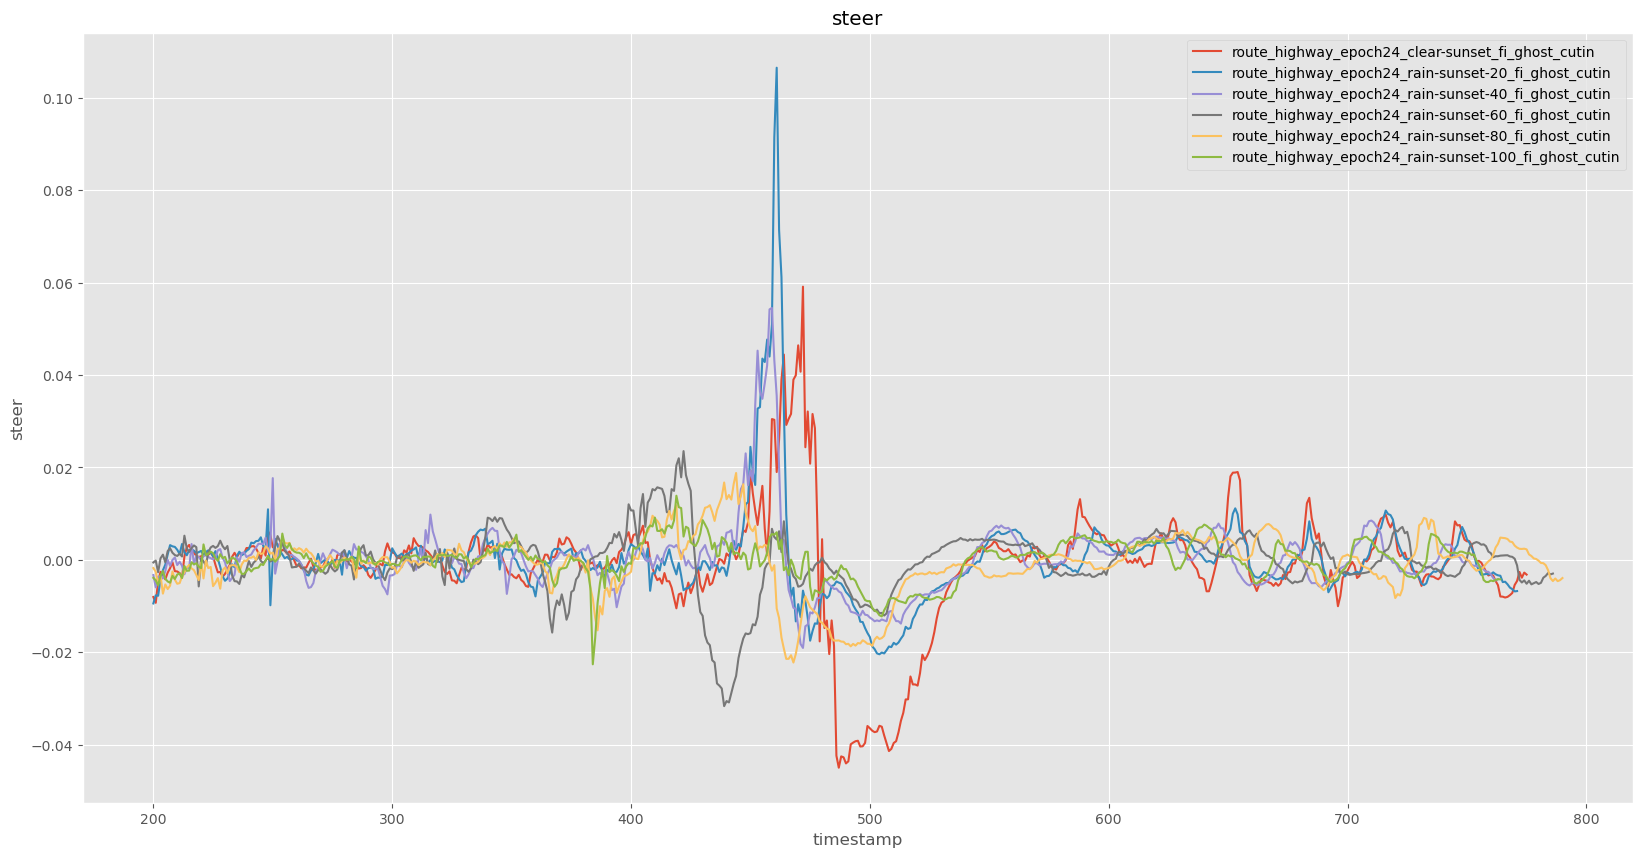

In [42]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_steer = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['steer'].dtypes == 'steer'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['steer'].isnull().values.any():
#                 df_orig_steer["Run"+str(i)] = df_array_orig[weather][i]['steer']

#     median_orig_steer = df_orig_steer.median(axis=1)


#     plt.plot(median_orig_steer[200:], alpha=0.7)


    df_fric_steer = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['steer'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['steer'].isnull().values.any() :
                df_fric_steer["Run"+str(i)] = df_array_fric[weather][i]['steer']

    median_fric_steer = df_fric_steer.median(axis=1)

    plt.plot(median_fric_steer[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("steer")
plt.title("steer")
plt.legend(full_legend)
plt.show()

### brake

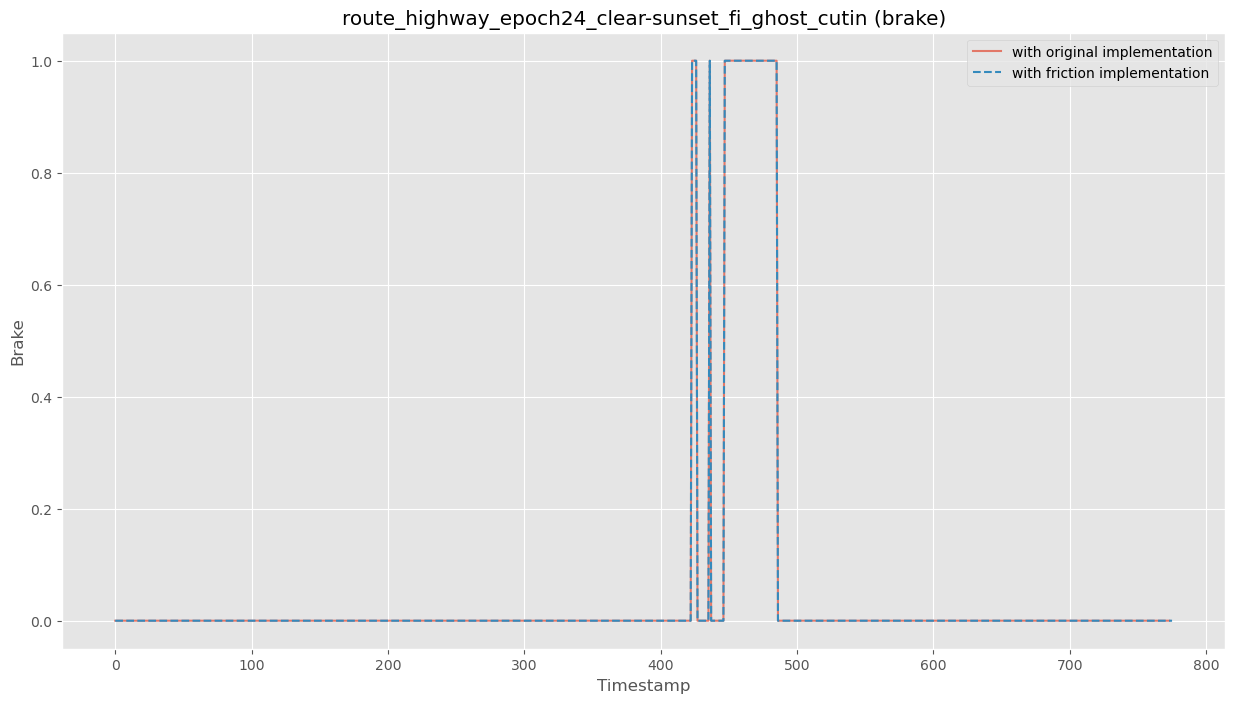

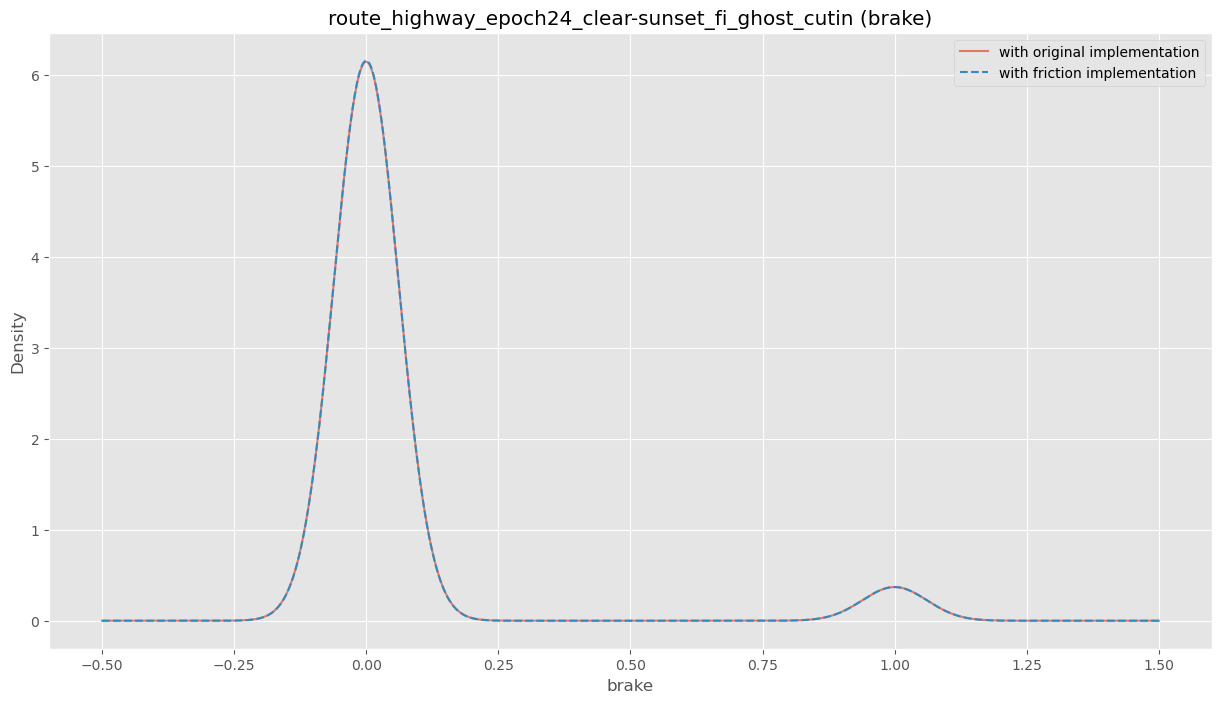

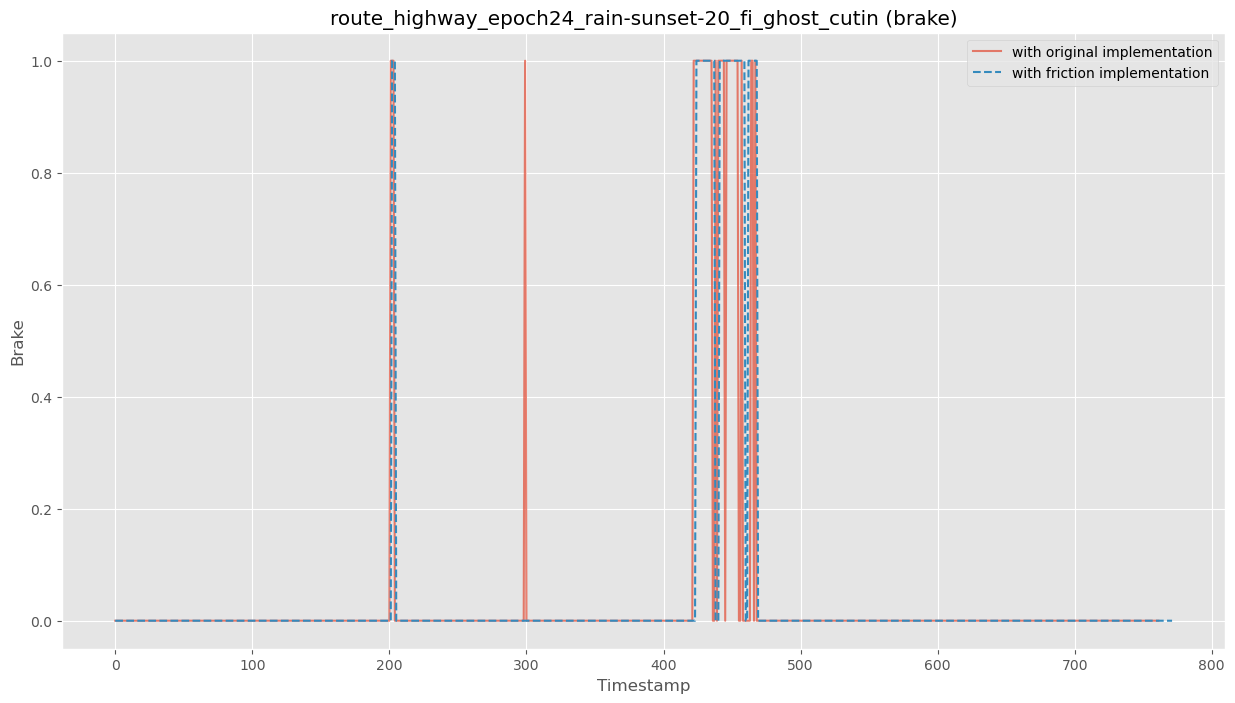

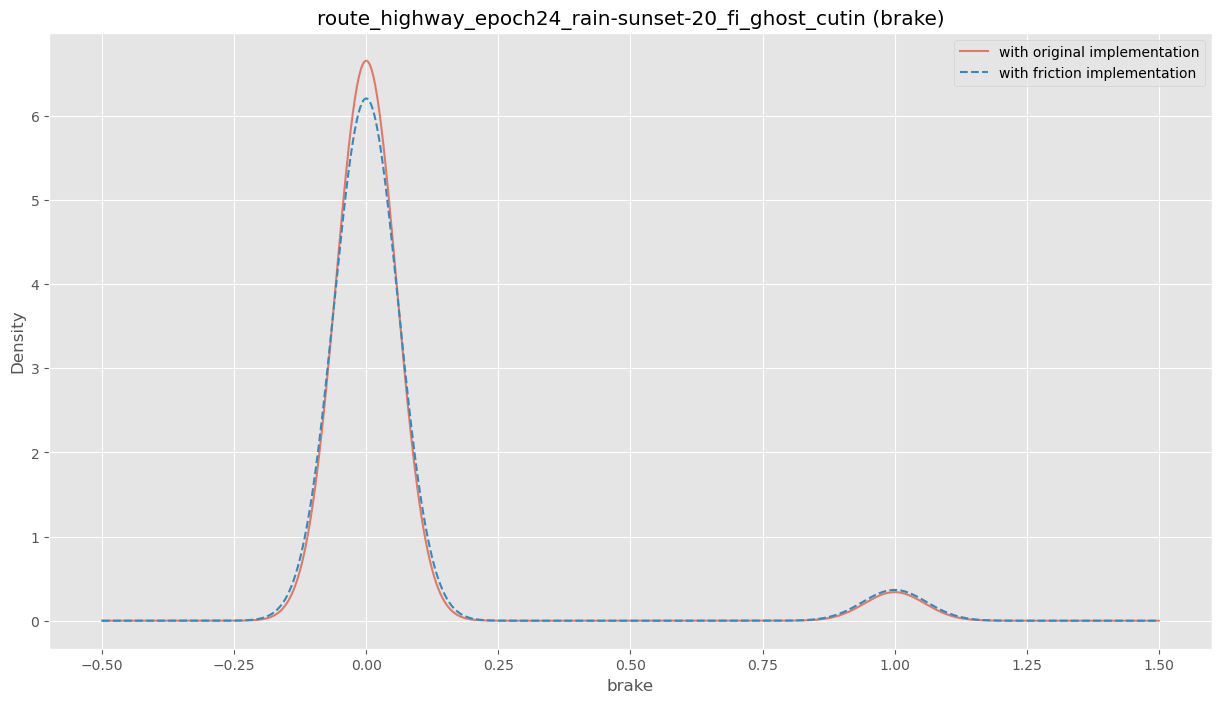

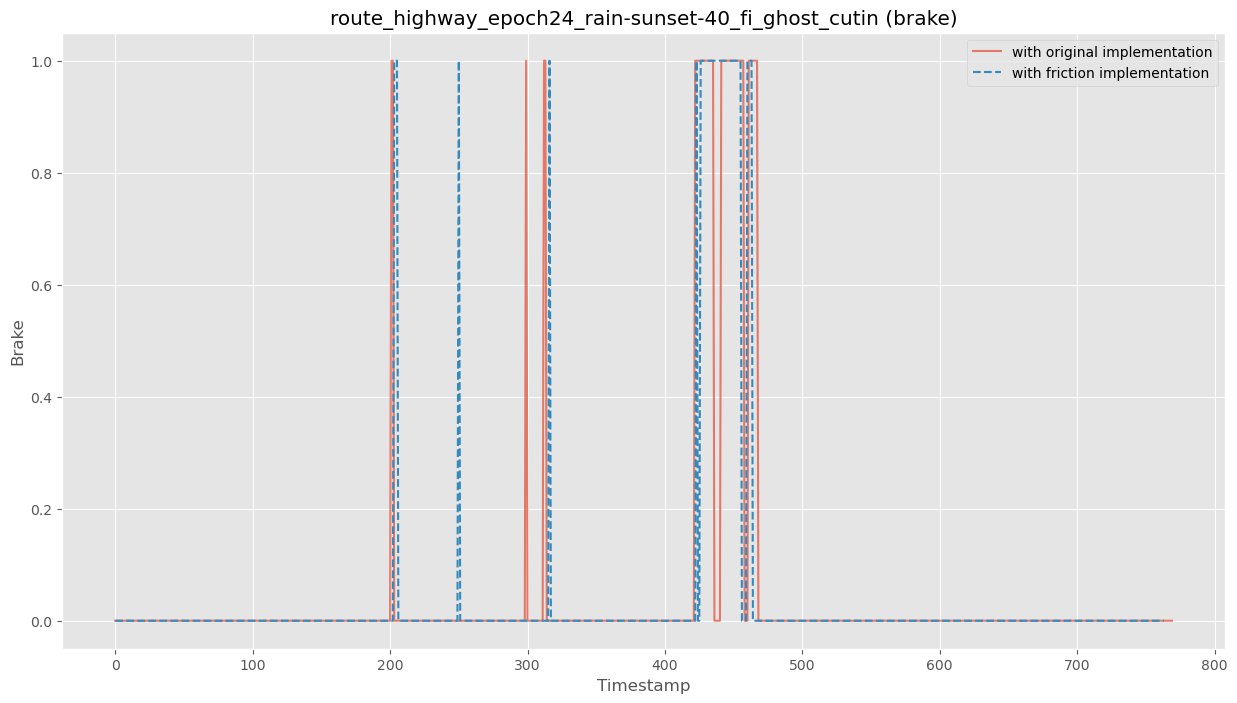

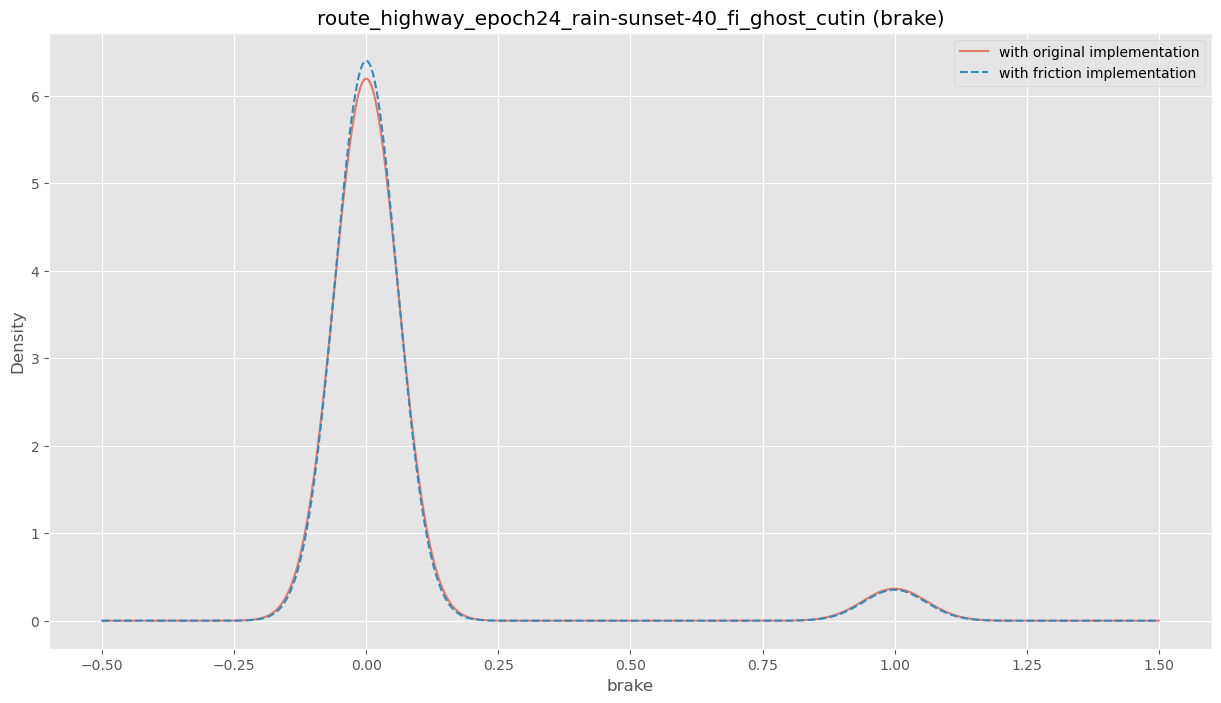

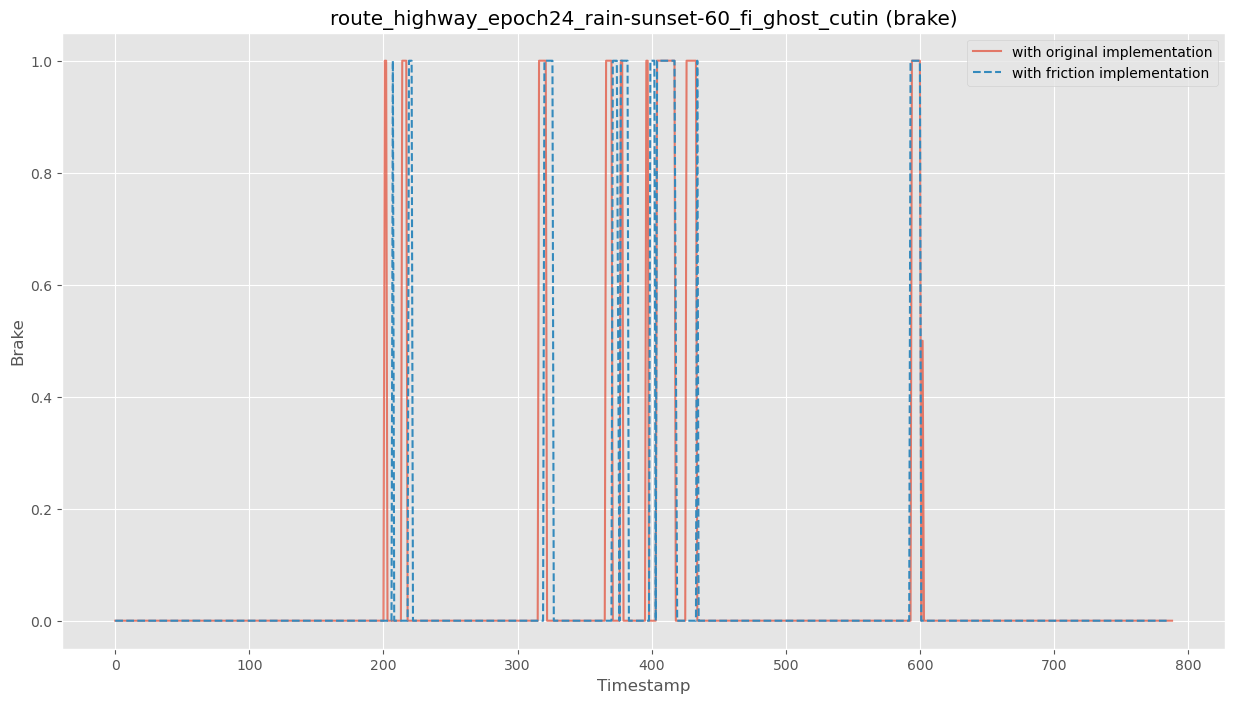

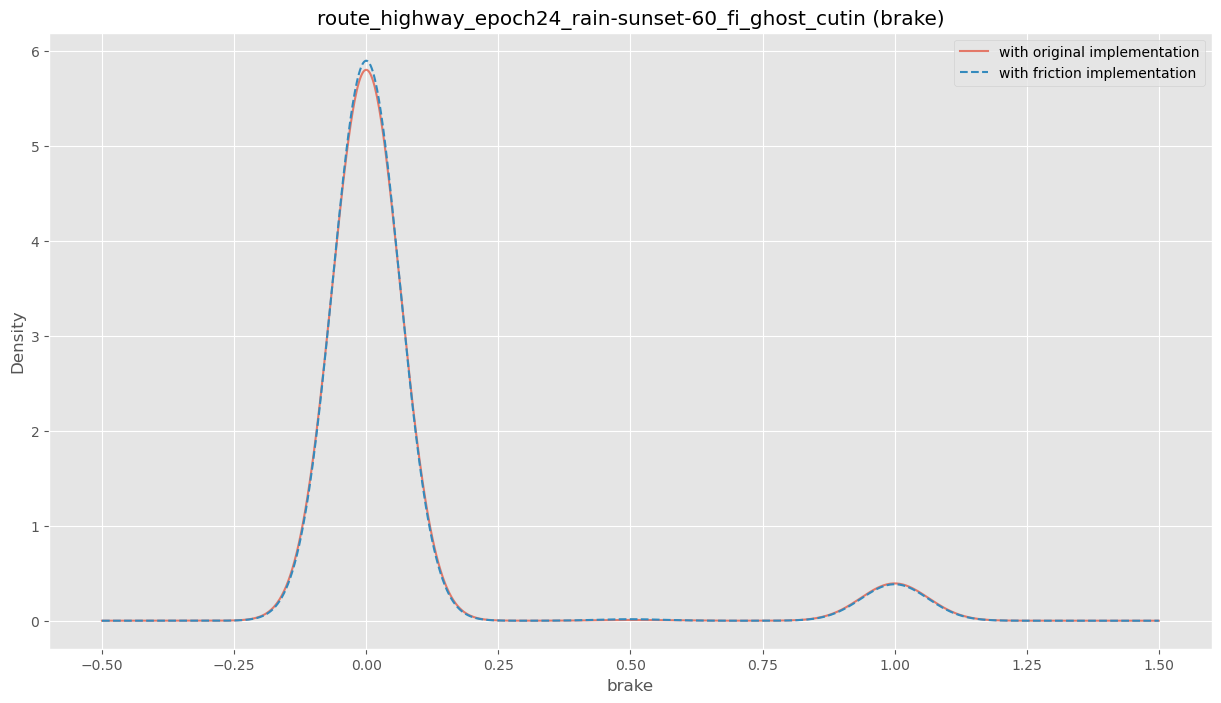

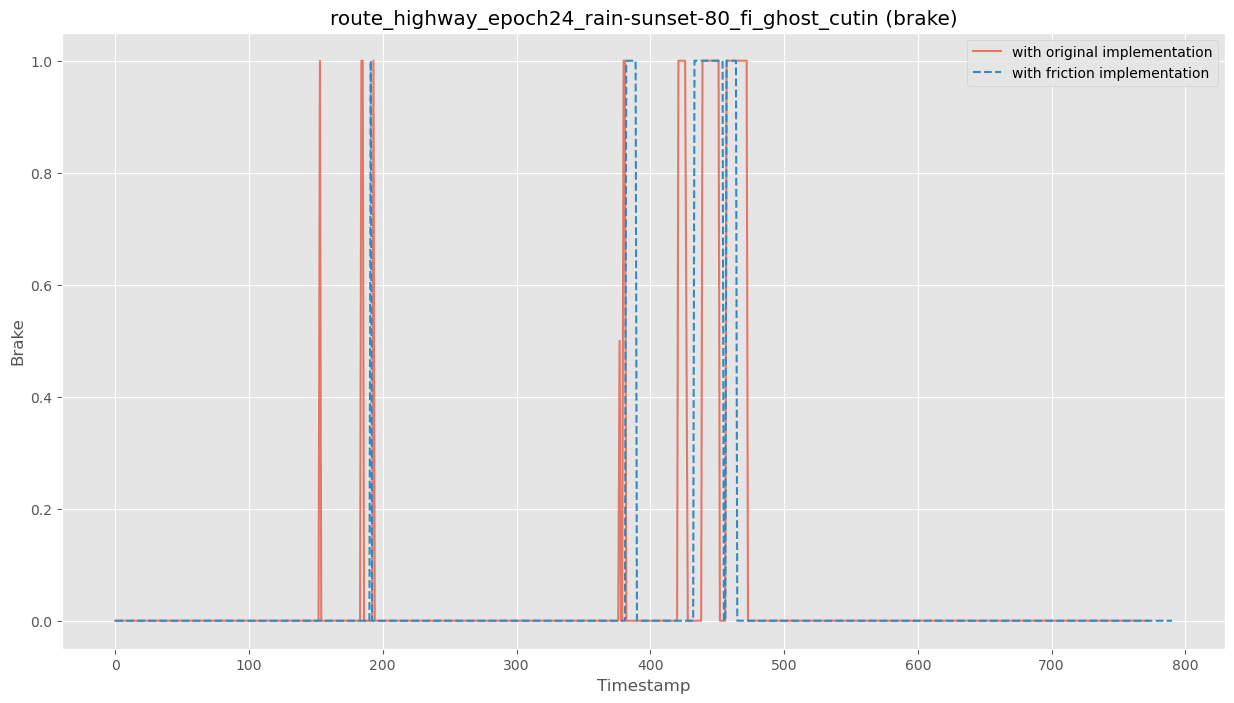

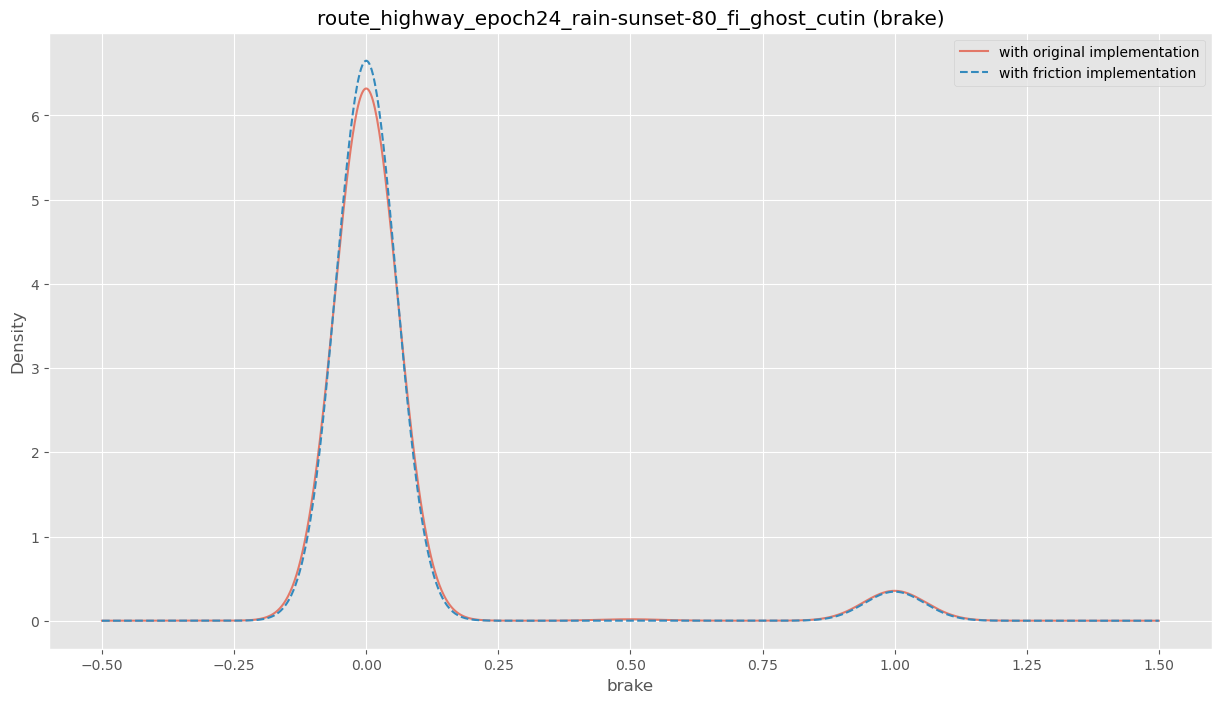

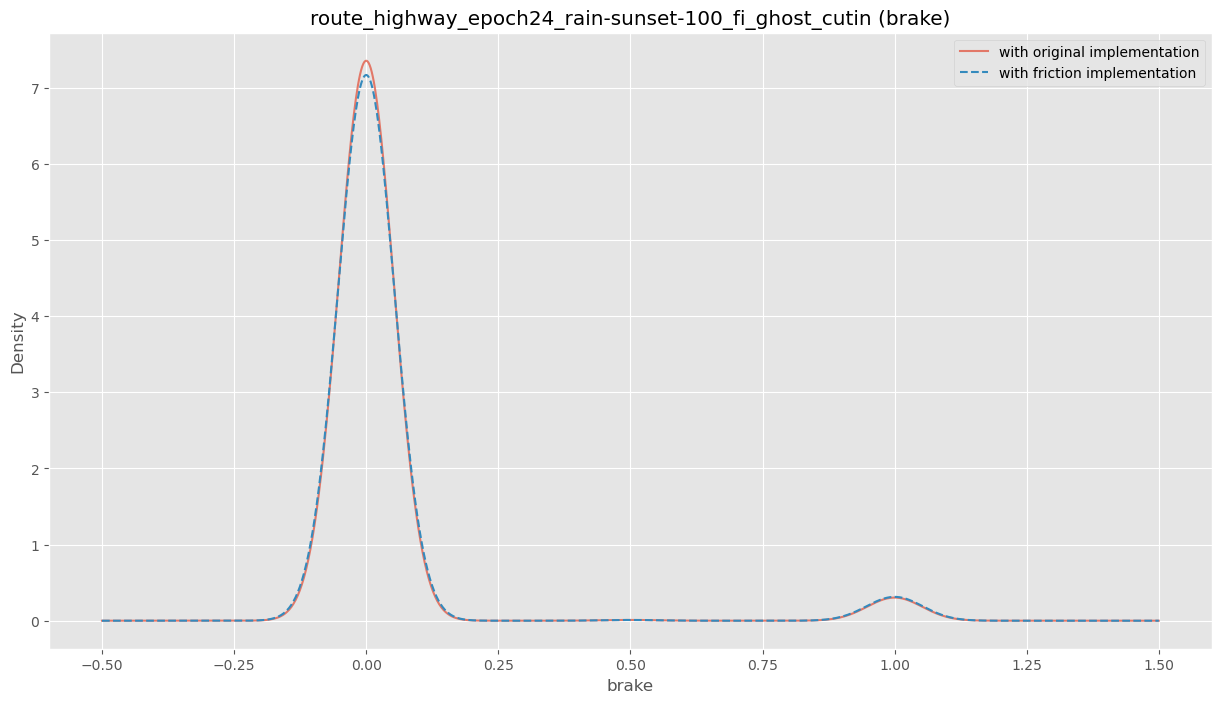

In [43]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_brake = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['brake'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['brake'].isnull().values.any():
                df_orig_brake["Run"+str(i)] = df_array_orig[weather][i]['brake']

    median_orig_brake = df_orig_brake.median(axis=1)

    plt.plot(median_orig_brake, alpha=0.7)


    df_fric_brake = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['brake'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['brake'].isnull().values.any():
                df_fric_brake["Run"+str(i)] = df_array_fric[weather][i]['brake']

    median_fric_brake = df_fric_brake.median(axis=1)
    
    all_medians[weather][5][0] = median_orig_brake
    all_medians[weather][5][1] = median_fric_brake
    
    plt.plot(median_fric_brake, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("Brake")
    plt.title(subfolders[weather] + " (brake)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("brake")
    plt.ylabel("Density")
    median_orig_brake.plot.density(alpha=0.7)
    median_fric_brake.plot.density(style='--')
    plt.title(subfolders[weather] + " (brake)")
    plt.legend(friction_legend)
    plt.show()
    

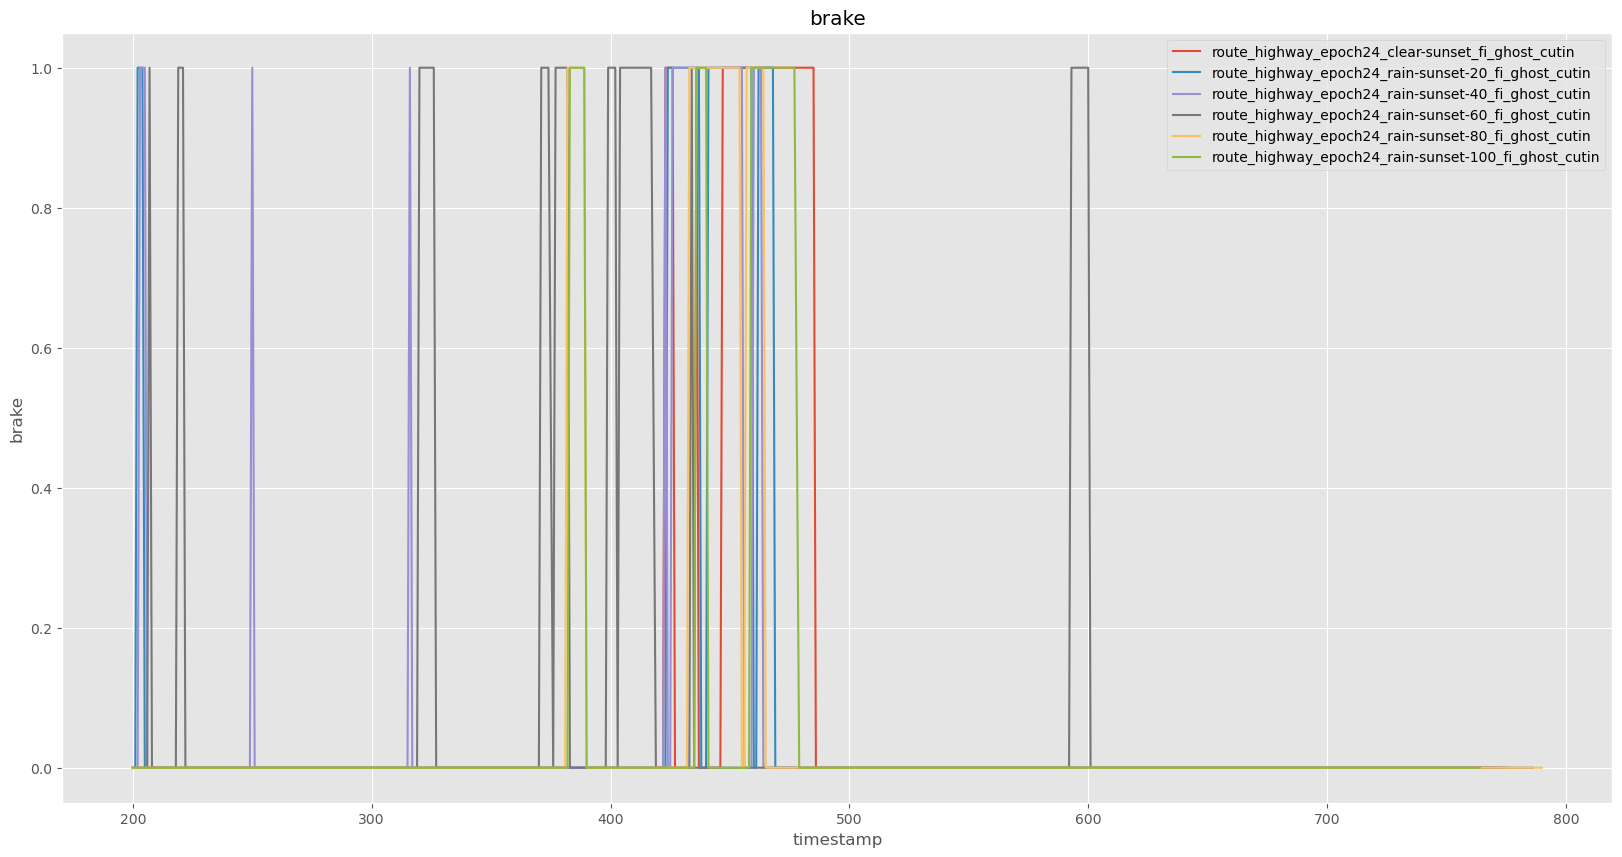

In [44]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_brake = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['brake'].dtypes == 'brake'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['brake'].isnull().values.any():
#                 df_orig_brake["Run"+str(i)] = df_array_orig[weather][i]['brake']

#     median_orig_brake = df_orig_brake.median(axis=1)


#     plt.plot(median_orig_brake[200:], alpha=0.7)


    df_fric_brake = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['brake'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['brake'].isnull().values.any() :
                df_fric_brake["Run"+str(i)] = df_array_fric[weather][i]['brake']

    median_fric_brake = df_fric_brake.median(axis=1)

    plt.plot(median_fric_brake[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("brake")
plt.title("brake")
plt.legend(full_legend)
plt.show()

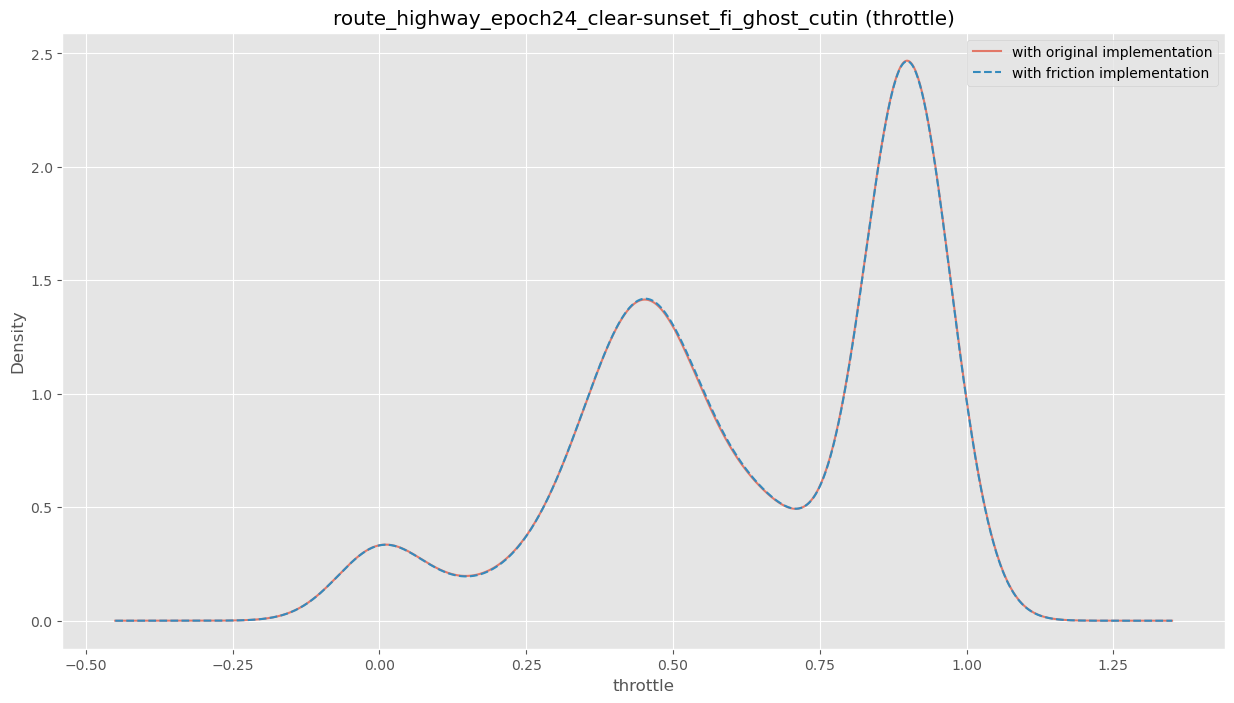

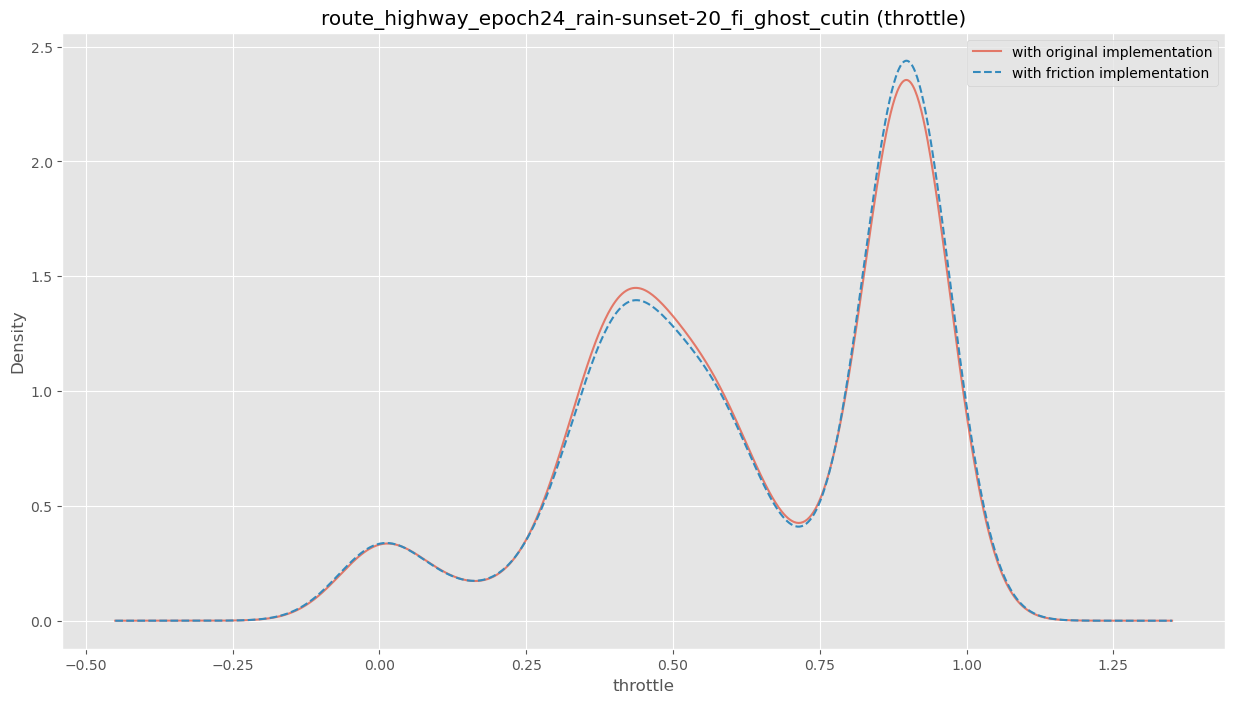

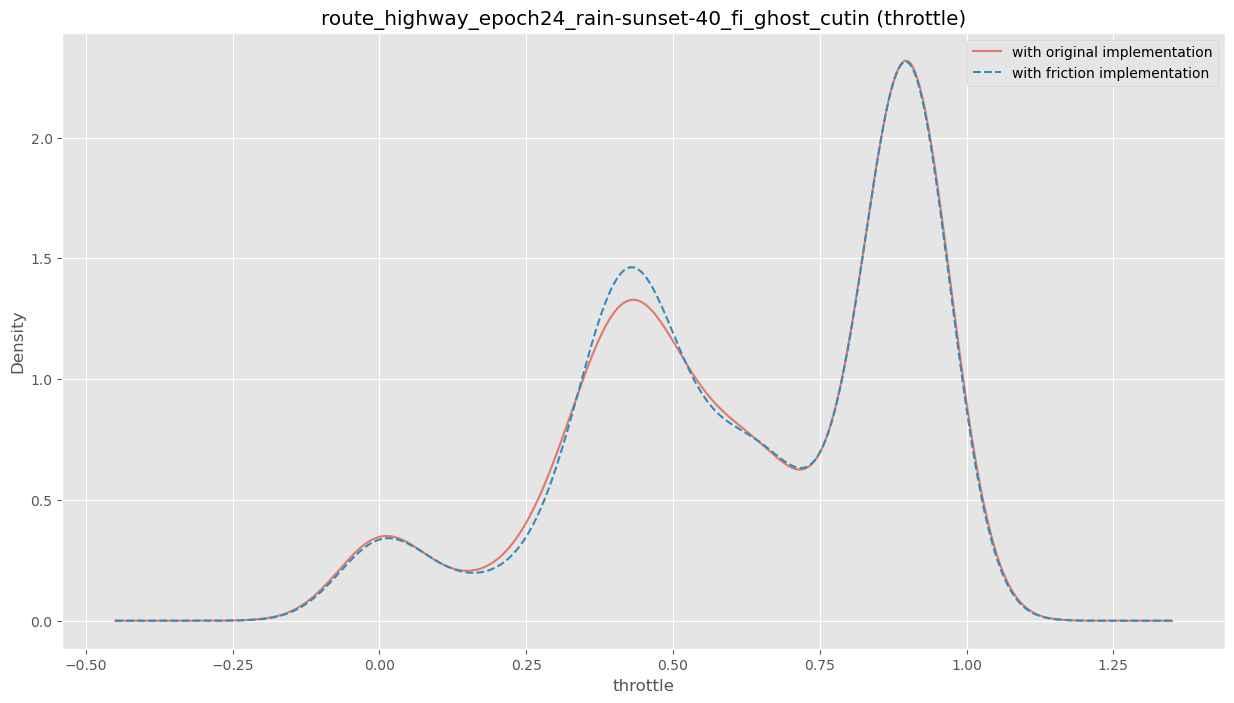

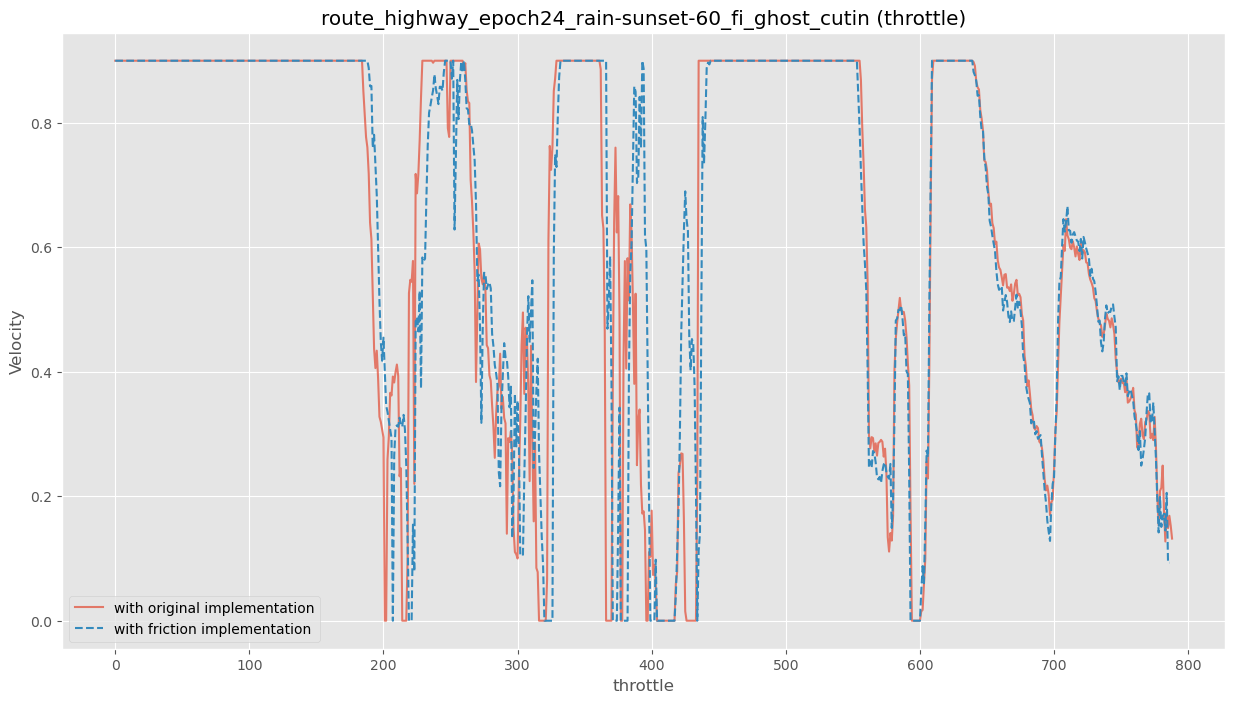

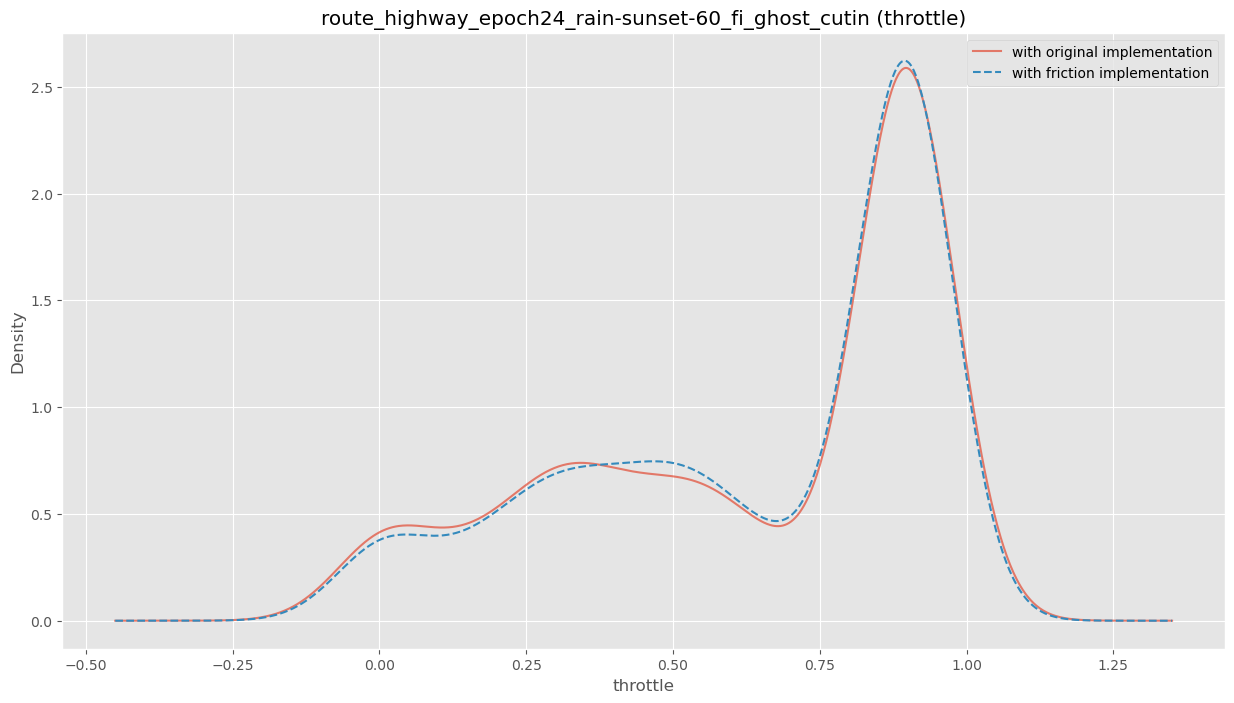

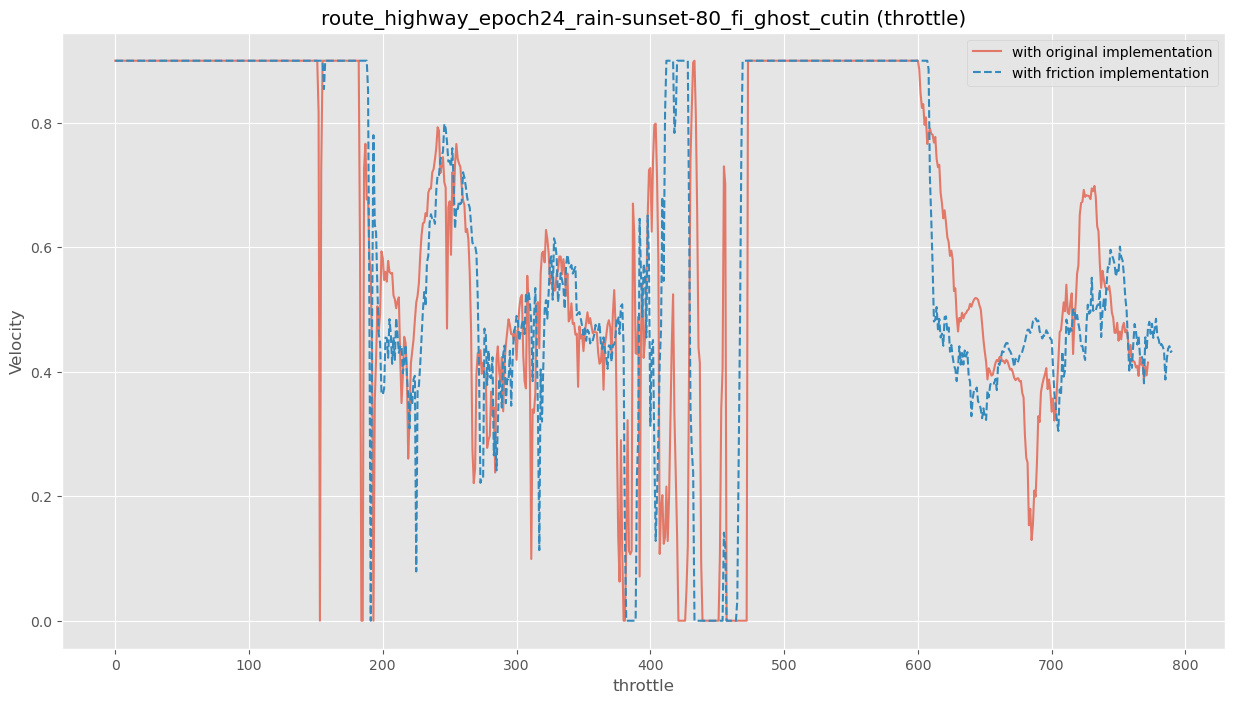

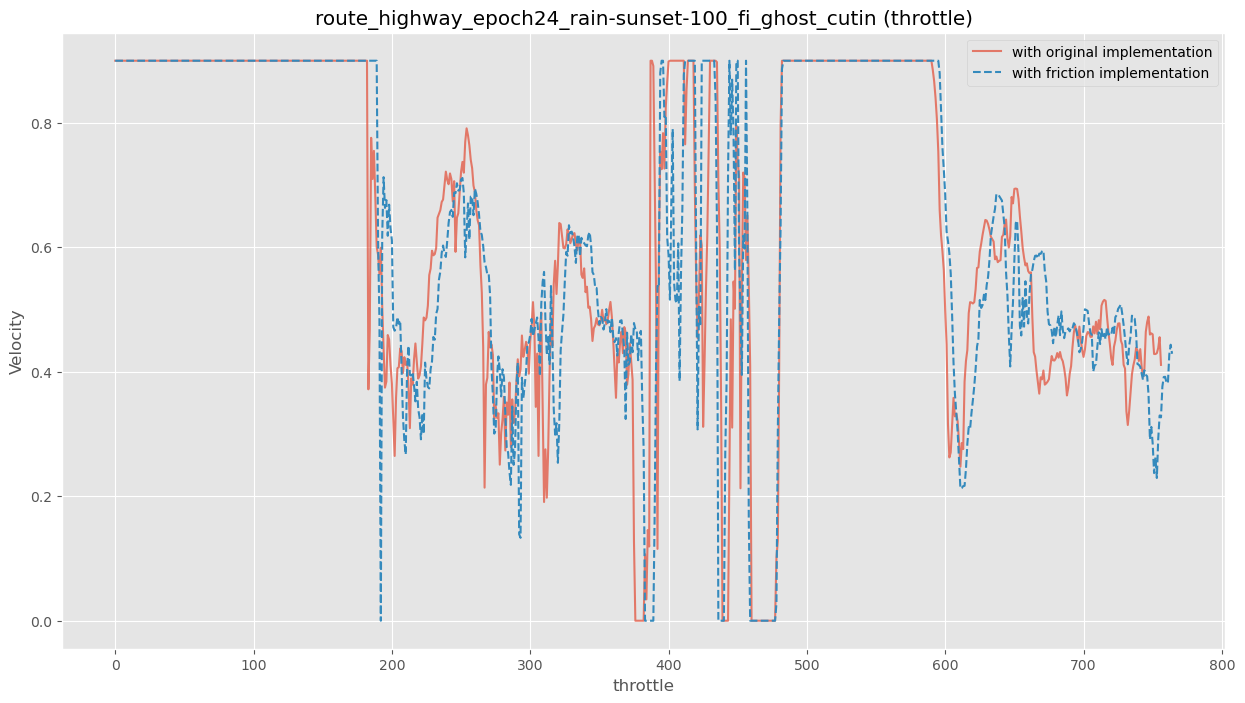

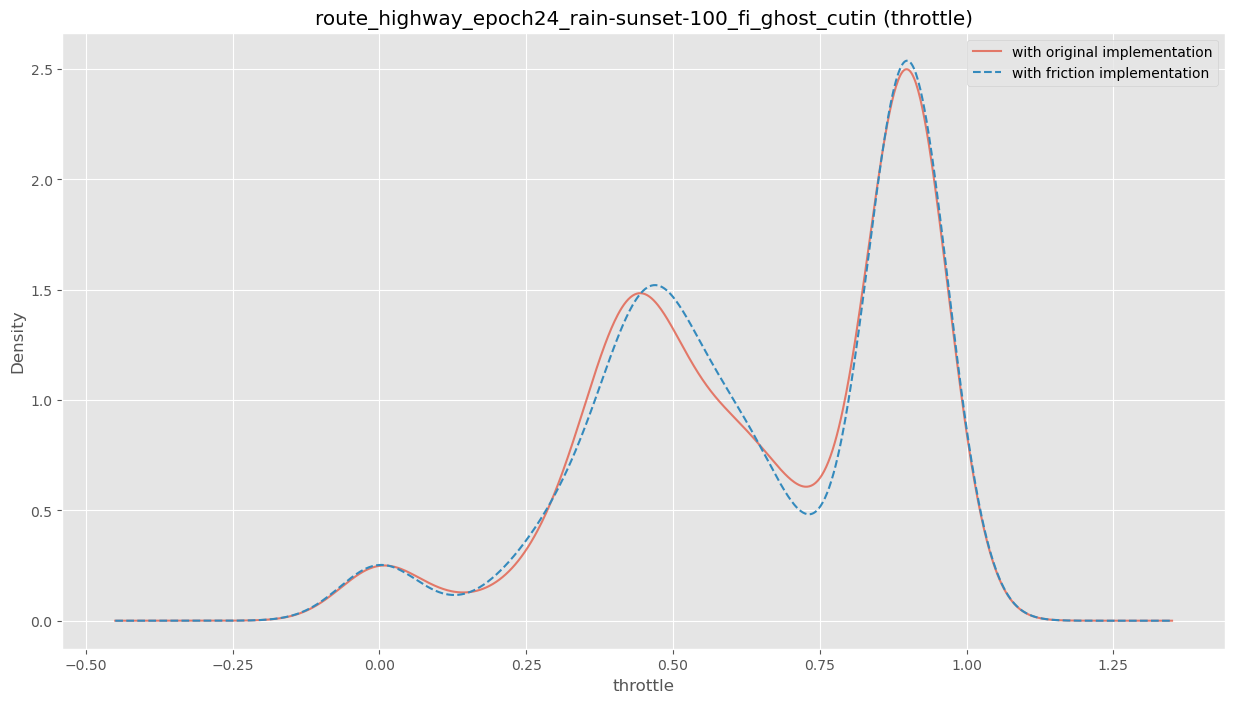

In [45]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_throttle = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['throttle'].isnull().values.any():
                df_orig_throttle["Run"+str(i)] = df_array_orig[weather][i]['throttle']

    median_orig_throttle = df_orig_throttle.median(axis=1)

    plt.plot(median_orig_throttle, alpha=0.7)


    df_fric_throttle = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['throttle'].isnull().values.any():
                df_fric_throttle["Run"+str(i)] = df_array_fric[weather][i]['throttle']

    median_fric_throttle = df_fric_throttle.median(axis=1)
    
    all_medians[weather][6][0] = median_orig_throttle
    all_medians[weather][6][1] = median_fric_throttle
    
    plt.plot(median_fric_throttle, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("throttle")
    plt.ylabel("Velocity")
    plt.title(subfolders[weather] + " (throttle)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("throttle")
    plt.ylabel("Density")
    median_orig_throttle.plot.density(alpha=0.7)
    median_fric_throttle.plot.density(style='--')
    plt.title(subfolders[weather] + " (throttle)")
    plt.legend(friction_legend)
    plt.show()
    

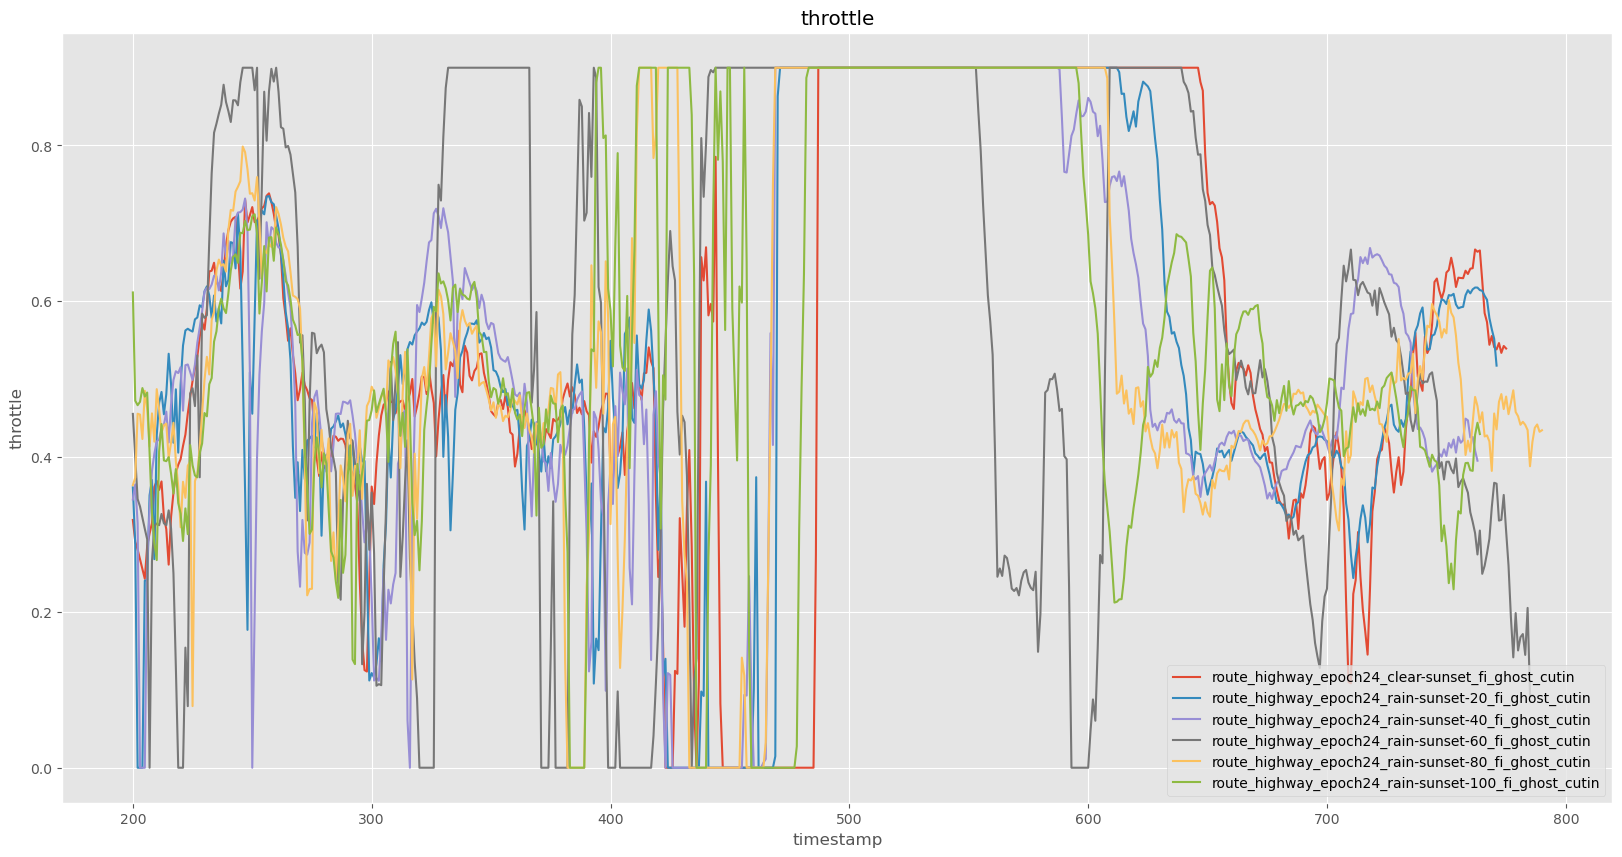

In [46]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_throttle = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['throttle'].dtypes == 'throttle'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['throttle'].isnull().values.any():
#                 df_orig_throttle["Run"+str(i)] = df_array_orig[weather][i]['throttle']

#     median_orig_throttle = df_orig_throttle.median(axis=1)


#     plt.plot(median_orig_throttle[200:], alpha=0.7)


    df_fric_throttle = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['throttle'].isnull().values.any() :
                df_fric_throttle["Run"+str(i)] = df_array_fric[weather][i]['throttle']

    median_fric_throttle = df_fric_throttle.median(axis=1)

    plt.plot(median_fric_throttle[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("throttle")
plt.title("throttle")
plt.legend(full_legend)
plt.show()

## Dynamic time warping (DTW) for cvip
### measuring similarity between two temporal sequences

In [47]:
all_dtw = [[0] * len(attribute_order)  for i in range(len(txt_lists_fric))]

for i in range(len(txt_lists_fric)):
    for j in range(len(attribute_order)):
        all_dtw[i][j] = dtw.distance(all_medians[i][j][0], all_medians[i][j][1])

In [48]:
for i in range(len(txt_lists_fric)):
    for j in range(len(attribute_order)):
        all_dtw[i][j] = round(all_dtw[i][j],2)

In [49]:
df = pd.DataFrame(all_dtw, columns = attribute_order, dtype = float)
df.index = subfolders
df.to_csv("reduced_friction_rain.csv")
df

x     y     v  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin     0.00  0.26  0.05   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin   0.05  1.48  4.03   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin   0.09  2.44  1.49   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin   0.11  1.64  3.07   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin   0.26  1.44  1.59   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  0.25  1.57  1.36   

                                                        cvip  steer  brake  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin       0.87   0.00   0.00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin     9.78   0.04   2.24   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin     4.54   0.05   0.00   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin     5.10   0.03   0.87   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin     5.06   0.03   2.12   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  203.96   0.03   1.22   

                                                      throttle  
route_highway_epoch24_clear-sunset_fi_ghost_cutin         0.05  
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin       0.68  
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin       0.92  
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin       1.11  
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin       1.87  
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin      1.38

## KS Test for cvip

In [50]:
import scipy as sp

In [51]:
all_ks = np.empty((len(txt_lists_fric), len(attribute_order), 2))
# [[0] * len(attribute_order)  for i in range(len(txt_lists_fric)-1)]
for i in range(len(txt_lists_fric)-1):
    for j in range(len(attribute_order)):
        ks_test = sp.stats.ks_2samp(all_medians[i][j][0], all_medians[i][j][1])
        all_ks[i][j][0] = ks_test.pvalue
        all_ks[i][j][1] = ks_test.statistic

In [52]:
df = pd.DataFrame(all_ks[:,:,0], columns = attribute_order, dtype = float)
df.index = subfolders
df

x  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    5.799759e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    4.722511e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    3.938870e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    5.391564e-03   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                                  y  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.000000e+00   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    9.046161e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    9.999660e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    6.494528e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                                  v  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    4.062944e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    4.349282e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    4.049382e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    5.408164e-02   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                               cvip  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    3.610441e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.276632e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    3.663945e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    3.618960e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                              steer  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    8.766824e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    8.013662e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    7.854995e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.941208e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                              brake  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.000000e+00   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.000000e+00   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.000000e+00   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.000000e+00   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                           throttle  
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00  
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    9.663194e-01  
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    8.645371e-01  
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    8.409295e-01  
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.299642e-01  
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311

In [53]:
df = pd.DataFrame(all_ks[:,:,1], columns = attribute_order, dtype = float)
df.index = subfolders
df

x  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      7.458909e-03   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    3.912869e-02   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    4.255797e-02   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    4.474807e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    8.636292e-02   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                                  y  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      3.862650e-03   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    9.267948e-03   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    2.833345e-02   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.533635e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    3.667390e-02   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                                  v  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      5.234556e-03   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    4.485061e-02   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    4.382947e-02   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    4.423917e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    6.734561e-02   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                               cvip  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      7.029356e-03   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    4.655053e-02   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    5.926770e-02   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    4.571595e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    4.608443e-02   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                              steer  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.020938e-02   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    2.954456e-02   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    3.226015e-02   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    3.235241e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    5.400830e-02   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                              brake  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.465143e-04   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    7.143051e-03   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    3.488135e-03   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    2.380251e-03   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    6.322748e-03   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311   

                                                           throttle  
route_highway_epoch24_clear-sunset_fi_ghost_cutin      6.226857e-03  
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    2.473379e-02  
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    3.001632e-02  
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    3.048750e-02  
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    5.852549e-02  
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.407859e-311

You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.
**pvalue=4.2177381979173086e-06**